# Pre-amble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import pandas as pd
import xarray as xr
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import dask
from dask import delayed, compute
from itertools import product
from importlib import reload
from functools import partial

# My imports
import os, sys
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import my_stats
import toe_calc
import toe_calc_variations
import toe_constants as toe_const
import toe_plots
from toe_plots import METRIC_MAP
import utils

Matplotlib created a temporary cache directory at /jobfs/159820871.gadi-pbs/matplotlib-xilgdyrq because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from utils import logger

In [3]:
# logger = utils.get_notebook_logger()

In [4]:
xr.set_options(display_expand_data=False)

In [5]:
SAVE_DIR = '/g/data/w40/ab2313/time_of_emergence/synthetic_data'

In [6]:
# client.close()  # Close existing client

In [8]:
from dask.distributed import Client, wait
# client.close()  # Close existing client
client = Client(n_workers=24, threads_per_worker=1, memory_limit=None)
client

<Client: 'tcp://127.0.0.1:37821' processes=24 threads=24>

<h1 style='color:cyan'> Universal   </h1>

<h2 style='color:yellow'> Universal Functions  </h2>

In [9]:
import scipy
from itertools import product

In [10]:
# np.random.gamma
# np.random.weibull
# scipy.stats.genextreme.rvs#(c, loc, scale, size)
# # np.random.lognormal(mean, sigma, size)

In [11]:
def rescale_noise(arr, target_std): return arr / np.std(arr) * target_std

In [12]:
import numpy as np
from scipy.signal import lfilter

def generate_red_noise(size=100, std=0.2, alpha=0):
    """
    Generates red noise (AR(1) process) with a specified standard deviation.

    Parameters:
    size (int): Length of the generated red noise sequence (default: 100).
    std (float): Desired standard deviation of the output red noise (default: 0.2).
    alpha (float): Autoregressive parameter (default: 0, which gives white noise).

    Returns:
    np.ndarray: Red noise sequence with the specified standard deviation.
    """

    # Generate standard normal white noise
    noise = np.random.normal(0, std, size)
    
    # Apply AR(1) filter to introduce autocorrelation
    if alpha: noise = lfilter([1], [1, -alpha], noise)
        
    # Normalize the output to match the desired standard deviation
    noise = rescale_noise(noise, std)
    # noise = noise / np.std(noise) * std
    return noise

In [13]:
def non_stationary_noise(arr: np.ndarray, start_std: float, end_std: float, window: int) -> np.ndarray:
    """
    Apply a linearly varying noise multiplier to an array.

    The function scales the input array using a smoothly increasing 
    standard deviation multiplier. The standard deviation starts at 
    a lower value and linearly increases, reaching `start_std` at 
    index `window//2` and `end_std` at `len(arr) - window//2`.

    Parameters:
    -----------
    arr : np.ndarray
        Input array to be scaled.
    start_std : float
        Standard deviation multiplier at index `window//2`.
    end_std : float
        Standard deviation multiplier at index `len(arr) - window//2`.
    window : int
        Defines the range within which the standard deviation scaling begins and ends.

    Returns:
    --------
    np.ndarray
        Scaled array with non-stationary noise applied.
    """

    n = len(arr)
    start_idx = window // 2
    end_idx = n - window // 2

    std_mult_series = np.linspace(
        start_std - (start_idx / (end_idx - start_idx)) * (end_std - start_std),
        end_std + ((n - end_idx) / (end_idx - start_idx)) * (end_std - start_std),
        n
    )

    return arr * std_mult_series

In [14]:
sample_ts = generate_red_noise(300, 1, 0)

In [15]:
sample_ts_new = non_stationary_noise(sample_ts, start_std=0.1, end_std=1, window=30)

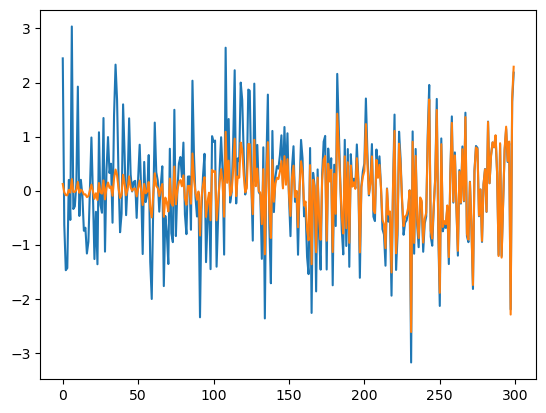

In [16]:
plt.plot(sample_ts)
plt.plot(sample_ts_new)

In [17]:
std_list = np.arange(0.1, 0.5, 0.1)
rho_list = np.arange(0.1, 0.5, 0.1)

for std, rho in product(std_list, rho_list):
    output_std = np.std(generate_red_noise(300, std, rho))
    print(f'{std=:.2f} - {rho=:.2f} - {output_std:.2f} - ({(std-output_std):.2f})')


std=0.10 - rho=0.10 - 0.10 - (-0.00)
std=0.10 - rho=0.20 - 0.10 - (0.00)
std=0.10 - rho=0.30 - 0.10 - (-0.00)
std=0.10 - rho=0.40 - 0.10 - (0.00)
std=0.20 - rho=0.10 - 0.20 - (0.00)
std=0.20 - rho=0.20 - 0.20 - (0.00)
std=0.20 - rho=0.30 - 0.20 - (-0.00)
std=0.20 - rho=0.40 - 0.20 - (0.00)
std=0.30 - rho=0.10 - 0.30 - (0.00)
std=0.30 - rho=0.20 - 0.30 - (-0.00)
std=0.30 - rho=0.30 - 0.30 - (0.00)
std=0.30 - rho=0.40 - 0.30 - (0.00)
std=0.40 - rho=0.10 - 0.40 - (0.00)
std=0.40 - rho=0.20 - 0.40 - (0.00)
std=0.40 - rho=0.30 - 0.40 - (0.00)
std=0.40 - rho=0.40 - 0.40 - (-0.00)


In [18]:
def generate_base_noise(distribution, **kwargs):
    """
    Returns a pre-configured noise generation function with fixed parameters.

    Parameters:
    distribution (str): The distribution to slog in as the base noise source.
    **kwargs: Additional parameters required for each distribution.

    Returns:
    function: A function that generates noise samples when called.
    """

    if distribution == "normal": return partial(np.random.normal, **kwargs)
    elif distribution == "gamma": return partial(np.random.gamma, **kwargs)
    elif distribution == "lognormal": return partial(np.random.lognormal, **kwargs)
    elif distribution == "weibull": return partial(np.random.weibull, **kwargs)
    elif distribution == "exponential": return partial(np.random.exponential, **kwargs)
    elif distribution == "gumbel": return partial(np.random.gumbel, **kwargs)
    elif distribution == "poisson": return partial(np.random.poisson, **kwargs)
    else:
        raise ValueError(
            "Unsupported distribution type. Choose from: normal, gamma, lognormal, weibull, exponential, gumbel, poisson."
        )

In [19]:
def generate_noise_process(size, alpha, noise_func):
    """
    Generates an autocorrelated noise process (AR(1) process) using a given noise function.

    Parameters:
    size (int): Length of the generated noise sequence.
    alpha (float): Autoregressive parameter (0 gives uncorrelated noise).
    noise_func (function): Pre-configured function to generate noise samples.

    Returns:
    np.ndarray: Noise process sequence with the specified autocorrelation.
    """
    
    # Generate noise using the pre-configured function
    base_noise = noise_func(size)

    # Apply AR(1) filter to introduce autocorrelation
    noise_process = lfilter([1], [1, -alpha], base_noise)

    # Normalize the output to match the original standard deviation
    noise_process = noise_process / np.std(noise_process) * np.std(base_noise)

    return noise_process

In [20]:
# # Create a noise generator with specific parameters
# gamma_noise = generate_base_noise("gamma", shape=2, scale=0.5)
# lognormal_noise = generate_base_noise("lognormal", mean=0, sigma=0.3)

# # Use it in the AR(1) noise process
# gamma_series = generate_noise_process(size=1000, alpha=0.8, noise_func=gamma_noise)
# lognormal_series = generate_noise_process(size=1000, alpha=0.5, noise_func=lognormal_noise)


In [21]:
def generate_noise_ensemble(std: float, rho: float, num_trials: int = 200, 
                            atol: float = None, rtol: float = None, length: int = 100, 
                            batch_size: int = 100):
    """
    Generate an ensemble of red noise series with a specified standard deviation in parallel batches.

    Parameters:
    - std: Target standard deviation of the noise series.
    - rho: Autoregressive coefficient for red noise.
    - num_trials: Number of noise series to generate.
    - atol: Absolute tolerance for matching the desired standard deviation.
    - rtol: Relative tolerance for matching the desired standard deviation.
    - length: Length of each noise series.
    - batch_size: Number of noise series processed in a single batch.

    Returns:
    - A NumPy array containing the noise ensemble.
    """

    if atol is None and rtol is None:
        atol = 0.05 * std
    elif rtol is not None:
        atol = rtol * std

    print(f'\n{std=} - {rho=} - {length=} - {atol=}\n')

    @delayed
    def generate_batch():
        """ Generate a batch of red noise and filter valid samples. """
        samples = np.array([generate_red_noise(length, std, rho) for _ in range(batch_size)])
        stds = np.std(samples, axis=1)
        valid_samples = samples[(stds > (std - atol)) & (stds < (std + atol))]
        print(f'len - {len(valid_samples)}')
        return valid_samples

    collected_samples = []
    to_compute = []

    
    batch_num = 0  # Track batch number
    while len(collected_samples) < num_trials:
        batch_num += 1
        print(f"{batch_num} ({len(collected_samples)}), ", end='')  # Print batch number
    
        batch = generate_batch()  # Create delayed task
        valid_samples = compute(batch)[0]  # Compute after each batch
        
        collected_samples.extend(valid_samples)

        # # Stop if we have enough samples
        # if len(collected_samples) >= num_trials:
        #     break

    # Trim to exactly `num_trials`
    noise_series_arr = np.array(collected_samples[:num_trials])

    # Convert to xarray
    noise_bs_xr = xr.DataArray(
        noise_series_arr,
        dims=("iteration", "time"),
        coords={"iteration": np.arange(num_trials), "time": np.arange(length),
               'rho': rho, 'std': std}
    ).chunk({'iteration':'auto', 'time':-1})


    return noise_bs_xr

<h2 style='color:yellow'> Universal Parameters </h2>

* Defining true trend

In [22]:
base_period_length = 30
window = 30

In [23]:
base_period = np.tile(0, base_period_length)
grad = 1.2/140 # 1.2 degree change since 1850
# grad = 0.6/140 # 1.2 degree change since 1850

trend_line = grad * np.arange(470)  # Linear trend

true_trend = np.concatenate([base_period, trend_line])
true_trend.shape

(500,)

In [24]:
x = np.linspace(0, true_trend.shape[0], 6000)

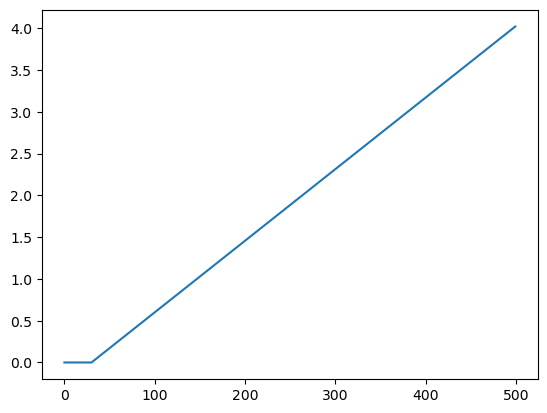

In [25]:
plt.plot(true_trend)

In [26]:
kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)
kde_create_kwargs = dict(
    input_core_dims=[['iteration']],
    output_core_dims=[['x']],
    kwargs={'x': x, **kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
    output_dtypes=[float]
)

<h1 style='color:cyan'> Demonstration: Single Ensemble </h1>

In [29]:
np.random.seed(51)

# # Generate time series
# n = 150  # Number of time points
# base_period = np.tile(0, 30)
# grad = 1.2/130 # 1.2 degree change since 1850
# trend_line = grad * np.arange(150)  # Linear trend

# true_trend = np.concatenate([base_period, trend_line])
t = np.arange(len(true_trend))

In [30]:
base_noise = generate_red_noise(len(true_trend), std=0.25, alpha=0.3)
base_noise.shape

(500,)

In [31]:
target_std = [0.25, 0.5, 1, 2]

In [32]:
noise_series = np.asarray([rescale_noise(base_noise, std) for std in target_std])

In [33]:
np.std(noise_series, axis=1)

array([0.25, 0.5 , 1.  , 2.  ])

In [34]:
noise_series.shape

(4, 500)

In [35]:
# # Define the iterations coordinate
num_iterations = 4
iterations = np.arange(1, num_iterations + 1)
# iterations

In [36]:
# Compute noisy signals (vectorized)
noisy_signals = true_trend/4 + np.outer(iterations, base_noise)

# Convert to xarray DataArray
noisy_series_xr = xr.DataArray(
    noisy_signals,
    dims=( "noise_index","time"),  # Using 'noise_index' as requested
    coords={"noise_index": np.arange(num_iterations),  "time": t}
)

In [37]:
noisy_signals.shape

(4, 500)

In [38]:
noisy_series_xr

<xarray.DataArray (noise_index: 4, time: 500)> Size: 16kB
-0.06998 0.006017 0.3031 -0.2369 -0.047 ... 1.787 0.005931 -0.1584 0.5746 0.9235
Coordinates:
  * noise_index  (noise_index) int64 32B 0 1 2 3
  * time         (time) int64 4kB 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499

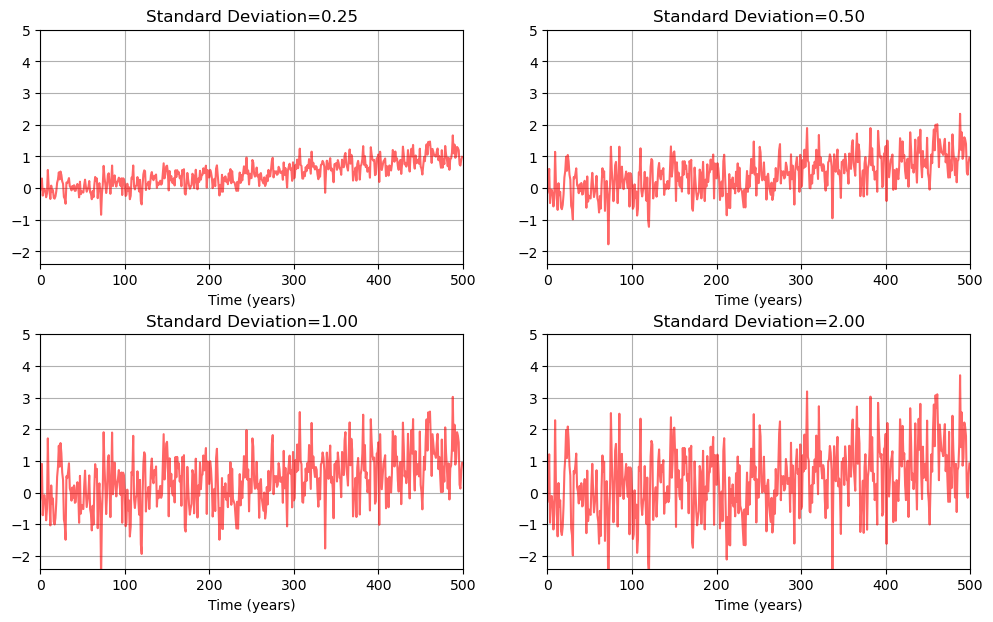

In [39]:
nrows = 2
ncols = 2
num_plot = nrows*ncols


fig = plt.figure(figsize=(6*nrows, 3.5*ncols))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.3)
axes = [fig.add_subplot(gs[i]) for i in range(num_plot)]

time = noisy_series_xr.time.values

for i in np.arange(num_iterations):

    noisy_series = noisy_series_xr.sel(noise_index=i).values

    
    axes[i].plot(time, noisy_series, color='red', alpha=0.6)
    # axes[i].plot(t, true_trend, linestyle='dashed', color='black', label='True Trend')
    
    axes[i].set_title(f'Standard Deviation={np.std(noise_series[i]):.2f}')
    # axes[i].legend()
    axes[i].grid(True)

    axes[i].set_xlim(0, len(time))
    axes[i].set_ylim(-2.4, 5)
    
# axes[0].set_ylabel('Value')
for ax in axes:
    ax.set_xlabel('Time (years)')

# plt.tight_layout()

In [40]:
signal_df = xr.apply_ufunc(
    my_stats.apply_lowess,
    noisy_series_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True
)

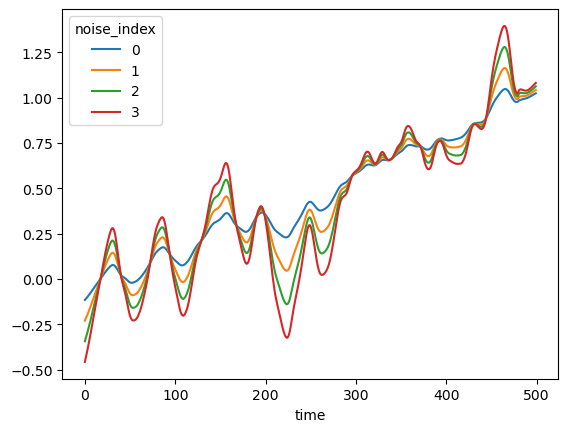

In [41]:
signal_df.plot(hue='noise_index');

In [42]:
noise_df = noisy_series_xr.isel(time=slice(0,30)).std(dim='time')
noise_df

<xarray.DataArray (noise_index: 4)> Size: 32B
0.269 0.5381 0.8071 1.076
Coordinates:
  * noise_index  (noise_index) int64 32B 0 1 2 3

In [43]:
sn_df = signal_df/noise_df

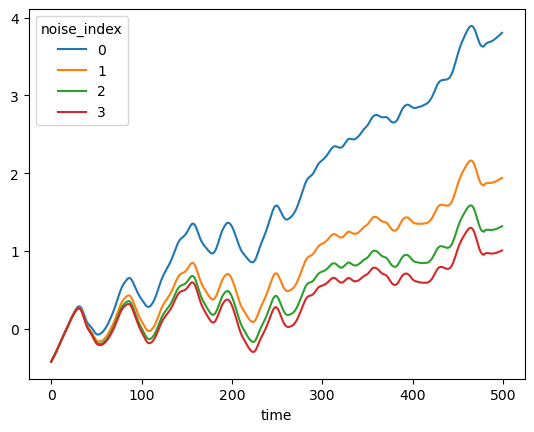

In [44]:
sn_df.plot(hue='noise_index');

<h1 style='color:cyan'> Base data generation </h1>

In [34]:
std_values = [0.1, 0.25, 0.5, 0.75, 1]
rho_values = [0, 0.25, 0.5, 0.75]

# First, concatenate along std
std_concat_list = []
for std in std_values:
    rho_concat_list = [
        generate_noise_ensemble(
            std, rho, length=true_trend.shape[0],
            rtol=0.2, num_trials=10000)
        for rho in rho_values]
    std_concat_list.append(xr.concat(rho_concat_list, dim="rho"))

# Then, concatenate along rho
noise_ensemble_da = xr.concat(std_concat_list, dim="std")


std=0.1 - rho=0 - length=500 - atol=0.020000000000000004

1 (0), 2 (100), 3 (200), 4 (300), 5 (400), 6 (500), 7 (600), 8 (700), 9 (800), 10 (900), 11 (1000), 12 (1100), 13 (1200), 14 (1300), 15 (1400), 16 (1500), 17 (1600), 18 (1700), 19 (1800), 20 (1900), 21 (2000), 22 (2100), 23 (2200), 24 (2300), 25 (2400), 26 (2500), 27 (2600), 28 (2700), 29 (2800), 30 (2900), 31 (3000), 32 (3100), 33 (3200), 34 (3300), 35 (3400), 36 (3500), 37 (3600), 38 (3700), 39 (3800), 40 (3900), 41 (4000), 42 (4100), 43 (4200), 44 (4300), 45 (4400), 46 (4500), 47 (4600), 48 (4700), 49 (4800), 50 (4900), 51 (5000), 52 (5100), 53 (5200), 54 (5300), 55 (5400), 56 (5500), 57 (5600), 58 (5700), 59 (5800), 60 (5900), 61 (6000), 62 (6100), 63 (6200), 64 (6300), 65 (6400), 66 (6500), 67 (6600), 68 (6700), 69 (6800), 70 (6900), 71 (7000), 72 (7100), 73 (7200), 74 (7300), 75 (7400), 76 (7500), 77 (7600), 78 (7700), 79 (7800), 80 (7900), 81 (8000), 82 (8100), 83 (8200), 84 (8300), 85 (8400), 86 (8500), 87 (8600), 88 (8

In [35]:
true_trend.shape

(500,)

In [36]:
noise_ensemble_da

<xarray.DataArray (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0

In [37]:
trend_bs_xr = noise_ensemble_da + true_trend

In [38]:
trend_bs_xr

<xarray.DataArray (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


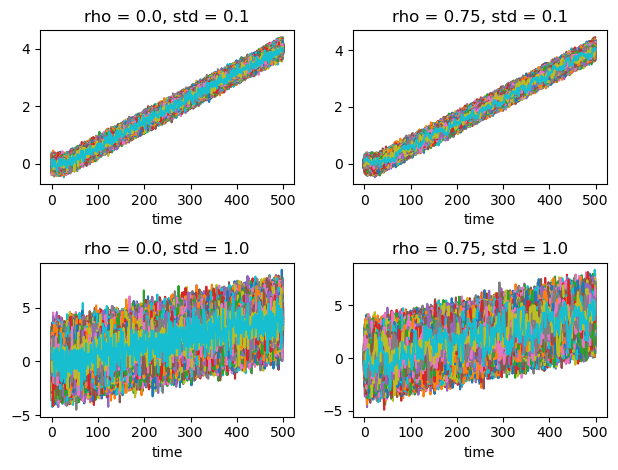

In [39]:
fig, axes = plt.subplots(2, 2)
axes = axes.ravel()

trend_bs_xr.sel(std=0.1, rho=0).plot(ax=axes[0], hue='iteration', add_legend=False);
trend_bs_xr.sel(std=0.1, rho=0.75).plot(ax=axes[1], hue='iteration', add_legend=False);
trend_bs_xr.sel(std=1, rho=0).plot(ax=axes[2], hue='iteration', add_legend=False);
trend_bs_xr.sel(std=1, rho=0.75).plot(ax=axes[3], hue='iteration', add_legend=False);

plt.tight_layout()

In [40]:
data_ds_window = (trend_bs_xr
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  # .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds = (trend_bs_xr.sel(time=slice(0, base_period_length))
                         # .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )
wait(data_ds_window);
wait(base_period_window_ds);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 763.01 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [41]:
trend_bs_xr

<xarray.DataArray (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0

### KS and Overlap

In [42]:
# # The arguements needed for all of the calculations
# rolling_window_kwargs = dict(
#     input_core_dims=[['window_dim'], ['window_dim']],
#     exclude_dims={'window_dim'},
#     vectorize=True,
#     dask='parallelized')

In [43]:
# %%time
# # Expected 3 minutes 30 seconds - best
# # 6 23 - era5
# ks_ds = xr.apply_ufunc(
#         toe_calc.return_ks_pvalue,
#         data_ds_window,
#         base_period_window_ds,
#     **rolling_window_kwargs
#     ).compute()

In [44]:
%%time
ks_ds = toe_calc_variations.ks(data_ds_window, base_period_window_ds)

In [45]:
# import toe_calc_variations

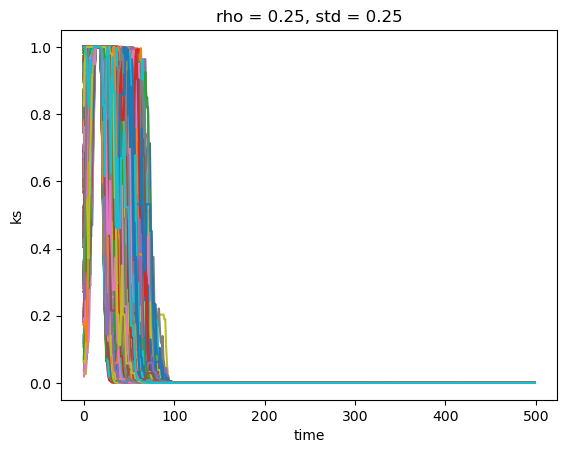

In [46]:
ks_ds.sel(rho=0.25, std=0.25).plot(hue='iteration', add_legend=False);

In [47]:
%%time
fga_ds = toe_calc_variations.fga(
    trend_bs_xr, trend_bs_xr.isel(time=slice(0, base_period_length)), data_ds_window).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [48]:
fga_ds

<xarray.DataArray 'frac' (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
81.89 83.64 90.0 88.37 88.43 ... 0.0109 0.00677 1.947e-12 2.821e-25 2.827e-26
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
Attributes:
    bw_method:   0.2
    bmin:        -4.91480215867236
    bmax:        8.865021559479432
    num_points:  1000

### S/N Ratio

In [49]:
trend_anom_bs_xr = trend_bs_xr - trend_bs_xr.isel(time=slice(0, base_period_length)).mean(dim='time')

In [50]:
signal_bs_xr = xr.apply_ufunc(
    my_stats.apply_lowess,
    trend_anom_bs_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [51]:
noise_bs_xr = trend_bs_xr.isel(time=slice(0, base_period_length)).std(dim='time')

In [52]:
sn_bs_xr = signal_bs_xr/noise_bs_xr

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 801.09 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


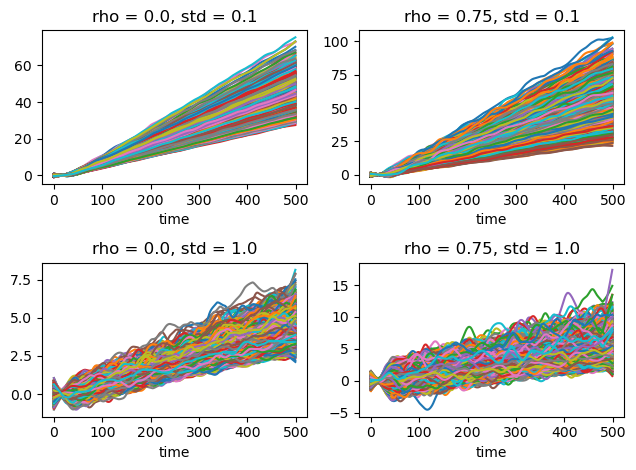

In [53]:
fig, axes = plt.subplots(2, 2)
axes = axes.ravel()

sn_bs_xr.sel(std=0.1, rho=0).plot(ax=axes[0], hue='iteration', add_legend=False);
sn_bs_xr.sel(std=0.1, rho=0.75).plot(ax=axes[1], hue='iteration', add_legend=False);
sn_bs_xr.sel(std=1, rho=0).plot(ax=axes[2], hue='iteration', add_legend=False);
sn_bs_xr.sel(std=1, rho=0.75).plot(ax=axes[3], hue='iteration', add_legend=False);

plt.tight_layout()

<h1 style='color:cyan'> Saving and Opening Data </h1>

In [27]:
# sn_bs_xr.to_zarr(os.path.join(SAVE_DIR, 'sn_rho_std.zarr'), mode='w')
# ks_ds.to_zarr(os.path.join(SAVE_DIR, 'ks_rho_std.zarr'), mode='w')
# fga_ds.to_zarr(os.path.join(SAVE_DIR, 'fga_rho_std.zarr'), mode='w')

In [28]:
chunks = {'time':-1, 'iteration':200, 'rho':1, 'std':1}

In [29]:
# trend_bs_xr.to_zarr(os.path.join(SAVE_DIR, 'trend_rho_std.zarr'), mode='w')
trend_bs_xr = xr.open_dataset(os.path.join(SAVE_DIR, 'trend_rho_std.zarr'), engine='zarr', 
                             ).chunk(chunks).persist()
wait(trend_bs_xr);

In [30]:
trend_bs_xr = trend_bs_xr.to_array().squeeze().drop_vars('variable')
trend_bs_xr.name = 'data'

In [31]:
trend_bs_xr

<xarray.DataArray 'data' (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 200, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [32]:
sn_bs_xr = (xr.open_zarr(os.path.join(SAVE_DIR, 'sn_rho_std.zarr'))
            .chunk(**chunks)
            .to_array()
            .squeeze().drop_vars('variable')
            )
sn_bs_xr.name = 'sn_lowess_base'
ks_ds = xr.open_zarr(os.path.join(SAVE_DIR, 'ks_rho_std.zarr')).ks.chunk(**chunks)
fga_ds = xr.open_zarr(os.path.join(SAVE_DIR, 'fga_rho_std.zarr')).frac.chunk(**chunks)

In [33]:
wait(sn_bs_xr);
wait(ks_ds);
wait(fga_ds);

In [34]:
ks_ds

<xarray.DataArray 'ks' (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 200, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [35]:
sn_bs_xr

<xarray.DataArray 'sn_lowess_base' (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 200, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [36]:
trend_bs_xr

<xarray.DataArray 'data' (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 200, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

<h1 style='color:cyan'> Calculations </h1>



<h2 style='color:yellow'> Rho and Std </h2>

<h3 style='color:green'> ToE </h3>

In [37]:
sn_toe_bs_xr = toe_calc.get_permanent_exceedance(
            sn_bs_xr, threshold=1, comparison_func=np.greater,
    time=sn_bs_xr.time.values)

In [38]:
ks_toe_bs_xr = toe_calc.get_permanent_exceedance(
            ks_ds, threshold=0.01, comparison_func=np.less, time=sn_bs_xr.time.values)

In [39]:
fga_toe_bs_xr = toe_calc.get_permanent_exceedance(
            fga_ds, threshold=62, comparison_func=np.less, time=sn_bs_xr.time.values)

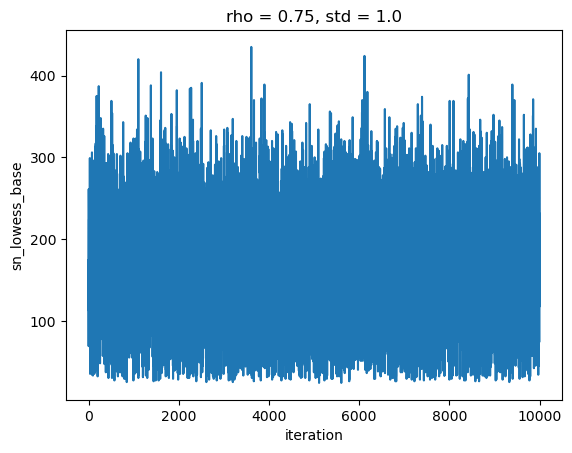

In [40]:
sn_toe_bs_xr.sel(std=1, rho=0.75).plot()

In [41]:
%%time
sn_toe_bs_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    sn_toe_bs_xr,
    dask_gufunc_kwargs={'allow_rechunk':True},
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 3.21 s, sys: 399 ms, total: 3.61 s
Wall time: 5.63 s


In [42]:
%%time
ks_toe_bs_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    ks_toe_bs_xr,
    dask_gufunc_kwargs={'allow_rechunk':True},
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 5.7 s, sys: 378 ms, total: 6.08 s
Wall time: 8.02 s


In [43]:
%%time
fga_toe_bs_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    fga_toe_bs_xr,
    dask_gufunc_kwargs={'allow_rechunk':True},
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 6.8 s, sys: 561 ms, total: 7.36 s
Wall time: 9.57 s


In [44]:
ks_toe_bs_kde_xr['x'] = x
sn_toe_bs_kde_xr['x'] = x
fga_toe_bs_kde_xr['x'] = x

In [45]:
sn_toe_bs_xr = sn_toe_bs_xr.compute()
ks_toe_bs_xr = ks_toe_bs_xr.compute()
fga_toe_bs_xr = fga_toe_bs_xr.compute()

<h2 style='color:yellow'> Non-stationary Variance </h2>

This is different as the noise now changes from one to the other by the point that emergence occurs

<h3 style='color:green'> Genearting Data </h3> 

In [46]:
from itertools import combinations

In [47]:
non_stat_noise_kwargs = dict(
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    vectorize=True,
    dask = 'parallelized',
    output_dtypes=[float]
)

In [48]:
def apply_variance_time_change(
    arr, window_size=10, start_std=1.0, end_std=2.0, base_period_length=False,
    logginglevel='ERROR'
):
    """
    Scale the standard deviation of each window in the array, increasing
    linearly from start_std to end_std. Optionally leave a base period unchanged.

    Parameters:
    - arr: 1D array-like
    - window_size: number of elements per window (after the base period)
    - start_std: target std for the first modified window
    - end_std: target std for the last modified window
    - base_period: if True, the first 30 elements are untouched

    Returns:
    - A new array with increasing standard deviation in windows
    """
    utils.change_logginglevel(logginglevel)

    arr = np.asarray(arr)
    result = np.empty_like(arr)


    if base_period_length:
        args = np.concatenate([
            [0, base_period_length],
            np.arange(base_period_length+window_size, len(arr)+window_size, window_size)
        ])
    else:
        args = np.arange(0, len(arr), window_size)

    logger.info(args)

    segments = [arr[args[i]:args[i+1]] for i in range(len(args)-1)]

    # The segment si too small, merge with the previous segment
    if len(segments[-1]) < window_size:
        segments[-2] = [*segments[-2], *segments[-1]]
        segments = segments[:-1]
    
    target_stds = np.linspace(start_std, end_std, len(segments))

    scaled_segments= np.concatenate(
        [rescale_noise(segments[i], target_stds[i]) for i in range(len(segments))]
    )

    return scaled_segments

In [49]:
# def apply_variance_time_change_xr(
#     da, start_std, end_std,
#     change_var_length=None, base_period_length=30, window_size=30, total_length=None,
#     logginglevel='ERROR'
# ):
#     """
#     Applies non-stationary noise to a DataArray, transitioning between two standard deviation values over time.
    
#     Parameters
#     ----------
#     da : xr.DataArray
#         The input data array to which noise will be added.
#     start_std : float
#         The initial standard deviation of the noise.
#     end_std : float
#         The final standard deviation of the noise.
#     length : int, optional
#         The number of time steps over which the standard deviation transitions from start_std to end_std.
#         After this, the noise is rescaled to maintain end_std.
#     window : int, default=30
#         The moving window size used to compute local standard deviation during noise scaling.
    
#     Returns
#     -------
#     xr.DataArray
#         A DataArray with noise applied, transitioning from start_std to end_std over the specified length.
#     """

#     utils.change_logginglevel(logginglevel)
#     logger.debug(locals())
#     logger.debug('\n')
    
#     da_new = xr.apply_ufunc(
#         apply_variance_time_change, 
#         da.isel(time=slice(0, base_period_length+change_var_length)),
#         kwargs = dict(
#             start_std=start_std, end_std=end_std, window_size=window_size,
#             base_period_length=base_period_length),
#         **non_stat_noise_kwargs
#     ).persist()
    
#     wait(da_new);
    
#     logger.debug(da_new)
#     logger.debug('\n')

#     if total_length:
#         time_length = da_new.time.shape[0]
#         logger.info(f'{time_length=}')
#         logger.debug('\n')

#         da_end = da.isel(time=slice(time_length, total_length))

#         logger.debug(da_end)
#         logger.info('\n')
        
#         da_end_rescale = xr.apply_ufunc(
#                 rescale_noise, 
#                 da_end,
#                 kwargs = dict(target_std=end_std),
#                 **non_stat_noise_kwargs
#             ).persist()

#         logger.debug(da_end_rescale)
#         logger.debug('\n')

#         da_new = xr.concat([da_new, da_end_rescale], dim='time')

#     return da_new

In [82]:
non_stat_noise_kwargs_v2 = dict(
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    vectorize=True,
    dask = 'allowed',
    output_dtypes=[float]
)

In [83]:
def apply_variance_time_change_xr(
    da, start_std, end_std,
    change_var_length=None, base_period_length=30, window_size=30, total_length=None,
    logginglevel='ERROR'
):
    """
    Applies non-stationary noise to a DataArray, transitioning between two standard deviation values over time.
    
    Parameters
    ----------
    da : xr.DataArray
        The input data array to which noise will be added.
    start_std : float
        The initial standard deviation of the noise.
    end_std : float
        The final standard deviation of the noise.
    change_var_length : int, optional
        The number of time steps over which the standard deviation transitions from start_std to end_std.
        If None, must specify total_length.
    base_period_length : int, default=30
        The length of the base period before variance change begins.
    window_size : int, default=30
        The moving window size used to compute local standard deviation during noise scaling.
    total_length : int, optional
        Total length of the output time series. If provided, extends beyond change_var_length
        with noise rescaled to maintain end_std.
    logginglevel : str, default='ERROR'
        Logging level for the function.
    
    Returns
    -------
    xr.DataArray
        A DataArray with noise applied, transitioning from start_std to end_std.
    """
    utils.change_logginglevel(logginglevel)
    logger.debug(locals())
    logger.debug('\n')
    
    # Validate inputs
    if change_var_length is None and total_length is None:
        raise ValueError("Either change_var_length or total_length must be specified")
    
    if change_var_length is None:
        change_var_length = total_length - base_period_length
    
    transition_end = base_period_length + change_var_length
    
    if transition_end > len(da.time):
        raise ValueError(f"Requested time length ({transition_end}) exceeds input data length ({len(da.time)})")
    
    # Apply variance transition

    logger.debug(f'da\n{da}')
    logger.debug(f'non_stat_noise_kwargs_v2\n{non_stat_noise_kwargs_v2}')
    
    da_new = xr.apply_ufunc(
        apply_variance_time_change, 
        da.isel(time=slice(0, transition_end)),
        kwargs=dict(
            start_std=start_std, end_std=end_std, window_size=window_size,
            base_period_length=base_period_length
        ),
        **non_stat_noise_kwargs_v2
    )#.persist()
    
    wait(da_new)
    
    logger.debug(da_new)
    logger.debug('\n')
    
    # Extend with rescaled noise if needed
    if total_length and total_length > transition_end:
        logger.info(f'time_length={transition_end}')
        logger.debug('\n')
        
        da_end = da.isel(time=slice(transition_end, total_length))
        logger.debug(da_end)
        logger.info('\n')
        logger.debug(f'non_stat_noise_kwargs_v2\n{non_stat_noise_kwargs_v2}')
        da_end_rescale = xr.apply_ufunc(
            rescale_noise, 
            da_end,
            kwargs=dict(target_std=end_std),
            # dask='allowed',
            **non_stat_noise_kwargs_v2
        )
            
        logger.debug(da_end_rescale)
        logger.debug('\n')
        
        da_new = xr.concat([da_new, da_end_rescale], dim='time')
    
    return da_new

In [84]:
lengths = sn_toe_bs_xr.sel(rho=0).median(dim='iteration').astype(int)
lengths

<xarray.DataArray 'sn_lowess_base' (std: 5)> Size: 40B
41 59 88 119 151
Coordinates:
    rho      float64 8B 0.0
  * std      (std) float64 40B 0.1 0.25 0.5 0.75 1.0

In [53]:
# Remove the trend - for some reason trend was halved at some point????
trend_bs_da = trend_bs_xr.sel(rho=0, std=0.5)
nosie_bs_da =  trend_bs_da - true_trend

In [54]:
arr = nosie_bs_da.isel(iteration=2).values

In [55]:
# arr_std_start = 0.25
# arr_std_end = 0.75
arr_std_start = 0.25
arr_std_end = 0.75

In [56]:
arr_changed = apply_variance_time_change(
    arr, base_period_length=30, window_size=30, start_std=arr_std_start, end_std=arr_std_end)

In [57]:
np.std(arr_changed[:30]), np.std(arr_changed[-30:])

(0.25, 0.7093894231197372)

In [58]:
# da_std_start = 0.5#1#0.1
# da_std_end = 1
# change_var_length = 100

In [59]:
stds =  (0.1, 0.5, 1, 1.5)
std_change_list = list(combinations(stds, 2))
std_change_list

[(0.1, 0.5), (0.1, 1), (0.1, 1.5), (0.5, 1), (0.5, 1.5), (1, 1.5)]

In [60]:
std_change = std_change_list[0]
base_period_length = 30
window_size = 10#30
total_length = 150 # total_length = length * 2
length_increase = lengths.sel(std = std_change[0]).values.item() * 2
length_decrease = lengths.sel(std = std_change[-1]).values.item() * 2

In [61]:
std_change, length_increase, length_decrease

((0.1, 0.5), 82, 176)

In [62]:
iteration_num = 8

In [63]:
arr = nosie_bs_da.isel(iteration=iteration_num)

In [64]:
arr_changed = apply_variance_time_change(
    arr.isel(time=slice(0, 112)), base_period_length=base_period_length, window_size=window_size, 
    start_std = std_change[0], end_std=std_change[-1], logginglevel='DEBUG')

20:46:05 | INFO     | __main__:apply_variance_time_change:33 - [  0  30  40  50  60  70  80  90 100 110 120]


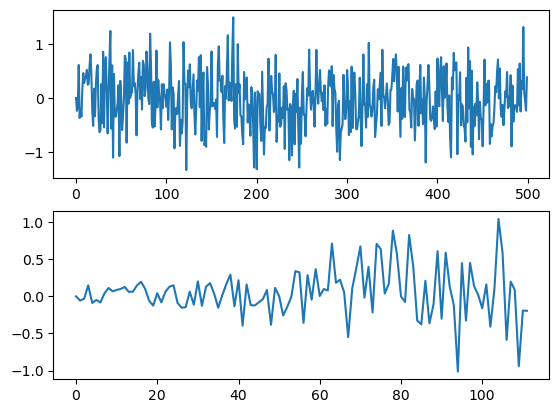

In [65]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(arr)
ax2.plot(arr_changed)

In [66]:
nosie_bs_da = nosie_bs_da.persist()#.compute()
wait(nosie_bs_da);

In [81]:
nosie_bs_da.isel(iteration=slice(0, 20))

<xarray.DataArray 'data' (iteration: 20, time: 500)> Size: 80kB
0.2936 -0.01799 -0.1007 0.5215 -0.3451 ... 0.1319 0.1122 0.06406 0.2955 -0.5024
Coordinates:
  * iteration  (iteration) int64 160B 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
    rho        float64 8B 0.0
    std        float64 8B 0.5
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [71]:
inputs = dict(
    start_std = std_change[0], end_std=std_change[-1],
    base_period_length=base_period_length, change_var_length=length_increase, 
    window_size=window_size, total_length=total_length)

In [72]:
inputs

{'start_std': 0.1,
 'end_std': 0.5,
 'base_period_length': 30,
 'change_var_length': 82,
 'window_size': 10,
 'total_length': 150}

In [85]:
da_changed = apply_variance_time_change_xr(
    nosie_bs_da,#.isel(iteration=slice(0, 20)),
    **inputs, logginglevel='DEBUG'    
)

20:51:34 | DEBUG    | __main__:apply_variance_time_change_xr:36 - {'da': <xarray.DataArray 'data' (iteration: 10000, time: 500)> Size: 40MB
dask.array<chunksize=(200, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
    rho        float64 8B 0.0
    std        float64 8B 0.5
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499, 'start_std': 0.1, 'end_std': 0.5, 'change_var_length': 82, 'base_period_length': 30, 'window_size': 10, 'total_length': 150, 'logginglevel': 'DEBUG'}
20:51:34 | DEBUG    | __main__:apply_variance_time_change_xr:37 - 

20:51:34 | DEBUG    | __main__:apply_variance_time_change_xr:53 - da
<xarray.DataArray 'data' (iteration: 10000, time: 500)> Size: 40MB
dask.array<chunksize=(200, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
    rho        float64 8B 0.0
    std        float64 8B 0.5
  * time       (time)

In [86]:
da_changed = da_changed.persist()
wait(da_changed);

In [87]:
# da_changed = da_changed.compute()

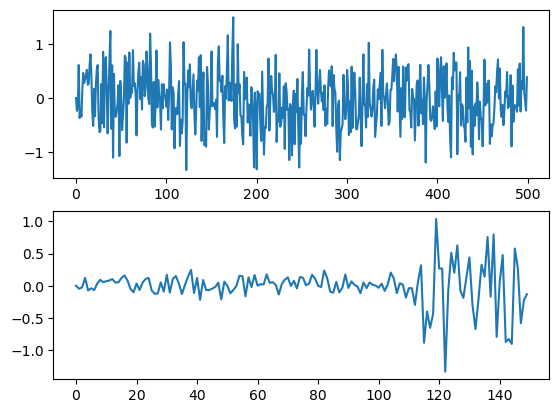

In [88]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(nosie_bs_da.isel(iteration=iteration_num).values)
ax2.plot(da_changed.isel(iteration=iteration_num).values)

In [89]:
np.testing.assert_allclose(
    da_changed.isel(time=slice(-70, None)).std(dim='time').values, std_change[-1],
    rtol=1)

In [94]:
np.testing.assert_allclose(
    da_changed.isel(time=slice(0, 30)).std(dim='time').isel(iteration=0).values, std_change[0],
    rtol=1)

In [95]:
# If the var increases
    # Roll and base are the same: Thus variability is chaning too slowly
    # The shorten length
#If the emergence decreases - 
    # They are all the same
    # This means 

end_window_size = 50
base_period_length = 30
window_size = 10
total_length = 150 # total_length = length * 2
length_increase = total_length
length_decrease = total_length

std_change_stor = []
length_dict = {}
for std_change in std_change_list:

    print(f'{std_change=}')


    length = total_length

    print(f'{length_increase=}, {length_decrease=}')
    
    base_noise_increase_xr = apply_variance_time_change_xr(
        nosie_bs_da, std_change[0], std_change[-1],
        window_size=window_size, change_var_length=length,
        base_period_length=base_period_length, total_length=total_length)
    
    base_noise_decrease_xr = apply_variance_time_change_xr(
        nosie_bs_da, std_change[-1], std_change[0],
        window_size = window_size, change_var_length=length,
        base_period_length=base_period_length, total_length=total_length)

    increase_name = str(std_change[0]).replace('.', 'p') + 't' + str(std_change[-1]).replace('.', 'p')
    decrease_name = str(std_change[-1]).replace('.', 'p') + 't' + str(std_change[0]).replace('.', 'p')
    
    base_noise_increase_xr['std'] = increase_name
    base_noise_decrease_xr['std'] = decrease_name

    
    length_dict[increase_name] = length
    length_dict[decrease_name] = length
    
    std_change_stor.append(base_noise_increase_xr)
    std_change_stor.append(base_noise_decrease_xr)

std_change=(0.1, 0.5)
length_increase=150, length_decrease=150
std_change=(0.1, 1)
length_increase=150, length_decrease=150
std_change=(0.1, 1.5)
length_increase=150, length_decrease=150
std_change=(0.5, 1)
length_increase=150, length_decrease=150
std_change=(0.5, 1.5)
length_increase=150, length_decrease=150
std_change=(1, 1.5)
length_increase=150, length_decrease=150


In [96]:
base_noise_change_xr = xr.concat(std_change_stor, dim='std')
base_noise_change_xr

<xarray.DataArray 'data' (std: 12, iteration: 10000, time: 180)> Size: 173MB
0.0578 -0.00354 -0.01983 0.1026 -0.06792 ... 0.4431 1.222 0.05477 -0.01775
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
    rho        float64 8B 0.0
  * std        (std) <U7 336B '0p1t0p5' '0p5t0p1' '0p1t1' ... '1t1p5' '1p5t1'
  * time       (time) int64 1kB 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179

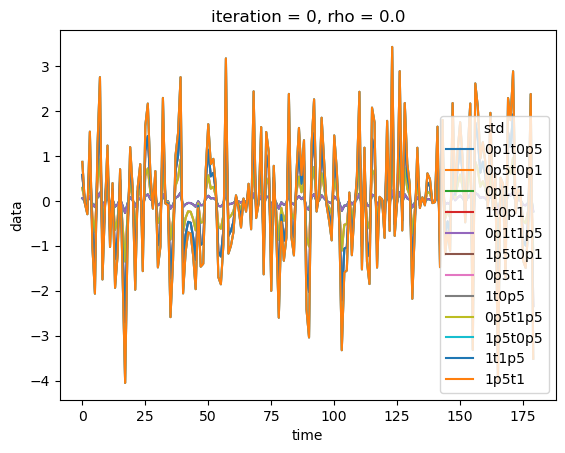

In [97]:
base_noise_change_xr.isel(iteration=0).plot(hue='std');

In [98]:
# # If the var increases
#     # Roll and base are the same: Thus variability is chaning too slowly
#     # The shorten length
# #If the emergence decreases - 
#     # They are all the same
#     # This means 

# end_window_size = 100
# base_period_length = 30
# window_size = 10
# total_length = 400 # total_length = length * 2
# length_increase = lengths.sel(std = std_change[0]).values.item() * 2
# length_decrease = lengths.sel(std = std_change[-1]).values.item() * 2

# std_change_stor = []
# length_dict = {}
# for std_change in std_change_list:

#     print(f'{std_change=}')

#     # Increasing varaiblity length should be shorter, as this occurs earlier
#     # 150 works the best

#     # The justificion for this
#     # The base period is the same - variability does not change in base period. Thus
#     # the S/N base will be the same
#     # The variance changes twice the length of the mean time for emergence to occur
#     # Thus, the old ToE will be in the middle
#     # However, this would be the case if there was not a base period. So subptract the lenght
#     # of the base period to ensure that the ToE point is in the ceter of variance change

#     # Increasing variance using the ToE of the start std
#     # Decreasing varaicne uses the ToE of the end std
#     length_increase = lengths.sel(std = std_change[0]).values.item() * 2 - base_period_length
#     length_decrease = lengths.sel(std = std_change[-1]).values.item() * 2 - base_period_length

#     length = np.max([length_increase, length_decrease])

#     print(f'{length_increase=}, {length_decrease=}')
    
#     base_noise_increase_xr = apply_variance_time_change_xr(
#         nosie_bs_da, std_change[0], std_change[-1],
#         window_size=window_size, change_var_length=length,
#         base_period_length=base_period_length, total_length=total_length)
    
#     base_noise_decrease_xr = apply_variance_time_change_xr(
#         nosie_bs_da, std_change[-1], std_change[0],
#         window_size = window_size, change_var_length=length,
#         base_period_length=base_period_length, total_length=total_length)

#     increase_name = str(std_change[0]).replace('.', 'p') + 't' + str(std_change[-1]).replace('.', 'p')
#     decrease_name = str(std_change[-1]).replace('.', 'p') + 't' + str(std_change[0]).replace('.', 'p')
    
#     base_noise_increase_xr['std'] = increase_name
#     base_noise_decrease_xr['std'] = decrease_name

    
#     length_dict[increase_name] = length
#     length_dict[decrease_name] = length
    
#     std_change_stor.append(base_noise_increase_xr)
#     std_change_stor.append(base_noise_decrease_xr)



In [99]:
length_dict

{'0p1t0p5': 150,
 '0p5t0p1': 150,
 '0p1t1': 150,
 '1t0p1': 150,
 '0p1t1p5': 150,
 '1p5t0p1': 150,
 '0p5t1': 150,
 '1t0p5': 150,
 '0p5t1p5': 150,
 '1p5t0p5': 150,
 '1t1p5': 150,
 '1p5t1': 150}

In [100]:
base_noise_change_xr = xr.concat(std_change_stor, dim='std')
base_noise_change_xr

<xarray.DataArray 'data' (std: 12, iteration: 10000, time: 180)> Size: 173MB
0.0578 -0.00354 -0.01983 0.1026 -0.06792 ... 0.4431 1.222 0.05477 -0.01775
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
    rho        float64 8B 0.0
  * std        (std) <U7 336B '0p1t0p5' '0p5t0p1' '0p1t1' ... '1t1p5' '1p5t1'
  * time       (time) int64 1kB 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179

In [101]:
base_noise_change_xr.isel(std=0).isel(iteration=0).isel(time=slice(0, 30)).std()

<xarray.DataArray 'data' ()> Size: 8B
0.09832
Coordinates:
    iteration  int64 8B 0
    rho        float64 8B 0.0
    std        <U7 28B '0p1t0p5'

In [102]:
# base_noise_change_xr = base_noise_change_xr_v2

In [103]:
# Add the true trend back, but just to where you have changed the noise
new_time_length = base_noise_change_xr.time.shape[0]
trend_noise_change_xr  = base_noise_change_xr + 2*true_trend[:new_time_length]
new_time_length

180

In [104]:
trend_noise_change_xr = trend_noise_change_xr.isel(iteration=slice(0, 300))

In [105]:
trend_noise_change_xr = trend_noise_change_xr.chunk({'std':1, 'time':-1, 'iteration':40}).persist()
wait(trend_noise_change_xr);

In [106]:
trend_noise_change_xr

<xarray.DataArray 'data' (std: 12, iteration: 300, time: 180)> Size: 5MB
dask.array<chunksize=(1, 40, 180), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 2kB 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
    rho        float64 8B 0.0
  * std        (std) <U7 336B '0p1t0p5' '0p5t0p1' '0p1t1' ... '1t1p5' '1p5t1'
  * time       (time) int64 1kB 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179

In [107]:
iteration_num = 8

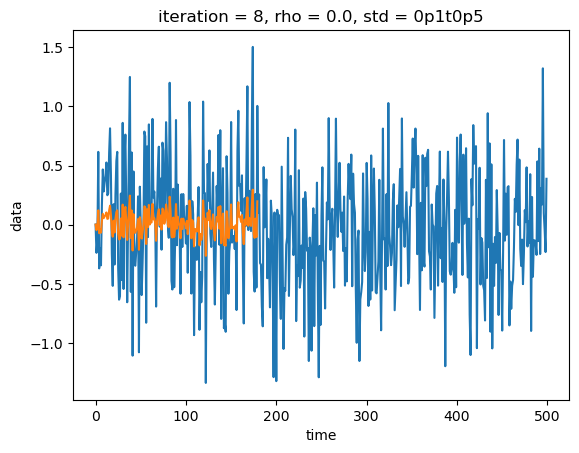

In [108]:
nosie_bs_da.isel(iteration=iteration_num).plot()
base_noise_change_xr.isel(iteration=iteration_num).isel(std=0).plot();

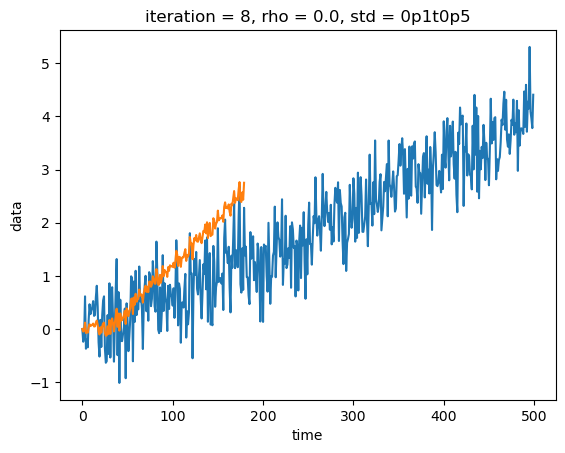

In [109]:
trend_bs_da.isel(iteration=iteration_num).plot()
trend_noise_change_xr.isel(iteration=iteration_num).isel(std=0).plot()

In [110]:
noise_values = base_noise_change_xr['std'].values
noise_values

array(['0p1t0p5', '0p5t0p1', '0p1t1', '1t0p1', '0p1t1p5', '1p5t0p1',
       '0p5t1', '1t0p5', '0p5t1p5', '1p5t0p5', '1t1p5', '1p5t1'],
      dtype='<U7')

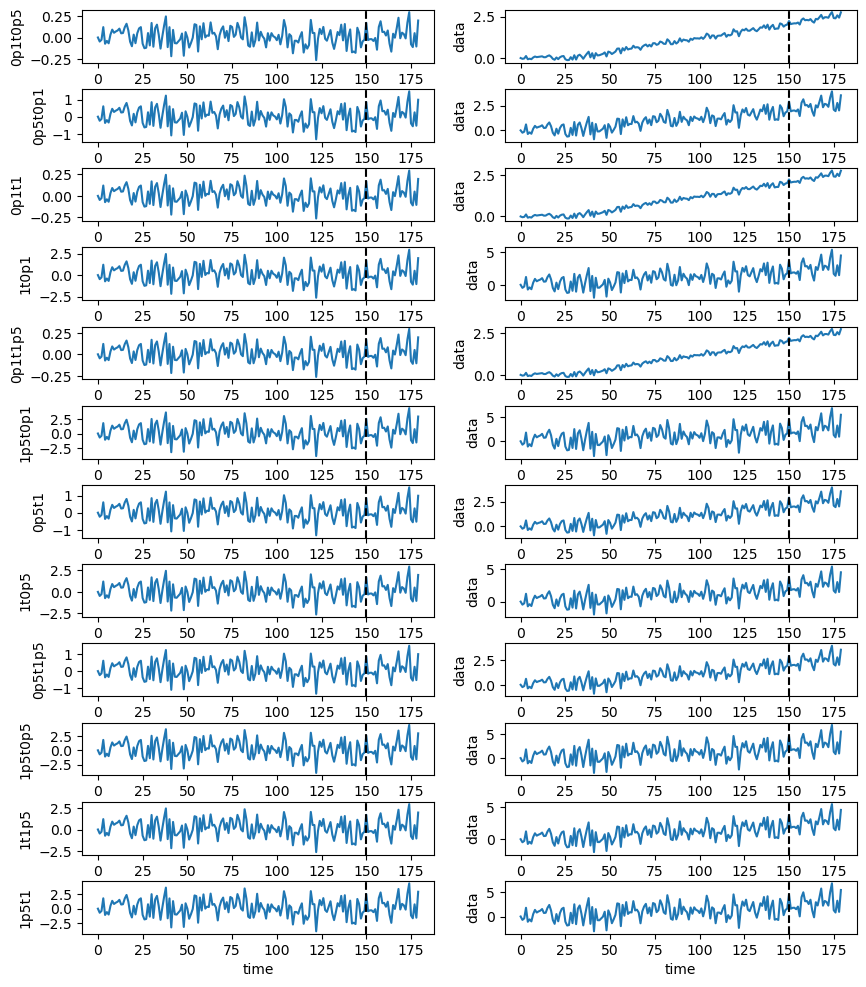

In [111]:

fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(len(noise_values), 2, hspace=0.5)
axes_left = [fig.add_subplot(gs[i, 0]) for i in range(len(noise_values))]
axes_right = [fig.add_subplot(gs[i, 1]) for i in range(len(noise_values))]

for num, noise in enumerate(noise_values):

    ax = axes_left[num]
    base_noise_change_xr.isel(iteration=iteration_num).sel(std=noise).plot(ax=ax);
    ax.axvline(length_dict[noise], linestyle='--', color='k')
    ax.set_ylabel(noise)

    ax2 =  axes_right[num]
    trend_noise_change_xr.isel(iteration=iteration_num).sel(std=noise).plot(ax=ax2);
    ax2.axvline(length_dict[noise], linestyle='--', color='k')
    ax.set_title(None)
    ax2.set_title(None)

<h3 style='color:green'> Metric Calc </h3> 

In [112]:
%%time
sn_non_stat_xr = toe_calc_variations.sn_ratio(
    trend_noise_change_xr,#.isel(iteration=slice(0,100)),
    start=0, end=30).persist()
wait(sn_non_stat_xr);

CPU times: user 3.3 s, sys: 368 ms, total: 3.67 s
Wall time: 6.02 s


In [113]:
%%time
data_ds_window_non_stat = (trend_noise_change_xr
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  # .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds_non_stat = (trend_noise_change_xr.sel(time=slice(0, base_period_length))
                         # .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )
wait(data_ds_window_non_stat);
wait(base_period_window_ds_non_stat);

CPU times: user 17 s, sys: 540 ms, total: 17.5 s
Wall time: 17.6 s


In [114]:
%%time
ks_non_stat_ds = toe_calc_variations.ks(data_ds_window_non_stat.isel(iteration=slice(0,100)),
                                        base_period_window_ds_non_stat.isel(iteration=slice(0,100)))

CPU times: user 7.23 s, sys: 494 ms, total: 7.73 s
Wall time: 9.69 s


In [115]:
fga_non_stat_ds = toe_calc_variations.fga(
    trend_noise_change_xr,#.isel(iteration=slice(0,100)),
    trend_noise_change_xr.isel(time=slice(0, base_period_length)),#.isel(iteration=slice(0,100)),
    data_ds_window_non_stat#.isel(iteration=slice(0,100))
).compute()

In [116]:
non_stat_xr = xr.merge([sn_non_stat_xr, ks_non_stat_ds, fga_non_stat_ds])

<h3 style='color:green'> ToE Calc </h3> 

In [117]:
%%time
sn_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
    non_stat_xr[['sn_lowess_base', 'sn_lowess_full', 'sn_roll']],
    threshold=1, comparison_func=np.greater,
    time=sn_non_stat_xr.time.values.astype(int), trim_nan=True).persist()
wait(sn_toe_non_stat_xr);

CPU times: user 926 ms, sys: 42.9 ms, total: 969 ms
Wall time: 962 ms


In [118]:
%%time
ks_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
            non_stat_xr.ks, threshold=0.01, comparison_func=np.less, time=ks_non_stat_ds.time.values).compute()

CPU times: user 105 ms, sys: 9.19 ms, total: 114 ms
Wall time: 112 ms


In [119]:
fga_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
            non_stat_xr.frac, threshold=62, comparison_func=np.less, time=fga_non_stat_ds.time.values).compute()

In [120]:
toe_non_stat_xr = xr.merge([sn_toe_non_stat_xr, ks_toe_non_stat_xr, fga_toe_non_stat_xr])

In [121]:
toe_non_stat_xr

<xarray.Dataset> Size: 147kB
Dimensions:         (std: 12, iteration: 300)
Coordinates:
  * iteration       (iteration) int64 2kB 0 1 2 3 4 5 ... 295 296 297 298 299
  * std             (std) <U7 336B '0p1t0p5' '0p5t0p1' ... '1t1p5' '1p5t1'
    rho             float64 8B 0.0
Data variables:
    sn_lowess_base  (std, iteration) float64 29kB 35.0 36.0 34.0 ... 105.0 105.0
    sn_lowess_full  (std, iteration) float64 29kB 35.0 35.0 33.0 ... 106.0 106.0
    sn_roll         (std, iteration) float64 29kB 34.0 36.0 34.0 ... 106.0 112.0
    ks              (std, iteration) float64 29kB 36.0 37.0 35.0 ... nan nan nan
    frac            (std, iteration) float64 29kB 36.0 37.0 35.0 ... 91.0 118.0

<h3 style='color:green'> KDE </h3> 

In [122]:
kde_create_kwargs['kwargs']['bw_method'] = 0.3

In [123]:
%%time
toe_non_stat_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    toe_non_stat_xr,
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 2.12 s, sys: 71.2 ms, total: 2.19 s
Wall time: 1.67 s


In [124]:
toe_non_stat_kde_xr['x'] = x

In [125]:
toe_non_stat_kde_xr

<xarray.Dataset> Size: 3MB
Dimensions:         (std: 12, x: 6000)
Coordinates:
  * std             (std) <U7 336B '0p1t0p5' '0p5t0p1' ... '1t1p5' '1p5t1'
    rho             float64 8B 0.0
  * x               (x) float64 48kB 0.0 0.08335 0.1667 ... 499.8 499.9 500.0
Data variables:
    sn_lowess_base  (std, x) float64 576kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    sn_lowess_full  (std, x) float64 576kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    sn_roll         (std, x) float64 576kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ks              (std, x) float64 576kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    frac            (std, x) float64 576kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [126]:
# %%time
# sn_toe_non_stat_kde_xr = xr.apply_ufunc(
#     toe_calc.create_kde_x_exists,
#     sn_toe_non_stat_xr,
#     **kde_create_kwargs
# ).compute();

In [127]:
# %%time
# ks_toe_non_stat_kde_xr = xr.apply_ufunc(
#     toe_calc.create_kde_x_exists,
#     ks_toe_non_stat_xr,
#     **kde_create_kwargs
# ).compute();

In [128]:
# %%time   
# fga_toe_non_stat_kde_xr = xr.apply_ufunc(
#     toe_calc.create_kde_x_exists,
#     fga_toe_non_stat_xr,
#     **kde_create_kwargs
# ).compute();

In [129]:
# ks_toe_non_stat_kde_xr['x'] = x
# sn_toe_non_stat_kde_xr['x'] = x
# fga_toe_non_stat_kde_xr['x'] = x
# sn_toe_non_stat_kde_xr['x'] = x

<h3 style='color:green'> KS: Multi-window </h3> 

In [130]:
trend_bs_xr

<xarray.DataArray 'data' (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 200, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [131]:
trend_noise_change_less_iterations_xr = trend_noise_change_xr.isel(iteration=slice(0,600)).persist()

In [132]:
trend_bs_less_iterations_xr = (trend_bs_xr
                               .isel(iteration=slice(0,100))
                               .chunk({'std':1, 'rho':1, 'iteration':10}).persist())
wait(trend_bs_less_iterations_xr);

In [133]:
trend_bs_less_iterations_xr

<xarray.DataArray 'data' (std: 5, rho: 4, iteration: 100, time: 500)> Size: 8MB
dask.array<chunksize=(1, 1, 10, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [134]:
windows = [10, 15, 20, 25, 30, 35, 40, 50, 60, 80, 100, 150]
ks_window_list = []

for w in windows:
    print(f'{w}, ', end='')
    data_ds_window_non_stat = (
        trend_bs_less_iterations_xr
        .rolling(time=w, center=True, min_periods=w)
        .construct('window_dim')
        .persist()
    ) 

    base_period_window_ds_non_stat = (
        trend_bs_less_iterations_xr.sel(time=slice(0, base_period_length))
        .rename({'time':'window_dim'})
        .persist()
    )
    
    wait(data_ds_window_non_stat);
    wait(base_period_window_ds_non_stat);
    
    ks_non_stat_ds_iw = toe_calc_variations.ks(data_ds_window_non_stat, base_period_window_ds_non_stat)

    ks_non_stat_ds_iw  = ks_non_stat_ds_iw.expand_dims(window=[w])
    
    ks_window_list.append(ks_non_stat_ds_iw)

10, 15, 20, 25, 30, 35, 40, 50, 60, 80, 100, 150, 

In [135]:
# windows = [10, 15, 20, 25, 30, 35, 40, 50, 60, 80, 100, 150]
# ks_window_list = []

# for w in windows:
#     print(f'{w}, ', end='')
#     data_ds_window_non_stat = (
#         trend_noise_change_less_iterations_xr
#         .rolling(time=w, center=True, min_periods=w)
#         .construct('window_dim')
#         .persist()
#     ) 

#     base_period_window_ds_non_stat = (
#         trend_noise_change_less_iterations_xr.sel(time=slice(0, base_period_length))
#         .rename({'time':'window_dim'})
#         .persist()
#     )
    
#     wait(data_ds_window_non_stat);
#     wait(base_period_window_ds_non_stat);
    
#     ks_non_stat_ds_iw = toe_calc_variations.ks(data_ds_window_non_stat, base_period_window_ds_non_stat)

#     ks_non_stat_ds_iw  = ks_non_stat_ds_iw.expand_dims(window=[w])
    
#     ks_window_list.append(ks_non_stat_ds_iw)

In [136]:
ks_window_ds = xr.concat(ks_window_list, dim='window')

In [137]:
ks_window_ds

<xarray.DataArray 'ks' (window: 12, std: 5, rho: 4, iteration: 100, time: 500)> Size: 96MB
0.7645 0.6835 0.6203 0.5697 0.4887 ... 9.263e-28 1.29e-27 1.802e-27 2.528e-27
Coordinates:
  * window     (window) int64 96B 10 15 20 25 30 35 40 50 60 80 100 150
  * iteration  (iteration) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [138]:
%%time
toe_ks_window_ds = toe_calc.get_permanent_exceedance(
            ks_window_ds, threshold=0.01, comparison_func=np.less, time=ks_window_ds.time.values).compute()

CPU times: user 1.35 s, sys: 14.4 ms, total: 1.36 s
Wall time: 1.35 s


In [139]:
%%time
toe_kde_ks_window_ds = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    toe_ks_window_ds,
    **kde_create_kwargs
).compute();

toe_kde_ks_window_ds['x'] = x

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 3.31 s, sys: 178 ms, total: 3.49 s
Wall time: 2.66 s


<h1 style='color:cyan'> Saving Data (WIP) </h1>

In [172]:
toe_non_stat_xr.to_zarr(os.path.join(SAVE_DIR, 'toe_non_stat.zarr'), mode='w')
non_stat_xr.to_zarr(os.path.join(SAVE_DIR, 'non_stat.zarr'), mode='w')
toe_non_stat_kde_xr.to_zarr(os.path.join(SAVE_DIR, 'toe_non_stat_kde.zarr'), mode='w')
ks_window_ds.to_zarr(os.path.join(SAVE_DIR, 'ks_window.zarr'), mode='w')

In [173]:
# ks_ds.to_zarr(os.path.join(SAVE_DIR, 'ks_rho_std.zarr'), mode='w')
# fga_ds.to_zarr(os.path.join(SAVE_DIR, 'fga_rho_std.zarr'), mode='w')

<h1 style='color:cyan'> Plots </h1>

<h2 style='color:yellow'> Test Plots </h2>

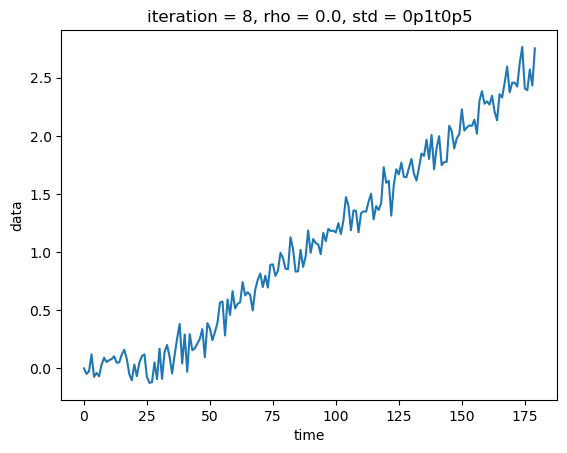

In [140]:
trend_noise_change_xr.isel(iteration=8, std=0).plot(hue='iteration', add_legend=False);

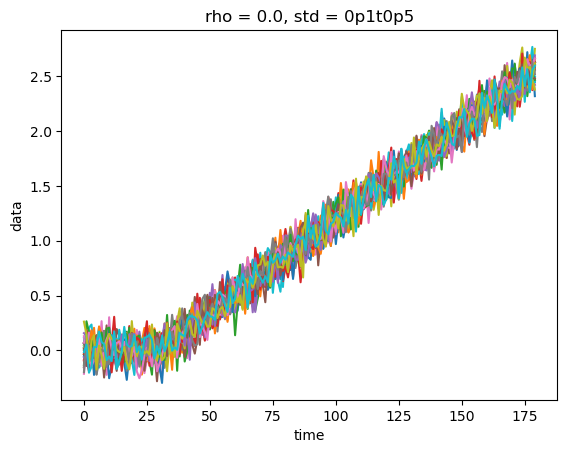

In [141]:
trend_noise_change_xr.isel(iteration=slice(0, 30), std=0).plot(hue='iteration', add_legend=False);

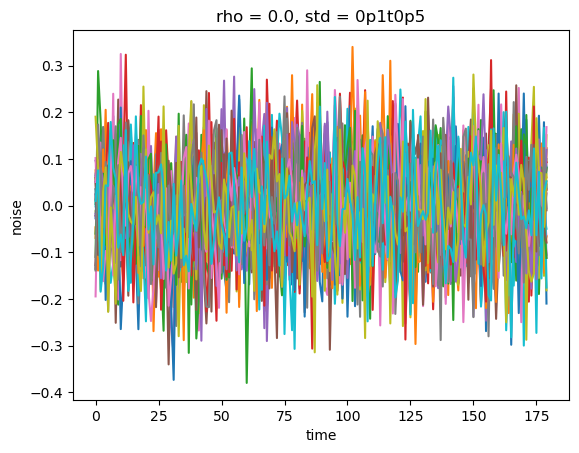

In [142]:
sn_non_stat_xr.isel(iteration=slice(0, 30), std=0).noise.plot(hue='iteration', add_legend=False);

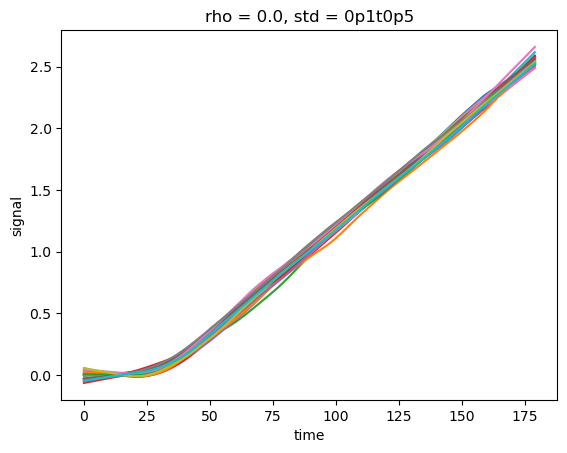

In [143]:
sn_non_stat_xr.signal.isel(iteration=slice(0, 30), std=0).plot(hue='iteration', add_legend=False);

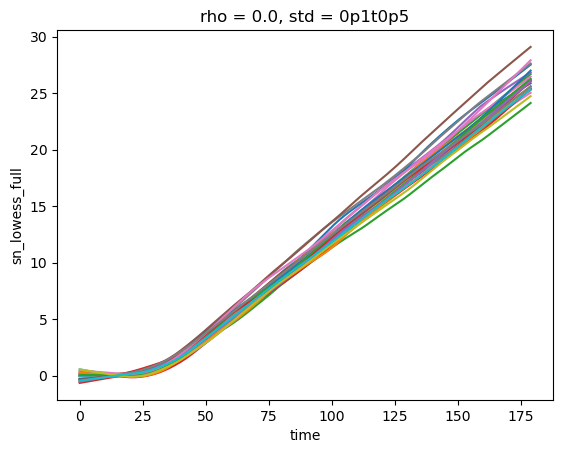

In [144]:
sn_non_stat_xr.sn_lowess_full.isel(iteration=slice(0, 30), std=0).plot(hue='iteration', add_legend=False);

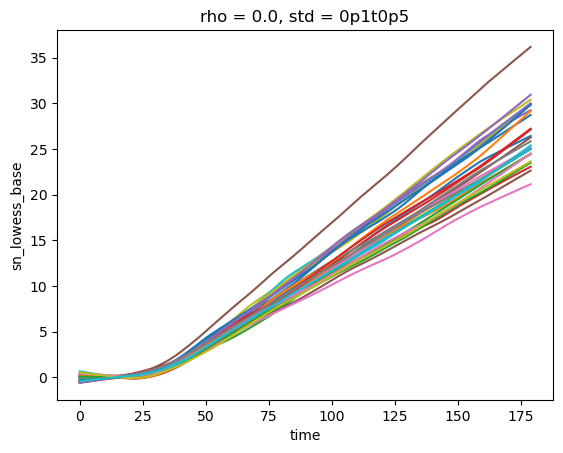

In [145]:
sn_non_stat_xr.sn_lowess_base.isel(iteration=slice(0, 30), std=0).plot(hue='iteration', add_legend=False);

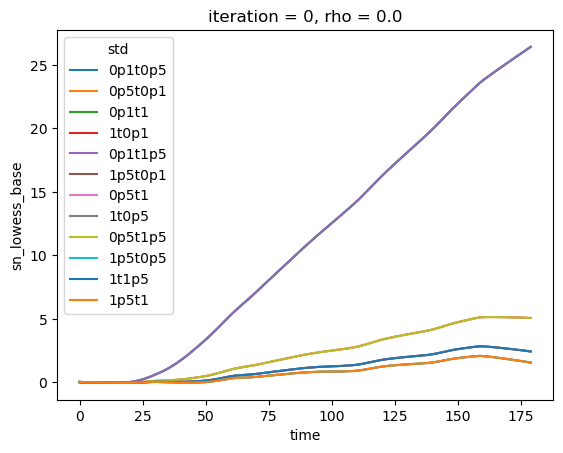

In [146]:
sn_non_stat_xr.sn_lowess_base.isel(iteration=0).plot(hue='std');

In [147]:
toe_kde_ks_window_ds

<xarray.DataArray 'ks' (window: 12, std: 5, rho: 4, x: 6000)> Size: 12MB
9.248e-133 4.163e-132 1.867e-131 8.339e-131 ... 1.628e-37 1.536e-37 1.449e-37
Coordinates:
  * window   (window) int64 96B 10 15 20 25 30 35 40 50 60 80 100 150
  * rho      (rho) float64 32B 0.0 0.25 0.5 0.75
  * std      (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * x        (x) float64 48kB 0.0 0.08335 0.1667 0.25 ... 499.8 499.9 500.0

In [148]:
toe_kde_ks_window_ds['std'].values

array([0.1 , 0.25, 0.5 , 0.75, 1.  ])

In [149]:
toe_kde_ks_window_ds

<xarray.DataArray 'ks' (window: 12, std: 5, rho: 4, x: 6000)> Size: 12MB
9.248e-133 4.163e-132 1.867e-131 8.339e-131 ... 1.628e-37 1.536e-37 1.449e-37
Coordinates:
  * window   (window) int64 96B 10 15 20 25 30 35 40 50 60 80 100 150
  * rho      (rho) float64 32B 0.0 0.25 0.5 0.75
  * std      (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * x        (x) float64 48kB 0.0 0.08335 0.1667 0.25 ... 499.8 499.9 500.0

In [150]:
# fig = plt.figure()
# ax = fig.add_subplot(111)

# for w in toe_kde_ks_window_ds.window.values:
#     toe_kde_ks_window_ds.sel(window=w, std= 0.5).plot(label=w)

# ax.legend()
# ax.set_xlim(0, 200)

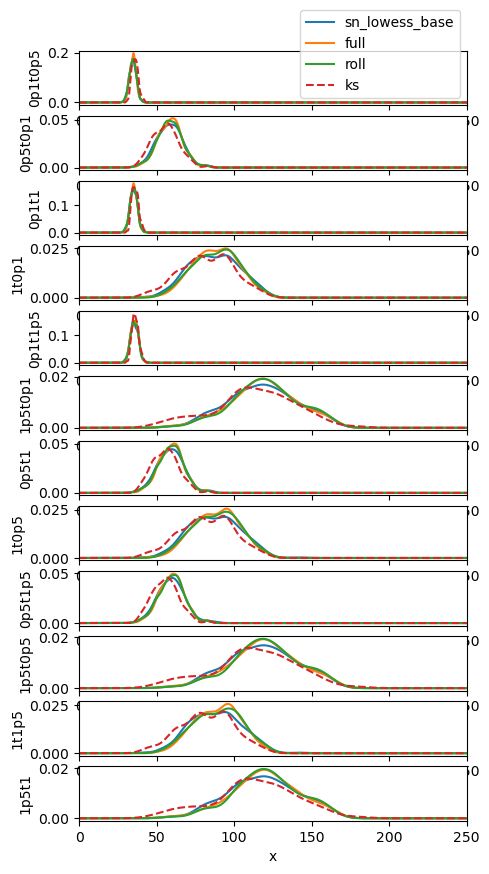

In [151]:
std_vals = toe_non_stat_kde_xr['std'].values

fig = plt.figure(figsize=(5, 10))

axes = [fig.add_subplot(len(std_vals), 1, i+1) for i in range(len(std_vals))]

for num, std in enumerate(std_vals):
    ax=axes[num]
    toe_non_stat_kde_xr.sel(std=std).sn_lowess_base.plot(ax=ax, label='sn_lowess_base')
    toe_non_stat_kde_xr.sel(std=std).sn_lowess_full.plot(ax=ax, label='full')
    toe_non_stat_kde_xr.sel(std=std).sn_roll.plot(ax=ax, label='roll')
    toe_non_stat_kde_xr.sel(std=std).ks.plot(ax=ax, label='ks', linestyle='--')
    # fga_toe_non_stat_kde_xr.sel(std=std).plot(ax=ax, label='ao', linestyle='--')
    
    ax.set_xlim(0, 250)
    ax.set_ylabel(std)
    ax.set_title(None)
    if num == 0: ax.legend()

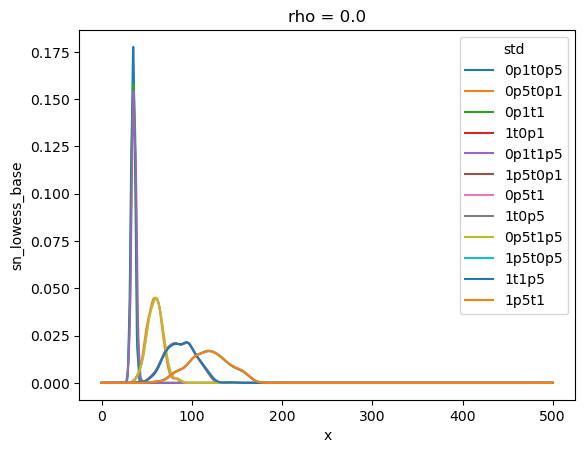

In [152]:
toe_non_stat_kde_xr.sn_lowess_base.plot(hue='std');

(0.0, 200.0)

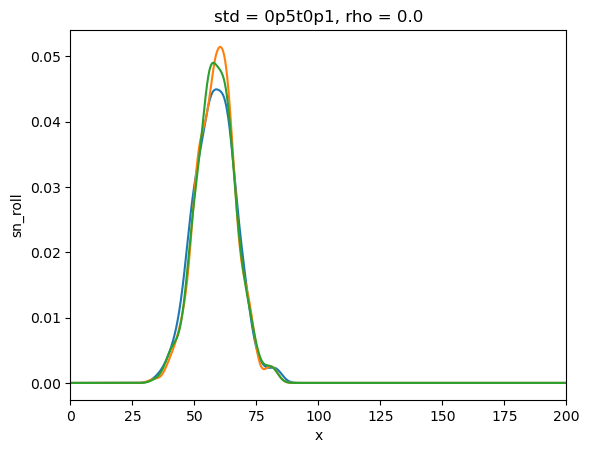

In [153]:
toe_non_stat_kde_xr.isel(std=1).sn_lowess_base.plot()
toe_non_stat_kde_xr.isel(std=1).sn_lowess_full.plot()
toe_non_stat_kde_xr.isel(std=1).sn_roll.plot()

plt.xlim(0, 200)

(0.0, 200.0)

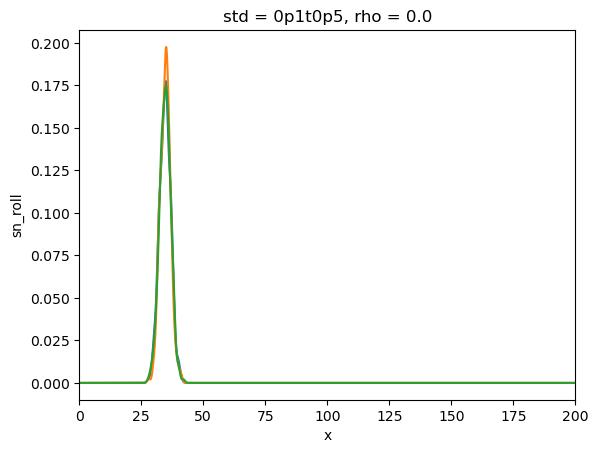

In [154]:
toe_non_stat_kde_xr.isel(std=0).sn_lowess_base.plot()
toe_non_stat_kde_xr.isel(std=0).sn_lowess_full.plot()
toe_non_stat_kde_xr.isel(std=0).sn_roll.plot()
plt.xlim(0, 200)

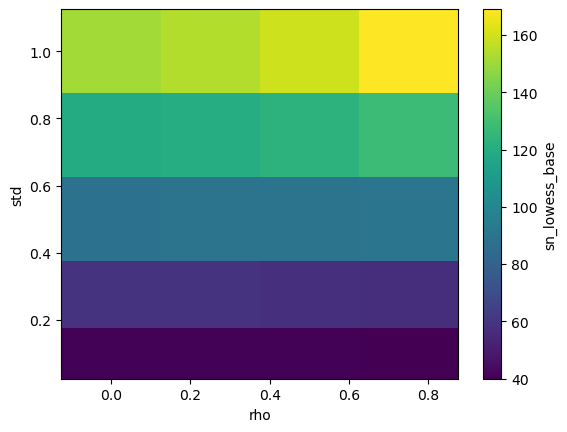

In [155]:
sn_toe_bs_xr.median(dim='iteration').plot()

In [156]:
print(sn_toe_bs_xr.std(dim='iteration').to_pandas().round(0))

rho   0.00  0.25  0.50  0.75
std                         
0.10   4.0   4.0   6.0   8.0
0.25   8.0  10.0  13.0  18.0
0.50  17.0  20.0  25.0  35.0
0.75  25.0  30.0  38.0  52.0
1.00  32.0  39.0  49.0  68.0


In [157]:
print(sn_toe_bs_xr.mean(dim='iteration').to_pandas().round(0))

rho    0.00   0.25   0.50   0.75
std                             
0.10   41.0   41.0   41.0   40.0
0.25   59.0   59.0   58.0   58.0
0.50   88.0   89.0   89.0   91.0
0.75  120.0  121.0  124.0  129.0
1.00  151.0  155.0  159.0  170.0


In [158]:
fga_toe_bs_xr.mean(dim='iteration').to_pandas().round(0)

rho    0.00   0.25   0.50   0.75
std                             
0.10   42.0   42.0   41.0   40.0
0.25   57.0   57.0   57.0   55.0
0.50   86.0   86.0   86.0   86.0
0.75  116.0  117.0  119.0  121.0
1.00  147.0  151.0  154.0  159.0

<h2 style='color:yellow'> Rho and std </h2>

In [159]:
def plot_toe_bs_kde(toe_bs_kde_xr, toe_bs_xr, colors=None, fig=None, axs=None,
                    add_legend=True, ylabel=True):
    """
    Plots Time of Emergence (ToE) bootstrapped KDE distributions for different std values, with vertical median lines.
    
    Parameters:
    - toe_bs_kde_xr: xarray.Dataset containing KDE distributions for ToE
    - toe_bs_xr: xarray.Dataset containing raw ToE values for computing medians
    - x: numpy array of x-axis values
    - fig: Optional matplotlib figure
    - axs: Optional list of matplotlib axes
    
    Returns:
    - fig, axs: Matplotlib figure and axes
    """
    # Get unique values for rho and std
    rho_values = toe_bs_kde_xr['rho'].values
    std_values = toe_bs_kde_xr['std'].values
    x = toe_bs_kde_xr.x.values
    
    # Assign a unique color to each rho for consistency across plots
    if colors is None: colors = plt.cm.viridis(np.linspace(0, 1, len(rho_values)))
    
    # Create figure and gridspec if not provided
    if fig is None or axs is None:
        fig = plt.figure(figsize=(6, len(std_values) * 1.5))
        gs = gridspec.GridSpec(len(std_values), 1, figure=fig, hspace=0)
        axs = [fig.add_subplot(gs[i, 0]) for i in range(len(std_values))]
    
    # Loop through std (rows)
    for i, (ax, std) in enumerate(zip(axs, std_values)):
        # Plot all rho values on the same subplot, using consistent colors
        for color, rho in zip(colors, rho_values):
            data = toe_bs_kde_xr.sel(std=std, rho=rho)
            ax.plot(x, data, color=color, label=f'{rho:.2f}')
            
            # Compute and plot the median vertical line
            median_x = np.nanmedian(toe_bs_xr.sel(std=std, rho=rho).values)
            median_y = data.values[np.argmin(np.abs(x - median_x))]
            ax.plot([median_x, median_x], [0, median_y], linestyle="dashed",
                    color=color, alpha=0.7)

        
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5, min_n_ticks=4, prune=None))
        ax.set_xlim(0, 350)
        if i == 0 and add_legend: 
            leg = ax.legend(loc='upper right', ncol=2, fontsize=12, frameon=False)
            leg.set_title('Lag-1 Auto-correlation')
            leg.get_title().set_fontsize(12)
        if 0 < i < len(std_values) - 1:
            # ax.spines['bottom'].set_visible(False)
            ax.set_xticklabels([])
        if i == len(std_values) - 1:
            ax.set_xlabel('Time of Emergence (ToE)') 
        if i == 0:
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('top')
        if ylabel: ax.set_ylabel(fr'$\sigma={std}$', fontsize=12)  
        ax.grid(True, linestyle='--', alpha=0.25, color='grey')
    
    return fig, axs


In [160]:
colors = plt.cm.viridis_r(np.linspace(0, 1, sn_toe_bs_kde_xr['rho'].values.shape[0]))

In [161]:
std_values = sn_toe_bs_kde_xr['std'].values

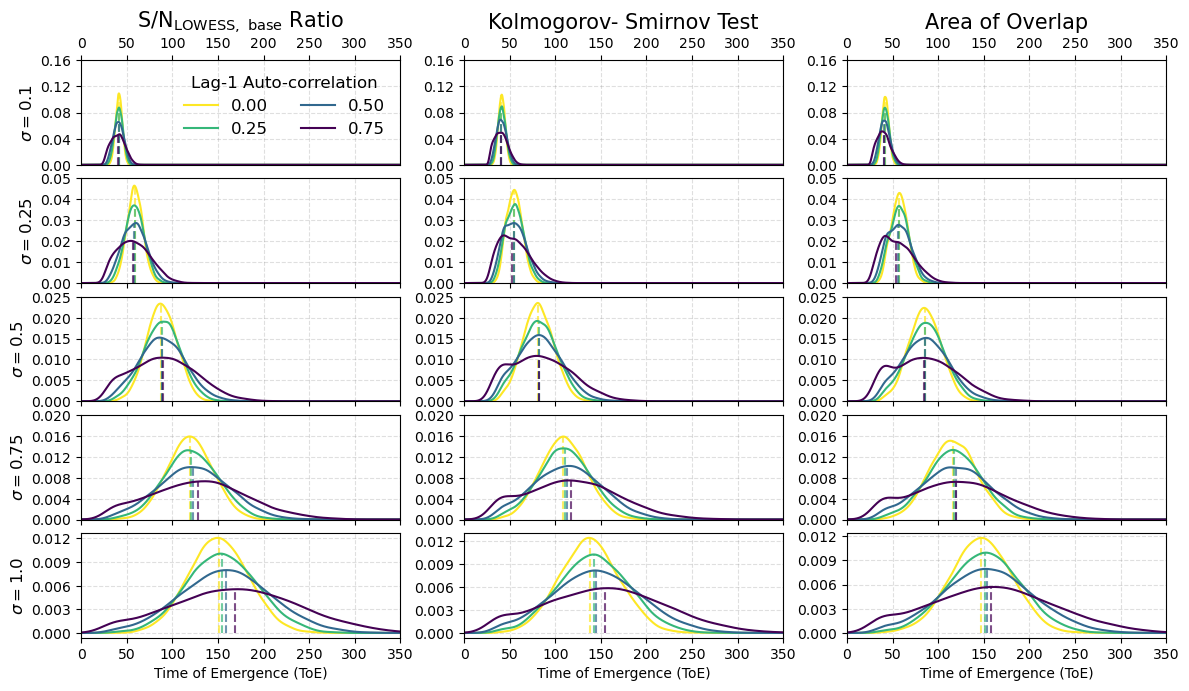

In [162]:
# Create figure and gridspec (multiple rows, 1 column)
fig = plt.figure(figsize=(14, len(std_values) * 1.5))
gs = gridspec.GridSpec(len(ks_toe_bs_kde_xr['std'].values), 3, figure=fig, hspace=0.13)
axes_left = [fig.add_subplot(gs[i, 0]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]
axes_middle = [fig.add_subplot(gs[i, 1]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]
axes_right = [fig.add_subplot(gs[i, 2]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]


plot_toe_bs_kde(sn_toe_bs_kde_xr, sn_toe_bs_xr, fig=fig, axs=axes_left, colors=colors);
plot_toe_bs_kde(ks_toe_bs_kde_xr, ks_toe_bs_xr, fig=fig, axs=axes_middle, colors=colors, ylabel=False, add_legend=False);
plot_toe_bs_kde(fga_toe_bs_kde_xr, fga_toe_bs_xr, fig=fig, axs=axes_right, colors=colors, ylabel=False, add_legend=False);


axes_left[0].set_title(METRIC_MAP['sn_lowess_base'], fontsize=15)
axes_middle[0].set_title(METRIC_MAP['ks'].replace('\n', ' '), fontsize=15)
axes_right[0].set_title(METRIC_MAP['frac'].replace('\n', ' '), fontsize=15)


for axes in [axes_left, axes_middle, axes_right]:
    for i,ax in enumerate(axes):
        if i == 0: ax.set_ylim(0, 0.16)
        if i == 1:ax.set_ylim(0, 0.05)
        if i == 2: ax.set_ylim(0, 0.025)
        if i==3: ax.set_ylim(0, 0.02)

In [163]:
sn_toe_bs_kde_xr

<xarray.DataArray 'sn_lowess_base' (std: 5, rho: 4, x: 6000)> Size: 960kB
0.0 0.0 0.0 9.881e-324 5.336e-322 ... 3.887e-11 3.775e-11 3.667e-11 3.562e-11
Coordinates:
  * rho      (rho) float64 32B 0.0 0.25 0.5 0.75
  * std      (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * x        (x) float64 48kB 0.0 0.08335 0.1667 0.25 ... 499.8 499.9 500.0

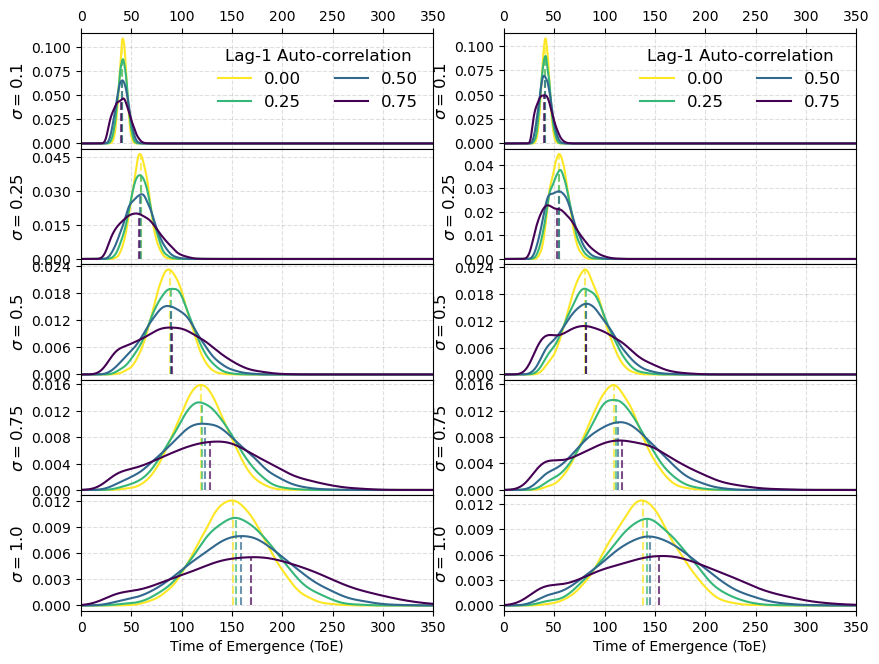

In [164]:
# Create figure and gridspec (multiple rows, 1 column)
fig = plt.figure(figsize=(10, len(std_values) * 1.5))
gs = gridspec.GridSpec(len(ks_toe_bs_kde_xr['std'].values), 2, figure=fig, hspace=0)
axes_left = [fig.add_subplot(gs[i, 0]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]
axes_right = [fig.add_subplot(gs[i, 1]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]


plot_toe_bs_kde(sn_toe_bs_kde_xr, sn_toe_bs_xr, fig=fig, axs=axes_left, colors=colors);
plot_toe_bs_kde(ks_toe_bs_kde_xr, ks_toe_bs_xr, fig=fig, axs=axes_right, colors=colors);

<h2 style='color:yellow'> Time-changing variance </h2>

In [174]:
def __format_multi_axes(axes):

    for i, ax in enumerate(axes):
        if i in [0, 3]:
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position("top")
            ax.set_xlabel("Time of Emergence (ToE)", fontsize=14)
        elif i in [2, 5]:
            ax.set_xlabel("Time of Emergence (ToE)", fontsize=14)

        if i in [1, 4]:
            ax.set_xticklabels([])
        else:
            ax.tick_params(axis='x', labelsize=12)

In [235]:
def plot_toe_bs_kde_custom(
    kde_xr, toe_xr=None,
    colors=None, fig=None, gs=None, axs=None, add_legend=True, legend_loc='upper right',
    fontscale=1, bbox_to_anchor=None, xlim=None, hspace=0.1, linewidth=1.9, logginglevel="INFO"):
    """
    Plots Time of Emergence (ToE) KDE distributions for different datasets (KS and FGA) as variables within a merged dataset,
    with distinct colors for each dataset and different std values with distinct linestyles.

    Parameters:
    - kde_xr: xarray.Dataset containing KDE distributions with 'KS' and 'FGA' as variables
    - std_values: List of std values to plot
    - colors: Optional color list for datasets
    - fig: Optional matplotlib figure
    - axs: Optional list of matplotlib axes
    
    Returns:
    - fig, axs: Matplotlib figure and axes
    """
    utils.change_logginglevel(logginglevel)
    
    x = kde_xr.x.values  # Assuming all datasets share the same x values
    std_values = kde_xr['std'].values
    toe_metrics = list(kde_xr)
    
    nrows = int(np.ceil(len(std_values)/2))
    # Create figure and gridspec if not provided
    if fig is None: fig = plt.figure(figsize=(15, 3.33*nrows))
    if gs is None: gs = gridspec.GridSpec(nrows, 2, figure=fig, hspace=hspace)

    if axs is None:
        axs = []
        for j in range(2):  # Since you have 2 columns
            for i in range(nrows):
                axs.append(fig.add_subplot(gs[i, j]))

    # ylims = []
    for i, std in enumerate(std_values):
        ax = axs[i]
        xlim_array = []
        # ylims.append(kde_xr.sel(std=std).to_array().max().values.item())
        for toe_met in toe_metrics:
            logger.debug(f'{i=}, {std=}, {toe_met=}')
            style = toe_plots.TEST_STYLES.get(toe_met, {'color':'black', 'linestyle':'solid'}, drop_keys=['marker'])
            
            data = kde_xr[toe_met].sel(std=std)
            logger.debug(f'data\n{data}')
            label= toe_plots.METRIC_MAP.get(toe_met, toe_met).replace('\n', ' ').replace(' (', '\n(')
            if 'Smirnov' in label: label = label.replace('Smirnov', '\nSmirnov')
            logger.debug(style)
            ax.plot(x, data, label=label, linewidth=linewidth*fontscale, alpha=0.75, **style)
            # median_x = np.nanmedian(toe_xr[toe_met].sel(std=std).values)
            # median_y = data.values[np.argmin(np.abs(x - median_x))]
            # ax.plot([median_x, median_x], [0, median_y], **style)


            max_non_zero =  x[np.where(data.values > 0)[-1][-1]]
            xlim_array.append(max_non_zero)
        
        if xlim: ax.set_xlim(0, xlim)
        else: ax.set_xlim(0,np.max(xlim_array))
        # xlims = (0, 100) if i%2 else (0, 120)
        # ax.set_xlim(xlims)
        # ax.set_xlim(0, 200)
        ax.grid(True, linestyle="--", alpha=0.25, color="grey")
        # ax.annotate(r'$\sigma=$' + std.replace('p', '.').replace('t', ' to '), fontsize=12*fontscale,
        #            xy=(0.02, 0.85), xycoords='axes fraction')

        # ax.set_ylabel(r'$\sigma=$' + std.replace('p', '.').replace('t', ' to '), fontsize=12*fontscale)
        ax.tick_params(axis='x', labelsize=10*fontscale)
        ax.tick_params(axis='y', labelsize=10*fontscale)
        # ax.set_ylim(-0.01, 1.2* kde_xr.sel(std=std_order).to_array().max().values.item())#0.17)

    [ax.set_ylim(-0.001, 1.2 * ax.get_ylim()[1]) for ax in axs]
    # for i in range(nrows):
    #     ylim = np.max([ylims[i], ylims[i+nrows]])
    #     axs[i].set_ylim(-0.01, ylim); axs[i+nrows].set_ylim(-0.01, ylim)
    
    if add_legend:
        legend = axs[0].legend(ncol=1, loc=legend_loc, fontsize=9*fontscale, bbox_to_anchor=bbox_to_anchor)

    return fig, axs

In [192]:
non_stat_tests = list(toe_non_stat_kde_xr)
non_stat_tests

['sn_lowess_base', 'sn_lowess_full', 'sn_roll', 'ks', 'frac']

In [193]:
std_order = list(toe_non_stat_kde_xr['std'].values)
std_order = np.array([*std_order[::2], *std_order[1::2]])
std_order

array(['0p1t0p5', '0p1t1', '0p1t1p5', '0p5t1', '0p5t1p5', '1t1p5',
       '0p5t0p1', '1t0p1', '1p5t0p1', '1t0p5', '1p5t0p5', '1p5t1'],
      dtype='<U7')

In [178]:
# std_order = list(toe_non_stat_kde_xr['std'].values)
# ['0p1t0p5', '0p5t1p0', '0p1t1p0', '0p5t0p1', '1p0t0p5', '1p0t0p1',
             # '1p5t0p5','0p5t1p5','3p0t1p0','1p0t3p0'
            # ]

In [179]:
# good_indices = [3,4,5, 8, 9, 10, 13, 14]

In [180]:
# increasing_std = std_order[:len(std_order)//2]
# decreasing_std = std_order[len(std_order)//2:]

In [181]:
# good_std = np.asarray([*decreasing_std[good_indices], *increasing_std[good_indices]])
# small_subset = ['0p1t1p0', '0p1t1p5','0p25t1p5',
#                 '1p0t0p1', '1p5t0p1','1p5t0p25']

In [182]:
sn_toe_bs_xr.sel(rho=0).median(dim='iteration').to_pandas()

std
0.10     41.0
0.25     59.0
0.50     88.0
0.75    119.0
1.00    151.0
Name: sn_lowess_base, dtype: float64

In [183]:
toe_non_stat_xr.sn_lowess_base.median(dim='iteration')

<xarray.DataArray 'sn_lowess_base' (std: 12)> Size: 96B
35.0 58.0 35.0 86.5 35.0 118.0 59.0 87.0 59.5 118.0 88.0 118.0
Coordinates:
  * std      (std) <U7 336B '0p1t0p5' '0p5t0p1' '0p1t1' ... '1t1p5' '1p5t1'
    rho      float64 8B 0.0

Text(0.5, 1.0, 'Increasing Variability over Time')

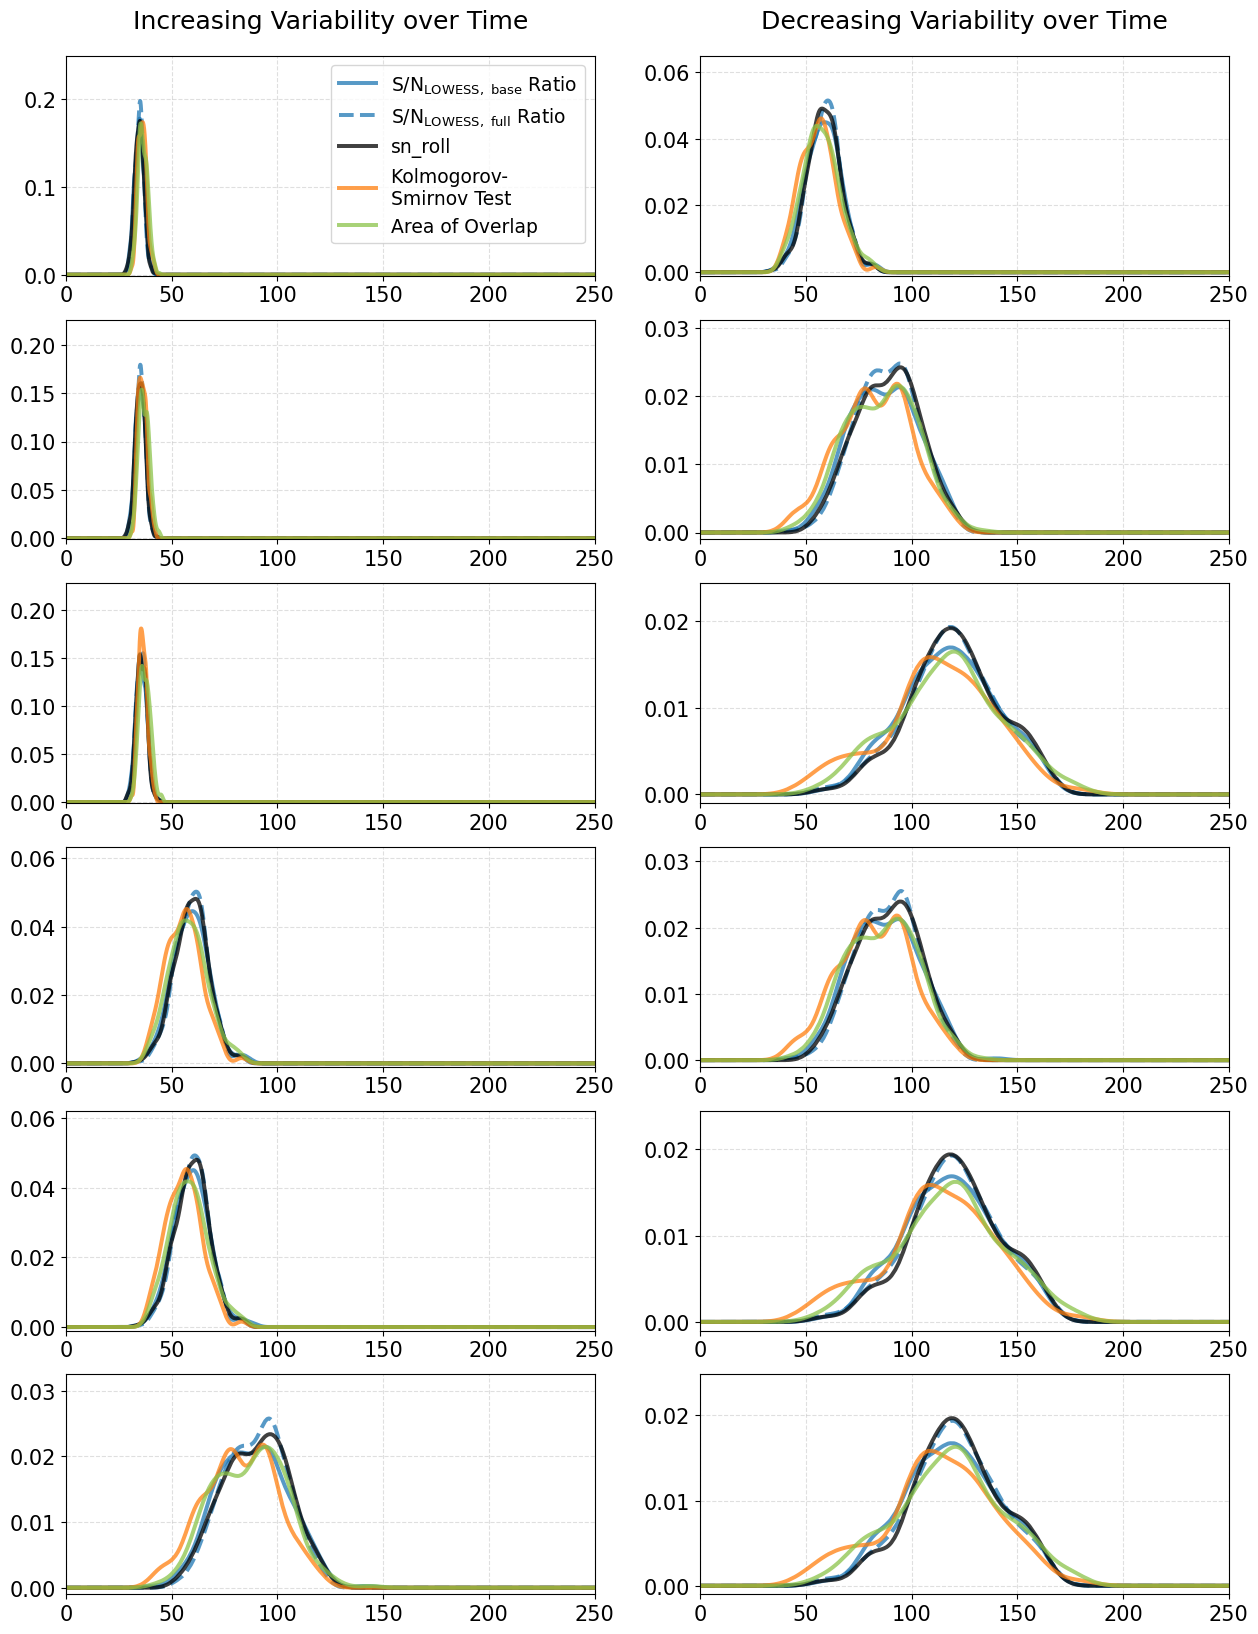

In [236]:
fontscale = 1.5

fig, axs = plot_toe_bs_kde_custom(toe_non_stat_kde_xr.sel(std=std_order).round(5), toe_non_stat_xr,
                                 fontscale=fontscale, xlim=250, hspace=0.2, linewidth=1.9,
                                 logginglevel='INFO')#, bbox_to_anchor=(2.15, 1.3))

axs[len(axs)//2].set_title('Decreasing Variability over Time', fontsize=12*fontscale, pad=20)
axs[0].set_title('Increasing Variability over Time', fontsize=12*fontscale, pad=20)
# __format_multi_axes(axs)

In [180]:
std_dict = {}
for val in std_order:
    prefix = val.split('t')[0]
    std_dict.setdefault(prefix, []).append(val)

In [181]:
std_dict

{'0p1': ['0p1t0p5', '0p1t1', '0p1t1p5'],
 '0p5': ['0p5t1', '0p5t1p5', '0p5t0p1'],
 '1': ['1t1p5', '1t0p1', '1t0p5'],
 '1p5': ['1p5t0p1', '1p5t0p5', '1p5t1']}

In [182]:
std_items = std_dict['0p5']

In [183]:
std_items

['0p5t1', '0p5t1p5', '0p5t0p1']

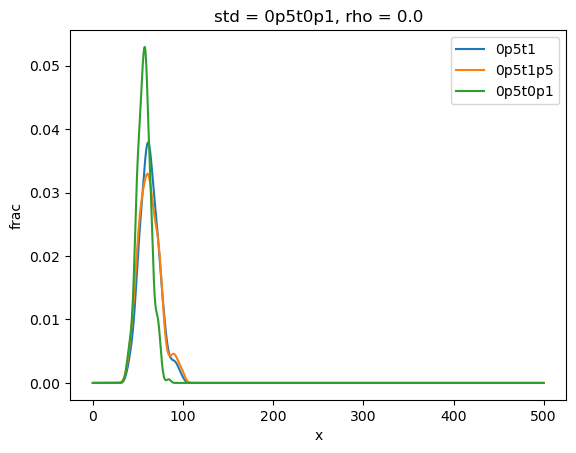

In [184]:
fig = plt.figure()
ax = fig.add_subplot(111)

for std in std_items:
    toe_non_stat_kde_xr.sel(std=std).frac.plot(ax=ax, label=std)

ax.legend()

<h2 style='color:yellow'> Combining </h2>

<h3 style='color:green'> Line series - main figure </h3> 

In [242]:
from scipy.stats import gaussian_kde
import operator

In [186]:
non_stat_xr

<xarray.Dataset> Size: 36MB
Dimensions:         (iteration: 300, std: 12, time: 180)
Coordinates:
  * iteration       (iteration) int64 2kB 0 1 2 3 4 5 ... 295 296 297 298 299
  * std             (std) <U7 336B '0p1t0p5' '0p5t0p1' ... '1t1p5' '1p5t1'
  * time            (time) int64 1kB 0 1 2 3 4 5 6 ... 174 175 176 177 178 179
    rho             float64 8B 0.0
Data variables:
    sn_lowess_base  (std, iteration, time) float64 5MB 0.03648 0.02452 ... 1.711
    sn_lowess_full  (std, iteration, time) float64 5MB 0.01136 ... 1.939
    sn_roll         (std, iteration, time) float64 5MB nan nan nan ... nan nan
    noise           (std, iteration, time) float64 5MB 0.06268 ... -0.04258
    signal          (std, iteration, time) float64 5MB 0.003561 ... 2.54
    ks              (std, iteration, time) float64 5MB 1.0 1.0 1.0 ... nan nan
    frac            (std, iteration, time) float64 5MB 85.1 88.43 ... 21.47 22.1

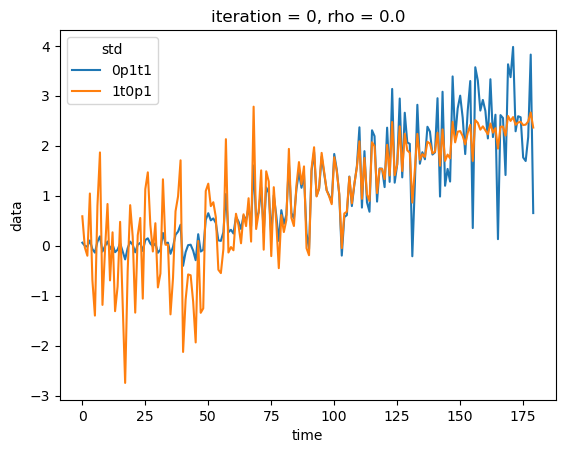

In [187]:
trend_noise_change_xr.sel(std=['0p1t1', '1t0p1']).isel(iteration=0).plot(hue='std')

In [188]:
def style_ax(ax, title=None, ylabel=None, ylim=None):
    # Grid
    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Labels
    ax.set_xlabel('Year', fontsize=14)
    if ylabel: ax.set_ylabel(ylabel, fontsize=14, rotation=90, labelpad=10)
    
    # Ticks
    ax.tick_params(labelsize=12, direction='out', length=6, width=1, colors='black')
    
    # Spines
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_linewidth(1.2)
    # ax.spines['bottom'].set_linewidth(1.2)
    
    if title is not None: ax.set_title(title, fontsize=16, weight='bold', loc='center')
    
    ax.axhline(0, color='k', alpha=0.6, zorder=-100)
    if ylim is not None: ax.set_ylim(*ylim)
    
    return ax

In [189]:
import plotting_utils

In [190]:
list(trend_noise_change_xr['std'].values)

['0p1t0p5',
 '0p5t0p1',
 '0p1t1',
 '1t0p1',
 '0p1t1p5',
 '1p5t0p1',
 '0p5t1',
 '1t0p5',
 '0p5t1p5',
 '1p5t0p5',
 '1t1p5',
 '1p5t1']

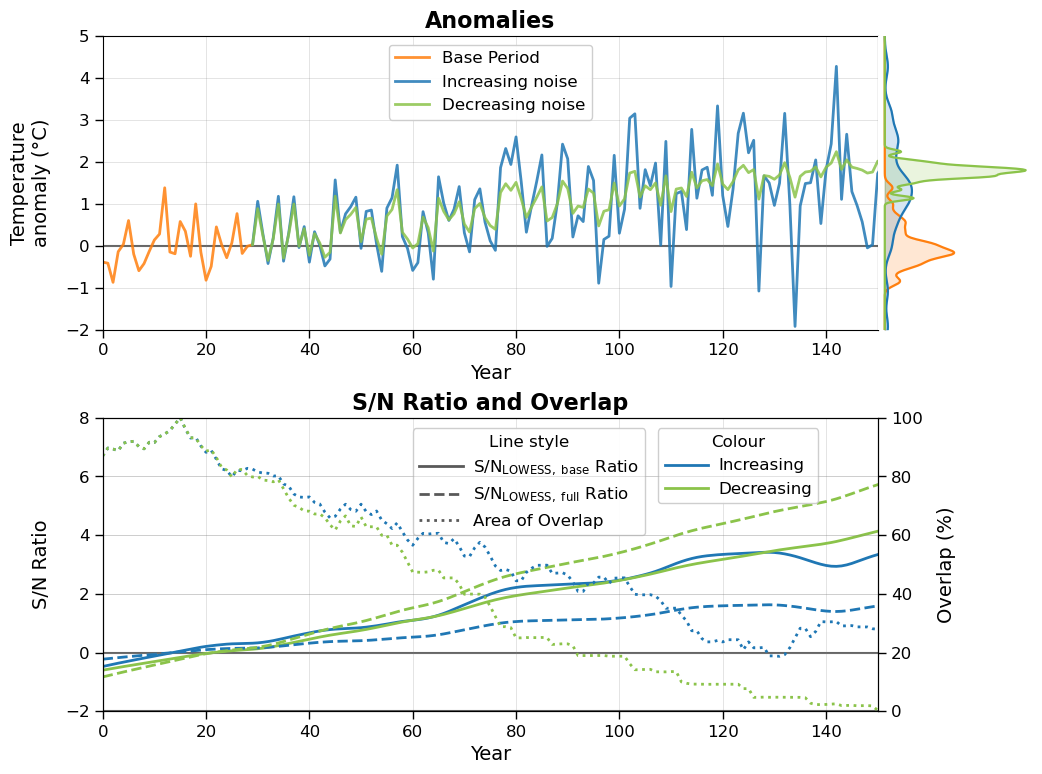

In [191]:
# --------------------------
# CONFIG
# --------------------------
year_slices = [
    (0, 30),
    # (1935, 1965),
    (120, 150)
]
bw = 0.2

# --------------------------
# LAYOUT: 2 rows × 2 cols
# row 0: inc (left main, right KDE)
# row 1: MIDDLE metrics axis (between inc & dec) — left only
# --------------------------
fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(
    2, 2, figure=fig,
    height_ratios=[1, 1],
    width_ratios=[5, 1],
    hspace=0.30, wspace=0.00
)

ax_inc      = fig.add_subplot(gs[0, 0])
ax_inc_kde  = fig.add_subplot(gs[0, 1])
ax_mid      = fig.add_subplot(gs[1, 0])   # shared metrics axis (middle)
ax_mid_gap  = fig.add_subplot(gs[1, 1])   # placeholder to keep grid tidy; hidden
ax_dec      = ax_inc                       # (intentional alias)
ax_dec_kde  = ax_inc_kde                   # (intentional alias)

# Hide the middle-right placeholder
ax_mid_gap.axis('off')

# --------------------------
# DATA
# --------------------------
std_cases = ['0p5t1p5', '0p5t0p1']

iteration_num = 3
inc_da     = trend_noise_change_xr.sel(std=std_cases[0]).isel(iteration=iteration_num)
dec_da     = trend_noise_change_xr.sel(std=std_cases[1]).isel(iteration=iteration_num)
inc_met_da = non_stat_xr.sel(std=std_cases[0]).isel(iteration=iteration_num)
dec_met_da = non_stat_xr.sel(std=std_cases[1]).isel(iteration=iteration_num)

time = trend_noise_change_xr.time.values

# --------------------------
# HELPERS
# --------------------------
def _plot_kde_strip(ax_main, ax_kde, da, tslice, color, bw_method):
    # Match main-panel y-lims
    y0, y1 = ax_main.get_ylim()
    ax_kde.set_ylim(y0, y1)

    yy = np.linspace(y0, y1, 400)
    s, e = tslice
    vals = da.isel(time=slice(s, e)).values
    vals = vals[~np.isnan(vals)]
            
    kde = gaussian_kde(vals, bw_method=bw_method)
    dens = kde(yy)
    ax_kde.plot(dens, yy, lw=1.6, color=color, zorder=3)
    ax_kde.fill_betweenx(yy, 0, dens, alpha=0.18, color=color, zorder=2)

# --------------------------
# PLOTS
# --------------------------
# Top anomalies
data_style = {'linewidth': 2, 'alpha': 0.85}
ax_inc.plot(time[:30],  inc_da.values[:30],  label='Base Period',       color=toe_plots.color_list[1], **data_style)
ax_inc.plot(time[29:],  inc_da.values[29:],  label='Increasing noise',  color=toe_plots.color_list[0], **data_style)
ax_inc.plot(time[29:],  dec_da.values[29:],  label='Decreasing noise',  color=toe_plots.color_list[2], **data_style)

# Middle metrics axis: S/N (left y), FRAC (right y)
ax_mid_frac = ax_mid.twinx()
sn_metrics = ['sn_lowess_base', 'sn_lowess_full']

for metric in sn_metrics:
    linestyle = 'solid' if 'base' in metric else 'dashed'
    # inc
    ax_mid.plot(
        time, inc_met_da[metric].values, color=toe_plots.color_list[0],
        linewidth=2, linestyle=linestyle, label=f"{toe_plots.METRIC_MAP[metric]} (inc)")
    # dec
    ax_mid.plot(
        time, dec_met_da[metric].values, color=toe_plots.color_list[2], 
        linewidth=2, linestyle=linestyle, label=f"{toe_plots.METRIC_MAP[metric]} (dec)")

# FRAC (right y): inc & dec
ax_mid_frac.plot(time, inc_met_da['frac'].values, linewidth=2.0,
                 color=toe_plots.color_list[0], linestyle='dotted', label='AO (inc)')
ax_mid_frac.plot(time, dec_met_da['frac'].values, linewidth=2.0,
                 color=toe_plots.color_list[2], linestyle='dotted', label='AO (dec)')

# --------------------------
# STYLE & LIMITS
# --------------------------
# Left panel: anomalies
style_ax(ax_inc, ylabel="Temperature\nanomaly (°C)")
ax_inc.set_xlim(0, 150)
ax_inc.set_ylim(-2, 5)

# Middle metrics axis
style_ax(ax_mid, ylabel='S/N Ratio')
style_ax(ax_mid_frac, ylabel='Overlap (%)')

ax_mid.set_xlim(0, 150)
ax_mid_frac.set_xlim(0, 150)

mid_yticks = np.arange(-2, 10, 2)
mid_frac_yticks = np.arange(0, 120, 20)
ax_mid.set_yticks(mid_yticks)
ax_mid_frac.set_yticks(mid_frac_yticks)

ax_mid.set_ylim(np.take(mid_yticks, [0, -1]))
ax_mid_frac.set_ylim(np.take(mid_frac_yticks, [0, -1]))

# KDE strips: sync to anomalies y-lims (use year_slices directly)
_plot_kde_strip(ax_inc, ax_inc_kde, inc_da, year_slices[0], toe_plots.color_list[1], bw)
_plot_kde_strip(ax_inc, ax_inc_kde, inc_da, year_slices[1], toe_plots.color_list[0], bw)
_plot_kde_strip(ax_dec, ax_dec_kde, dec_da, year_slices[1], toe_plots.color_list[2], bw)

ax_inc_kde.set_xticks([]); ax_inc_kde.set_yticks([])
for side in ("top", "right", "left", "bottom"):
    ax_inc_kde.spines[side].set_visible(False)

# --------------------------
# LEGENDS
# --------------------------
ax_inc.legend(fontsize=12, framealpha=0.95, facecolor='white', loc='upper center')

from matplotlib.lines import Line2D
metric_proxies = [
    Line2D([0],[0], lw=2, ls='solid',  color='0.35', label=toe_plots.METRIC_MAP['sn_lowess_base']),
    Line2D([0],[0], lw=2, ls='dashed', color='0.35', label=toe_plots.METRIC_MAP['sn_lowess_full']),
    Line2D([0],[0], lw=2, ls='dotted', color='0.35', label='Area of Overlap'),
]
case_proxies = [
    Line2D([0],[0], lw=2, ls='solid', color=toe_plots.color_list[0], label='Increasing'),
    Line2D([0],[0], lw=2, ls='solid', color=toe_plots.color_list[2], label='Decreasing'),
]

TOP_Y, METRIC_X, CASE_X = 0.6, 0.55, 0.82

leg_metrics = ax_mid.legend(
    metric_proxies, [h.get_label() for h in metric_proxies],
    title='Line style',
    loc='lower center', bbox_to_anchor=(METRIC_X, TOP_Y), ncol=1,
    framealpha=0.95, facecolor='white', borderaxespad=0.0,
    fontsize=12, title_fontsize=12, handlelength=2.6, handletextpad=0.6, columnspacing=1.4
)
ax_mid.add_artist(leg_metrics)

ax_mid.legend(
    case_proxies, [h.get_label() for h in case_proxies],
    title='Colour',
    loc='lower center', bbox_to_anchor=(CASE_X, TOP_Y+0.08), ncol=1,
    framealpha=0.95, facecolor='white',
    fontsize=12, title_fontsize=12, handlelength=2.6, handletextpad=0.6, columnspacing=1.2
)

# --------------------------
# TITLES
# --------------------------
ax_inc.set_title("Anomalies", fontsize=16, fontweight='bold')
ax_mid.set_title("S/N Ratio and Overlap", fontsize=16, fontweight='bold')

fig.subplots_adjust(top=0.86)


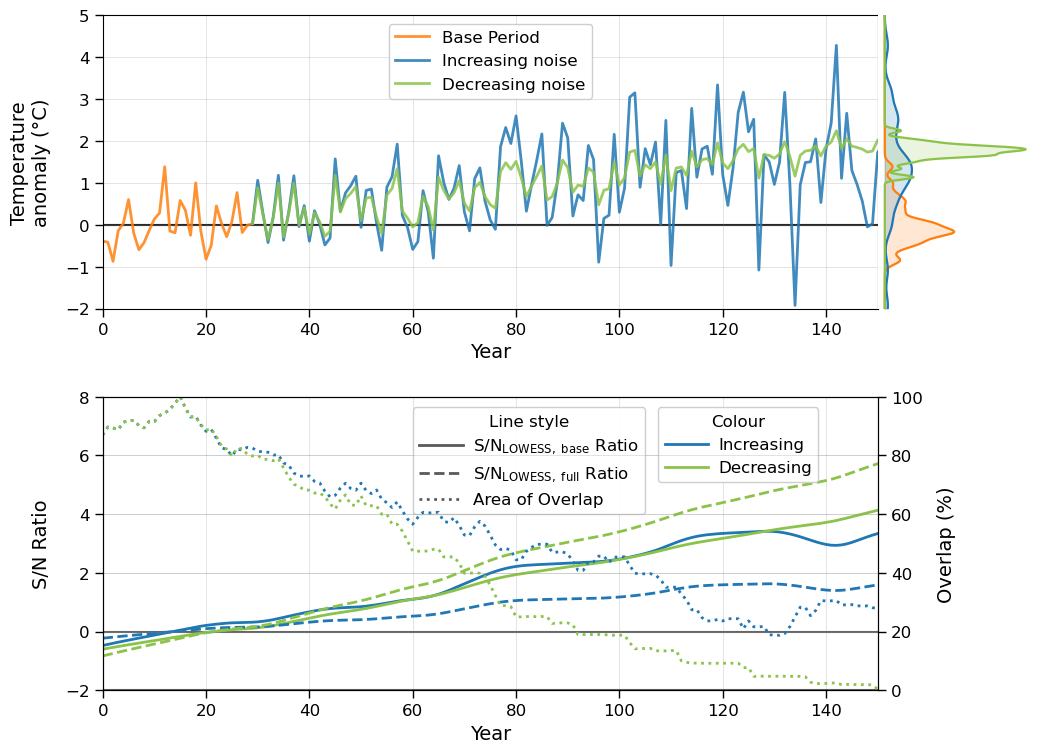

In [192]:
# --------------------------
# CONFIG
# --------------------------
year_slices = [
    (0, 30),
    # (1935, 1965),
    (120, 150)
]
bw = 0.2

# --------------------------
# LAYOUT: 3 rows × 2 cols
# row 0: inc (left main, right KDE)
# row 1: MIDDLE metrics axis (between inc & dec) — left only
# row 2: dec (left main, right KDE)
# --------------------------
fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(
    2, 2, figure=fig,
    height_ratios=[1, 1],
    width_ratios=[5, 1],
    hspace=0.30, wspace=0.00
)

ax_inc      = fig.add_subplot(gs[0, 0])
ax_inc_kde  = fig.add_subplot(gs[0, 1])
ax_mid      = fig.add_subplot(gs[1, 0])   # <-- shared metrics axis (vertically in the middle)
ax_mid_gap  = fig.add_subplot(gs[1, 1])   # placeholder to keep grid tidy; will be hidden
ax_dec      = ax_inc#fig.add_subplot(gs[2, 0])
ax_dec_kde  = ax_inc_kde#fig.add_subplot(gs[2, 1])

# Hide the middle-right placeholder
ax_mid_gap.axis('off')

# --------------------------
# DATA
# --------------------------
std_cases = ['0p5t1p5', '0p5t0p1']


iteration_num = 3
inc_da     = trend_noise_change_xr.sel(std=std_cases[0]).isel(iteration=iteration_num)
dec_da     = trend_noise_change_xr.sel(std=std_cases[1]).isel(iteration=iteration_num)
inc_met_da = non_stat_xr.sel(std=std_cases[0]).isel(iteration=iteration_num)
dec_met_da = non_stat_xr.sel(std=std_cases[1]).isel(iteration=iteration_num)

time = trend_noise_change_xr.time.values

# --------------------------
# HELPERS
# --------------------------
def _plot_kde_strip(ax_main, ax_kde, da, tslice, color, bw_method):
    # Match main-panel y-lims
    y0, y1 = ax_main.get_ylim()
    ax_kde.set_ylim(y0, y1)

    yy = np.linspace(y0, y1, 400)
    s, e = tslice
    vals = da.isel(time=slice(s, e)).values
    vals = vals[~np.isnan(vals)]
            
    kde = gaussian_kde(vals, bw_method=bw_method)
    dens = kde(yy)
    ax_kde.plot(dens, yy, lw=1.6, color=color, zorder=3)
    ax_kde.fill_betweenx(yy, 0, dens, alpha=0.18, color=color, zorder=2)


# --------------------------
# PLOTS
# --------------------------
# Top & bottom: anomalies
data_style = {'linewidth': 2, 'alpha': 0.85}
ax_inc.plot(time[:30], inc_da.values[:30], label='Base Period', color=toe_plots.color_list[1] , **data_style)
ax_inc.plot(time[29:], inc_da.values[29:], label='Increasing noise', color=toe_plots.color_list[0] , **data_style)
ax_dec.plot(time[29:], dec_da.values[29:], label='Decreasing noise', color=toe_plots.color_list[2], **data_style)

# Middle: ONE shared axis for BOTH inc & dec metrics (S/N left y, FRAC right y)
ax_mid_frac = ax_mid.twinx()
sn_metrics = ['sn_lowess_base', 'sn_lowess_full']

# S/N (left y): plot inc & dec
for metric in sn_metrics:
    # inc
    linestyle = 'solid' if 'base' in metric else 'dashed'
    ax_mid.plot(
        time, inc_met_da[metric].values, color=toe_plots.color_list[0],
        linewidth=2, linestyle=linestyle, label=f"{toe_plots.METRIC_MAP[metric]} (inc)")
    
    # dec (lighter alpha to distinguish)
    ax_mid.plot(
        time, dec_met_da[metric].values, color=toe_plots.color_list[2], 
        linewidth=2, linestyle=linestyle,label=f"{toe_plots.METRIC_MAP[metric]} (dec)")

# FRAC (right y): inc solid, dec dashed
ax_mid_frac.plot(
    time, inc_met_da['frac'].values, linewidth=2.0,
    color=toe_plots.color_list[0], linestyle='dotted', label='AO (inc)'
)
ax_mid_frac.plot(
    time, dec_met_da['frac'].values, linewidth=2.0,
    color=toe_plots.color_list[2], linestyle='dotted', label='AO (dec)'
)

# --------------------------
# STYLE & LIMITS
# --------------------------
# Left panels: anomalies
style_ax(ax_inc, ylabel="Temperature\nanomaly (°C)")
style_ax(ax_dec, ylabel="Temperature\nanomaly (°C)")
ax_inc.set_xlim(0, 150)
ax_inc.set_ylim(-2, 5)

# Middle metrics axis
style_ax(ax_mid, ylabel='S/N Ratio')
style_ax(ax_mid_frac, ylabel='Overlap (%)')




# FRAC axis
# ax_mid_frac.set_ylim(0, 100)

# KDE strips: sync to anomalies y-lims
_plot_kde_strip(ax_inc, ax_inc_kde, inc_da, (0, 30) , toe_plots.color_list[1], bw)
_plot_kde_strip(ax_inc, ax_inc_kde, inc_da, (120, 150) , toe_plots.color_list[0], bw)
_plot_kde_strip(ax_dec, ax_dec_kde, dec_da, (120, 150), toe_plots.color_list[2], bw)

ax_inc_kde.set_xticks([]); ax_inc_kde.set_yticks([])
for side in ("top", "right", "left", "bottom"):
    ax_inc_kde.spines[side].set_visible(False)


ax_mid.set_xlim(0, 150)
ax_mid_frac.set_xlim(0, 150)
mid_yticks = np.arange(-2, 10, 2)
mid_frac_yticks = np.arange(0, 120, 20)
ax_mid.set_yticks(mid_yticks)
ax_mid_frac.set_yticks(mid_frac_yticks)

ax_mid.set_ylim(np.take(mid_yticks, [0, -1]))
ax_mid_frac.set_ylim(np.take(mid_frac_yticks, [0, -1]))

# --------------------------
# LEGENDS
# --------------------------
ax_inc.legend(fontsize=12, framealpha=0.95, facecolor='white', loc='upper center')


from matplotlib.lines import Line2D

# proxies
metric_proxies = [
    Line2D([0],[0], lw=2, ls='solid',  color='0.35', label=toe_plots.METRIC_MAP['sn_lowess_base']),
    Line2D([0],[0], lw=2, ls='dashed', color='0.35', label=toe_plots.METRIC_MAP['sn_lowess_full']),
    Line2D([0],[0], lw=2, ls='dotted', color='0.35', label='Area of Overlap'),
]
case_proxies = [
    Line2D([0],[0], lw=2, ls='solid', color=toe_plots.color_list[0], label='Increasing'),
    Line2D([0],[0], lw=2, ls='solid', color=toe_plots.color_list[2], label='Decreasing'),
]

# anchor positions (axis coords)
TOP_Y    = 0.6
METRIC_X = 0.55   # slightly right of centre
CASE_X   = 0.82   # slightly left of centre

# metrics legend (right-ish)
leg_metrics = ax_mid.legend(
    metric_proxies, [h.get_label() for h in metric_proxies],
    title='Line style',
    loc='lower center', bbox_to_anchor=(METRIC_X, TOP_Y), ncol=1,
    framealpha=0.95, facecolor='white', borderaxespad=0.0,
    fontsize=12, title_fontsize=12, handlelength=2.6, handletextpad=0.6, columnspacing=1.4
)
ax_mid.add_artist(leg_metrics)

# case legend (left-ish)
ax_mid.legend(
    case_proxies, [h.get_label() for h in case_proxies],
    title='Colour',
    loc='lower center', bbox_to_anchor=(CASE_X, TOP_Y+0.08), ncol=1,
    framealpha=0.95, facecolor='white',
    fontsize=12, title_fontsize=12, handlelength=2.6, handletextpad=0.6, columnspacing=1.2
)

# leave a bit more room at the top if needed
fig.subplots_adjust(top=0.86)



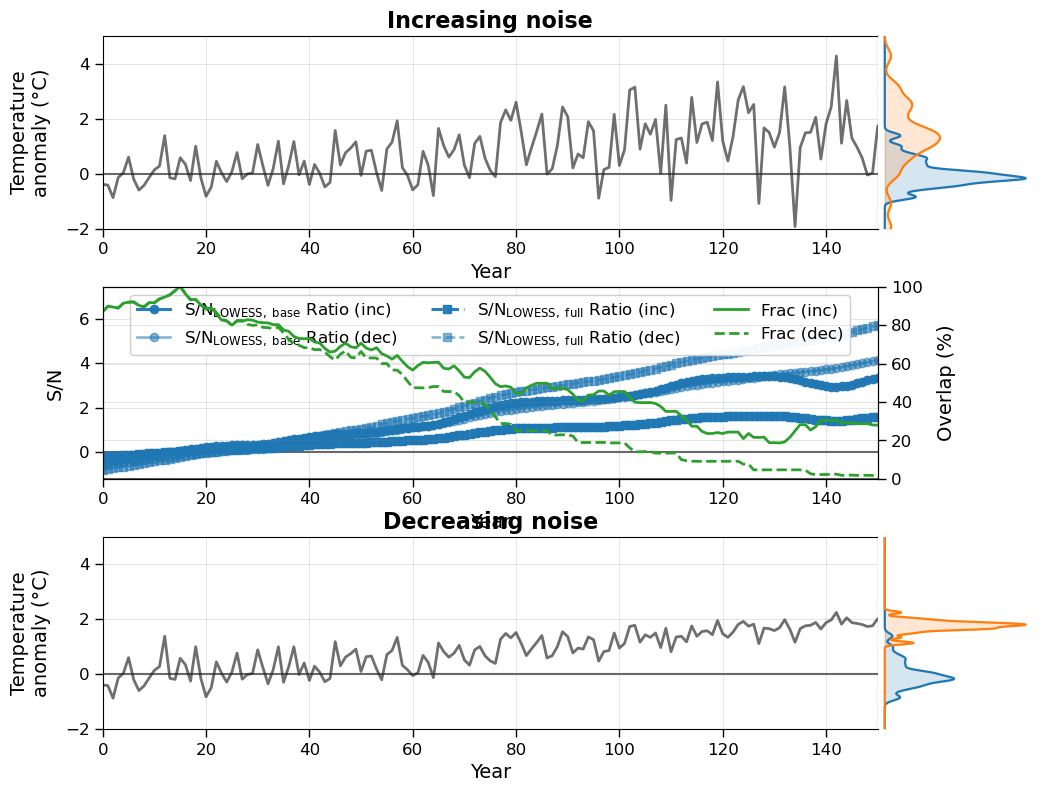

In [193]:
# --------------------------
# CONFIG
# --------------------------
year_slices = [
    (0, 30),
    # (1935, 1965),
    (120, 150)
]
bw = 0.2

# --------------------------
# LAYOUT: 3 rows × 2 cols
# row 0: inc (left main, right KDE)
# row 1: MIDDLE metrics axis (between inc & dec) — left only
# row 2: dec (left main, right KDE)
# --------------------------
fig = plt.figure(figsize=(12, 9))
gs = gridspec.GridSpec(
    3, 2, figure=fig,
    height_ratios=[1, 1, 1],
    width_ratios=[5, 1],
    hspace=0.30, wspace=0.00
)

ax_inc      = fig.add_subplot(gs[0, 0])
ax_inc_kde  = fig.add_subplot(gs[0, 1])
ax_mid      = fig.add_subplot(gs[1, 0])   # <-- shared metrics axis (vertically in the middle)
ax_mid_gap  = fig.add_subplot(gs[1, 1])   # placeholder to keep grid tidy; will be hidden
ax_dec      = fig.add_subplot(gs[2, 0])
ax_dec_kde  = fig.add_subplot(gs[2, 1])

# Hide the middle-right placeholder
ax_mid_gap.axis('off')

# --------------------------
# DATA
# --------------------------
std_cases = ['0p5t1p5', '0p5t0p1']


iteration_num = 3
inc_da     = trend_noise_change_xr.sel(std=std_cases[0]).isel(iteration=iteration_num)
dec_da     = trend_noise_change_xr.sel(std=std_cases[1]).isel(iteration=iteration_num)
inc_met_da = non_stat_xr.sel(std=std_cases[0]).isel(iteration=iteration_num)
dec_met_da = non_stat_xr.sel(std=std_cases[1]).isel(iteration=iteration_num)

time = trend_noise_change_xr.time.values

# --------------------------
# HELPERS
# --------------------------
def _plot_kde_strip(ax_main, ax_kde, da, slices, colors, bw_method):
    # Match main-panel y-lims
    y0, y1 = ax_main.get_ylim()
    ax_kde.set_ylim(y0, y1)

    yy = np.linspace(y0, y1, 400)
    for (s, e), c in zip(slices, colors):
        vals = da.isel(time=slice(s, e)).values
        vals = vals[~np.isnan(vals)]
        if vals.size < 2:
            continue
        kde = gaussian_kde(vals, bw_method=bw_method)
        dens = kde(yy)
        ax_kde.plot(dens, yy, lw=1.6, color=c, zorder=3)
        ax_kde.fill_betweenx(yy, 0, dens, alpha=0.18, color=c, zorder=2)

    ax_kde.set_xticks([]); ax_kde.set_yticks([])
    for side in ("top", "right", "left", "bottom"):
        ax_kde.spines[side].set_visible(False)

# --------------------------
# PLOTS
# --------------------------
# Top & bottom: anomalies
data_style = {'color': '#222222', 'linewidth': 2, 'alpha': 0.65}
ax_inc.plot(time, inc_da.values, label='Anomalies', **data_style)
ax_dec.plot(time, dec_da.values, **data_style)

# Middle: ONE shared axis for BOTH inc & dec metrics (S/N left y, FRAC right y)
ax_mid_frac = ax_mid.twinx()
sn_metrics = ['sn_lowess_base', 'sn_lowess_full']

# S/N (left y): plot inc & dec
for metric in sn_metrics:
    # inc
    ax_mid.plot(
        time, inc_met_da[metric].values, linewidth=2.2, alpha=0.95,
        **toe_plots.TEST_STYLES[metric],
        label=f"{toe_plots.METRIC_MAP[metric]} (inc)"
    )
    # dec (lighter alpha to distinguish)
    style_dec = dict(toe_plots.TEST_STYLES[metric])
    ax_mid.plot(
        time, dec_met_da[metric].values, linewidth=1.9, alpha=0.55,
        **style_dec,
        label=f"{toe_plots.METRIC_MAP[metric]} (dec)"
    )

# FRAC (right y): inc solid, dec dashed
ax_mid_frac.plot(
    time, inc_met_da['frac'].values, linewidth=2.0,
    color='tab:green', linestyle='solid', label='Frac (inc)'
)
ax_mid_frac.plot(
    time, dec_met_da['frac'].values, linewidth=2.0,
    color='tab:green', linestyle='dashed', label='Frac (dec)'
)

# --------------------------
# STYLE & LIMITS
# --------------------------
# Left panels: anomalies
style_ax(ax_inc, title='Increasing noise', ylabel="Temperature\nanomaly (°C)")
style_ax(ax_dec, title='Decreasing noise', ylabel="Temperature\nanomaly (°C)")
ax_inc.set_xlim(0, 150); ax_dec.set_xlim(0, 150)
ax_inc.set_ylim(-2, 5);  ax_dec.set_ylim(-2, 5)

# Middle metrics axis
style_ax(ax_mid, ylabel='S/N')
style_ax(ax_mid_frac, ylabel='Overlap (%)')

ax_mid.set_xlim(0, 150)

# ax_mid.set_ylim(sn_lo, sn_hi)

# FRAC axis
ax_mid_frac.set_xlim(0, 150)
ax_mid_frac.set_ylim(0, 100)

# KDE strips: sync to anomalies y-lims
_plot_kde_strip(ax_inc, ax_inc_kde, inc_da, year_slices, toe_plots.color_list, bw)
_plot_kde_strip(ax_dec, ax_dec_kde, dec_da, year_slices, toe_plots.color_list, bw)

# # Keep left y ticks visible on anomalies
# for a in (ax_inc, ax_dec):
#     a.tick_params(axis="y", which="both", left=True, labelleft=True)

# --------------------------
# LEGENDS
# --------------------------


# Middle metrics legend (combined S/N + FRAC)
lines_sn, labels_sn = ax_mid.get_legend_handles_labels()
lines_fr, labels_fr = ax_mid_frac.get_legend_handles_labels()
ax_mid.legend(
    lines_sn + lines_fr, labels_sn + labels_fr, ncol=3,
    loc='upper center', fontsize=12, framealpha=0.95, facecolor='white'
)

plt.show()


(-2.0, 3.0)
(-2.0, 3.0)


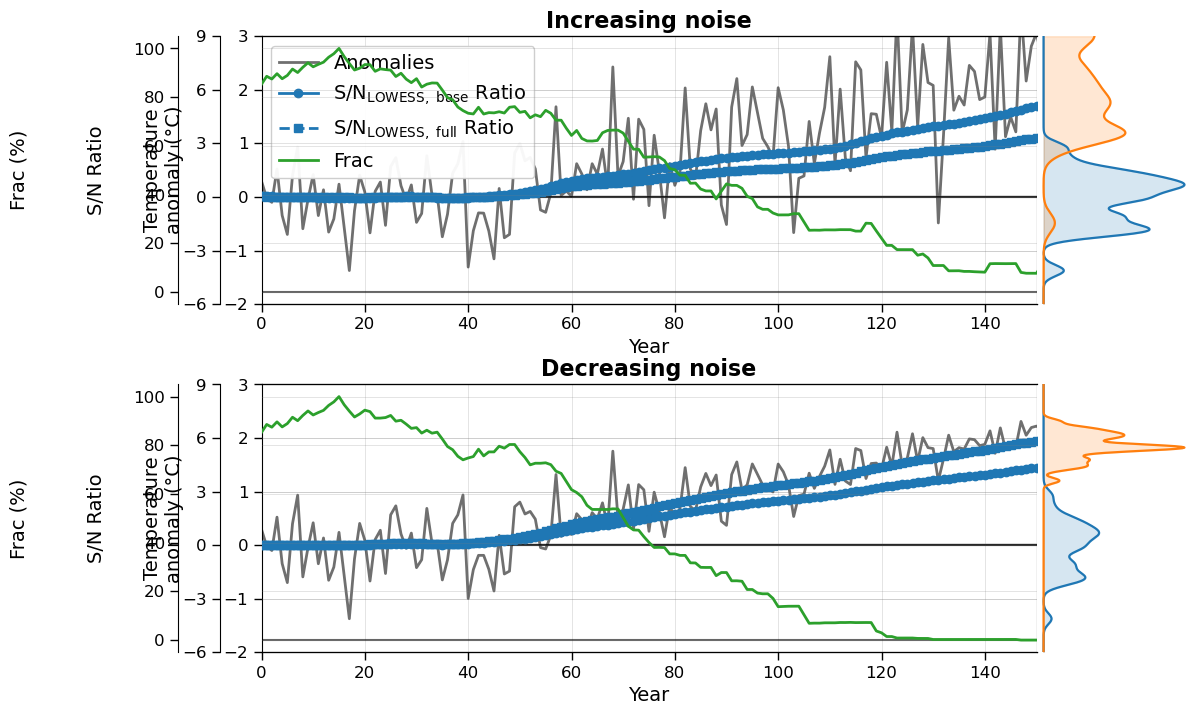

In [194]:
# --------------------------
# CONFIG
# --------------------------

year_slices = [
    (0, 30),
    # (1935, 1965),
    (120, 150)
]
bw = 0.2

# --------------------------
# LAYOUT: 2 rows × 2 cols (left: main; right: KDE strip)
# --------------------------
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(
    2, 2, figure=fig,
    height_ratios=[1, 1],
    width_ratios=[5, 1],      # slim KDE panel
    hspace=0.30, wspace=0.00  # no gap between main and KDE
)

ax_inc     = fig.add_subplot(gs[0, 0])
ax_inc_kde = fig.add_subplot(gs[0, 1])   # <-- no sharey
ax_dec     = fig.add_subplot(gs[1, 0])
ax_dec_kde = fig.add_subplot(gs[1, 1])   # <-- no sharey

# --------------------------
# DATA
# --------------------------

std_cases = ['0p5t1', '0p5t0p1']

inc_da     = trend_noise_change_xr.sel(std=std_cases[0]).isel(iteration=0)
dec_da     = trend_noise_change_xr.sel(std=std_cases[1]).isel(iteration=0)
inc_met_da = non_stat_xr.sel(std=std_cases[0]).isel(iteration=0)
dec_met_da = non_stat_xr.sel(std=std_cases[1]).isel(iteration=0)

time = trend_noise_change_xr.time.values

# --------------------------
# Y-AXES (all on LHS): main, S/N, and FRAC
# --------------------------
# S/N axis (secondary on LHS, outward 30)
ax_inc_sn  = ax_inc.twinx()
ax_dec_sn  = ax_dec.twinx()
for a_main, a_sn in ((ax_inc, ax_inc_sn), (ax_dec, ax_dec_sn)):
    a_sn.yaxis.set_label_position("left")
    a_sn.yaxis.tick_left()
    a_sn.spines["left"].set_position(("outward", 30))
    a_sn.spines["right"].set_visible(False)

# FRAC axis (third on LHS, outward 60)
ax_inc_frac = ax_inc.twinx()
ax_dec_frac = ax_dec.twinx()
for a_main, a_frac in ((ax_inc, ax_inc_frac), (ax_dec, ax_dec_frac)):
    a_frac.yaxis.set_label_position("left")
    a_frac.yaxis.tick_left()
    a_frac.spines["left"].set_position(("outward", 60))
    a_frac.spines["right"].set_visible(False)

# --------------------------
# PLOTS
# --------------------------
data_style = {'color': '#222222', 'linewidth': 2, 'alpha': 0.65}
ax_inc.plot(time, inc_da.values, label='Anomalies', **data_style)
ax_dec.plot(time, dec_da.values, **data_style)

for metric in ['sn_lowess_base', 'sn_lowess_full']:
    ax_inc_sn.plot(time, inc_met_da[metric].values, linewidth=2.0,
                   **toe_plots.TEST_STYLES[metric], label=toe_plots.METRIC_MAP[metric])
    ax_dec_sn.plot(time, dec_met_da[metric].values, linewidth=2.0,
                   **toe_plots.TEST_STYLES[metric], label=toe_plots.METRIC_MAP[metric])

# FRAC (0–100)
ax_inc_frac.plot(time, inc_met_da['frac'].values, linewidth=2.0,
                 color='tab:green', label='Frac')
ax_dec_frac.plot(time, dec_met_da['frac'].values, linewidth=2.0,
                 color='tab:green', label='Frac')

# --------------------------
# STYLE & LIMITS
# --------------------------
style_ax(ax_inc,      title='Increasing noise', ylabel="Temperature\nanomaly (°C)")
style_ax(ax_dec,      title='Decreasing noise', ylabel="Temperature\nanomaly (°C)")
style_ax(ax_inc_sn,   ylabel='S/N Ratio')
style_ax(ax_dec_sn,   ylabel='S/N Ratio')
style_ax(ax_inc_frac, ylabel='Frac (%)')
style_ax(ax_dec_frac, ylabel='Frac (%)')

# Ensure ticks/labels visible for all LHS axes
for a in (ax_inc, ax_dec, ax_inc_sn, ax_dec_sn, ax_inc_frac, ax_dec_frac):
    a.tick_params(axis="y", which="both", left=True, labelleft=True)


for ax in [ax_inc, ax_dec]:
    ax.set_xlim(0, 150)


# Main temp limits, then scale S/N ticks to match your earlier approach
ax_inc.set_ylim(-2, 3)
ax_dec.set_ylim(-2, 3)

new_sn_ticks_inc = ax_inc.get_yticks() * 3
new_sn_ticks_dec = ax_dec.get_yticks() * 3

ax_inc_sn.set_ylim(np.take(new_sn_ticks_inc, [0, -1]))
ax_dec_sn.set_ylim(np.take(new_sn_ticks_dec, [0, -1]))


# Example tick-scaling (adjust multipliers as you need)
ax_inc_sn.set_yticks(new_sn_ticks_inc);
ax_dec_sn.set_yticks(new_sn_ticks_dec);

# # X limits
# for a in (ax_inc, ax_dec, ax_inc_sn, ax_dec_sn, ax_inc_frac, ax_dec_frac):
#     a.set_xlim(1880, 2024)

# Nudge axis labels outward so they don’t crash into each other
ax_inc.yaxis.set_label_coords(-0.10, 0.5)
ax_inc_sn.yaxis.set_label_coords(-0.20, 0.5)
ax_inc_frac.yaxis.set_label_coords(-0.30, 0.5)
ax_dec.yaxis.set_label_coords(-0.10, 0.5)
ax_dec_sn.yaxis.set_label_coords(-0.20, 0.5)
ax_dec_frac.yaxis.set_label_coords(-0.30, 0.5)

# --------------------------
# KDE strip helper (no sharey; use main axis y-lims)
# --------------------------
def _plot_kde_strip(ax_main, ax_kde, da, slices, colors, bw_method):
    y0, y1 = ax_main.get_ylim()
    print( ax_main.get_ylim())
    ax_kde.set_ylim(y0, y1)

    yy = np.linspace(y0, y1, 400)
    for (s, e), c in zip(slices, colors):
        vals = da.isel(time=slice(s, e)).values
        vals = vals[~np.isnan(vals)]
        if vals.size < 2:
            continue
        kde = gaussian_kde(vals, bw_method=bw_method)
        dens = kde(yy)
        ax_kde.plot(dens, yy, lw=1.6, color=c, zorder=3)
        ax_kde.fill_betweenx(yy, 0, dens, alpha=0.18, color=c, zorder=2)

    ax_kde.set_xticks([]); ax_kde.set_yticks([])
    for side in ("top", "right", "left", "bottom"):
        ax_kde.spines[side].set_visible(False)

# Draw KDEs (sync to main y-lims)
_plot_kde_strip(ax_inc, ax_inc_kde, inc_da, year_slices, toe_plots.color_list, bw)
_plot_kde_strip(ax_dec, ax_dec_kde, dec_da, year_slices, toe_plots.color_list, bw)

# ax_inc_kde.set_ylim(*ax_inc.get_ylim())
# ax_dec_kde.set_ylim(*ax_dec.get_ylim())

# --------------------------
# Legend (merge main + S/N + FRAC)
# --------------------------
lines_main, labels_main = ax_inc.get_legend_handles_labels()
lines_sn,   labels_sn   = ax_inc_sn.get_legend_handles_labels()
lines_fr,   labels_fr   = ax_inc_frac.get_legend_handles_labels()

ax_inc.legend(
    lines_main + lines_sn + lines_fr,
    labels_main + labels_sn + labels_fr,
    loc='upper left', fontsize=14, ncol=1, framealpha=0.95, facecolor='white'
)



# # FRAC fixed range
# ax_inc_frac.set_ylim(0, 100)
# ax_dec_frac.set_ylim(0, 100)

In [195]:
new_sn_ticks_dec

array([-6., -3.,  0.,  3.,  6.,  9.])

In [196]:
# linewidths = np.linspace(3, 0.2, 5+1)
# alphas = np.linspace(0.4, 1, 4)

<h3 style='color:green'> KS: Multi-window </h3> 

In [243]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [244]:
def plot_kde_lines(ax, kde_ds, toe_ds=None, *, line_dim="rho", x_coord="x",
                   color="k", linewidth_range=(3.0, 0.4), alpha_range=(0.4, 1.0)):
    """
    Plot all `line_dim` curves from `kde_ds` on `ax`, encoding `line_dim` via linewidth/alpha.
    Args: 
        ax (plt.Axes): Target axis.
        kde_ds (xr.Dataset|xr.DataArray): KDE values indexed by line_dim and x_coord.
        toe_ds (xr.Dataset|xr.DataArray|None): Optional raw ToE values for medians.
        line_dim (str): Dimension varied within the axis (e.g., "rho").
        x_coord (str): Name of x coordinate.
        color (str): Line colour used for curves and medians.
        linewidth_range (tuple): (max_width, min_width) across `line_dim`.
        alpha_range (tuple): (min_alpha, max_alpha) across `line_dim`.
    Returns:
        list[matplotlib.lines.Line2D]: Legend proxy handles for `line_dim` encoding.
    """
    import numpy as np
    import matplotlib.lines as mlines

    x = kde_ds.coords[x_coord].values
    line_vals = kde_ds.coords[line_dim].values
    n_line = len(line_vals)

    lw_max, lw_min = linewidth_range
    a_min, a_max = alpha_range
    linewidths = np.linspace(lw_max, lw_min, n_line) if n_line > 1 else np.array([lw_max])
    alphas     = np.linspace(a_min, a_max, n_line)   if n_line > 1 else np.array([a_max])

    for j, lv in enumerate(line_vals):
        y = kde_ds.sel({line_dim: lv}).values
        ax.plot(x, y, color=color, linewidth=linewidths[j], alpha=alphas[j])
        if toe_ds is not None:
            med = np.nanmedian(toe_ds.sel({line_dim: lv}).values)
            if np.isfinite(med):
                idx = int(np.nanargmin(np.abs(x - med)))
                y_med = y[idx] if np.isfinite(y[idx]) else 0.0
                ax.plot([med, med], [0, y_med], linestyle="dashed",
                        linewidth=linewidths[j], color=color, alpha=alphas[j])

    # legend proxies for line_dim (grey so they’re neutral)
    handles = [mlines.Line2D([], [], color=color, linewidth=linewidths[j],
                             alpha=alphas[j], label=str(line_vals[j]))
               for j in range(n_line)]
    return handles


def plot_kde_stack(kde_ds, toe_ds=None, *, row_dim="std", line_dim="rho", x_coord="x",
                   color_list="k", xlim=None, xlabel="Time of Emergence (ToE)",
                   ylabel="Density", add_legend=True, legend_title=None,
                   legend_loc="upper center", legend_bbox_to_anchor=None,#(0.5, 1.02),
                   legend_ncols=4, fig=None, axes=None):
    """
    Stack subplots by `row_dim`; per row, call `plot_kde_lines` over `line_dim`.
    Args:
        kde_ds (xr.Dataset|xr.DataArray): KDE values indexed by row_dim, line_dim, x_coord.
        toe_ds (xr.Dataset|xr.DataArray|None): Optional raw ToE values for medians.
        row_dim (str): Dimension mapped to subplot rows (e.g., "std").
        line_dim (str): Dimension varied within each subplot (e.g., "rho").
        x_coord (str): Name of x coordinate.
        color_list (str|list): Single colour or list per `row_dim` value.
        xlim (tuple|None): X-axis limits; None to auto.
        xlabel (str|bool): Bottom x-axis label; False/None to skip.
        ylabel (str|bool): Left y-axis label on each subplot; False/None to skip.
        add_legend (bool): Add shared legend for `line_dim`.
        legend_title (str|None): Title for shared legend (defaults to `line_dim`).
        legend_loc (str): Legend placement.
        legend_bbox_to_anchor (tuple): Anchor for shared legend.
        legend_ncols (int): Columns for shared legend.
        fig, axes: Optional pre-created Matplotlib figure and axes.
    Returns:
        (fig, axes): Figure and 1D array of axes (len == number of `row_dim` values).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator

    row_vals = kde_ds.coords[row_dim].values
    n_rows = len(row_vals)

    # colours per row
    if isinstance(color_list, str):
        row_colors = [color_list] * n_rows
    else:
        row_colors = list(color_list)
        if len(row_colors) < n_rows:
            raise ValueError(f"color_list has {len(row_colors)} colours but {n_rows} {row_dim} values")

    # figure/axes
    if fig is None or axes is None:
        fig, axes = plt.subplots(n_rows, 1, sharex=True, figsize=(6, max(2.2 * n_rows, 3.5)))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]

    # plot each row
    line_handles = None
    for i, rv in enumerate(row_vals):
        ax = axes[i]
        color = row_colors[i]
        kde_slice = kde_ds.sel({row_dim: rv})
        toe_slice = toe_ds.sel({row_dim: rv}) if toe_ds is not None else None

        line_handles = plot_kde_lines(ax, kde_slice, toe_slice, line_dim=line_dim,
                                      x_coord=x_coord, color=color)

        
        ax.set_title(f"{row_dim} = {rv}")
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5, min_n_ticks=4))
        if ylabel: ax.set_ylabel(ylabel if isinstance(ylabel, str) else "Density", fontsize=11)
        ax.grid(True, linestyle="--", alpha=0.25)

    # x formatting
    if xlim is not None:
        axes[-1].set_xlim(*xlim)
    if xlabel:
        axes[-1].set_xlabel(xlabel if isinstance(xlabel, str) else "", fontsize=11)

    # shared legend (line_dim only)
    if add_legend and line_handles:
        legend_title = legend_title or line_dim
        leg = axes[0].legend(handles=line_handles, title=legend_title, loc=legend_loc,
                         # bbox_to_anchor=legend_bbox_to_anchor,
                         ncol=legend_ncols,
                         fontsize=12, title_fontsize=14, frameon=False)
        fig.add_artist(leg)

    fig.tight_layout(rect=(0, 0, 1, 0.96))
    return fig, np.array(axes, dtype=object)


In [245]:
std_cases = ['0p5t1p5', '0p5t0p1']

IndexError: list index out of range

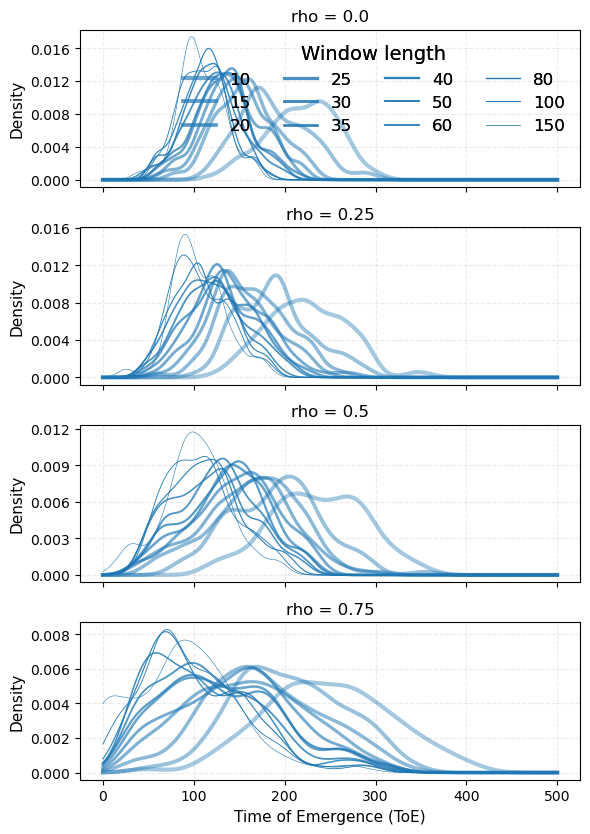

In [246]:
# fig = plt.figure(figsize=(8, 6))
# axes = [fig.add_subplot(2, 1, i+1) for i in range(2)]
plot_kde_stack(
    toe_kde_ks_window_ds.isel(std=-1), #toe_ks_window_ds.sel(std=std_cases),
    row_dim='rho', line_dim='window',
    color_list = toe_plots.color_list[0],
    # fig=fig, axes=axes,
    legend_loc='upper right', legend_title='Window length');

for num in range(len(axes)):
    ax.set_title(axes[num].set_title(std_cases[num]), fontsize=16)

In [ ]:
# fig = plt.figure(figsize=(8, 6))
# axes = [fig.add_subplot(2, 1, i+1) for i in range(2)]
# plot_kde_stack(
#     toe_kde_ks_window_ds.sel(std=std_cases), #toe_ks_window_ds.sel(std=std_cases),
#     row_dim='std', line_dim='window',
#     color_list = toe_plots.color_list[0], fig=fig, axes=axes,
#     legend_loc='upper right', legend_title='Window length');

# for num in range(len(axes)):
#     ax.set_title(axes[num].set_title(std_cases[num]), fontsize=16)

In [ ]:
fig = plt.figure(figsize=(8, 6))
axes = [fig.add_subplot(2, 1, i+1) for i in range(2)]
plot_toe_bs_kde_v3(
    toe_kde_ks_window_ds.sel(std=std_cases), #toe_ks_window_ds.sel(std=std_cases),
    row_dim='std', line_dim='window',
    color_list = toe_plots.color_list[0], fig=fig, axes=axes);

In [ ]:
plot_toe_bs_kde_v3(sn_toe_bs_kde_xr, row_dim='std', line_dim='rho')

ValueError: could not convert string to float: '0p5t1p5'

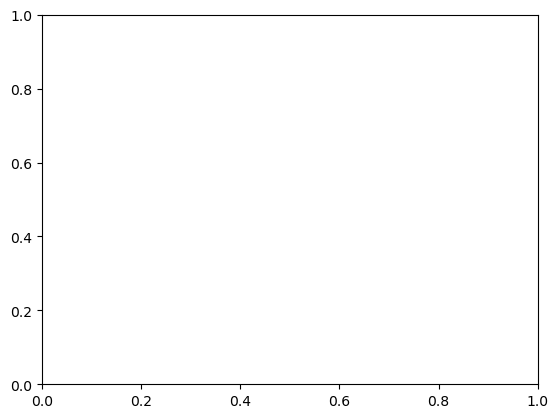

In [257]:
fig = plt.figure()
ax = fig.add_subplot(111)

for w in toe_kde_ks_window_ds.window.values:
    toe_kde_ks_window_ds.sel(window=w, std= '0p5t1p5').plot(label=w)

ax.legend()
ax.set_xlim(0, 200)

<h3 style='color:green'>  Distributions </h3> 

In [262]:
def plot_toe_bs_kde_v2(toe_bs_kde_xr, toe_bs_xr=None, colors=None, fig=None, ax=None,
                    add_legend=True, ylabel=True, color_list='k', linestyle='solid',
                      xlabel=True):
    """
    Plots Time of Emergence (ToE) bootstrapped KDE distributions for different std values, with vertical median lines.
    
    Parameters:
    - toe_bs_kde_xr: xarray.Dataset containing KDE distributions for ToE
    - toe_bs_xr: xarray.Dataset containing raw ToE values for computing medians
    - x: numpy array of x-axis values
    - fig: Optional matplotlib figure
    - axs: Optional list of matplotlib axes
    
    Returns:
    - fig, axs: Matplotlib figure and axes
    """
    # Get unique values for rho and std
    rho_values = toe_bs_kde_xr['rho'].values
    std_values = toe_bs_kde_xr['std'].values
    x = toe_bs_kde_xr.x.values
    
    
    # Create figure and gridspec if not provided
    if fig is None or ax is None:
        fig = plt.figure(figsize=(6, len(std_values) * 1.5))
        ax = fig.add_subplot(111)

    linewidths = np.linspace(3, 0.6, len(rho_values)+1)
    linestyles = [
            '-',      # solid
            '--',     # dashed
            '-.',     # dash-dot
            ':'       # dotted
        ]
    alphas = np.linspace(0.4, 1, len(rho_values))
    # Loop through std (rows)
    for i, std in enumerate(std_values):
        # Plot all rho values on the same subplot, using consistent colors
        if isinstance(color_list, str): color=color_list
        else: color=color_list[i]
        for j, rho in enumerate(rho_values):
            data = toe_bs_kde_xr.sel(std=std, rho=rho)
            ax.plot(x, data, color=color, linewidth=linewidths[j], linestyle=linestyles[j],
                    alpha=alphas[j], label=f'{rho:.2f}')
            
            # Compute and plot the median vertical line
            if toe_bs_xr is not None:
                median_x = np.nanmedian(toe_bs_xr.sel(std=std, rho=rho).values)
                median_y = data.values[np.argmin(np.abs(x - median_x))]
                ax.plot(
                    [median_x, median_x], [0, median_y],
                    linestyle="dashed", linewidth=linewidths[j], color=color, alpha=alphas[j])

        
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5, min_n_ticks=4, prune=None))
        ax.set_xlim(0, 300)
        if xlabel: ax.set_xlabel('Time of Emergence (ToE)', fontsize=12)    
        ax.grid(True, linestyle='--', alpha=0.25, color='grey')


    if add_legend:
        # Create legend entries
        std_line_list = [mlines.Line2D([], [], color=color, label=std)
                         for color, std in zip(color_list, std_subset)]
        
        rho_line_list = [mlines.Line2D([], [], color='grey', linewidth=lw, linestyle=ls, label=rho, alpha=alpha)
                         for lw, ls, alpha, rho in zip(linewidths, linestyles, alphas, rho_values)]
        
        # First legend: Standard Deviation
        leg1 = axes[0].legend(
            ncol=3, handles=std_line_list, title='Standard Deviation',
            loc='upper center', fontsize=10, title_fontsize=10, bbox_to_anchor=(0.2, 1.65))
        # Add the first legend manually so the second one doesn't overwrite it
        axes[0].add_artist(leg1)
        # Second legend: Lag-1 Autocorrelation
        axes[0].legend(
            ncol=4, handles=rho_line_list, title='Lag-1 Autocorrelation',
            loc='upper center', fontsize=10, title_fontsize=10, bbox_to_anchor=(0.7, 1.65))
    
    return fig, ax

In [263]:
# color_list = ['#1f77b4', '#ff7f0e', '#8bc34a']
# color_list = ['#0072B2', '#E69F00', '#009E73']  # Blue, Orange, Green
color_list = toe_plots.color_list#['#009E73','#0072B2', '#E69F00', ]  # Green, Blue, Orange 
# color_list = ['#1b9e77', '#d95f02', '#7570b3']  # Teal, Rust, Purple

In [264]:
plot_toe_bs_kde_custom

<function __main__.plot_toe_bs_kde_custom(kde_xr, toe_xr=None, colors=None, fig=None, gs=None, axs=None, add_legend=True, legend_loc='upper right', fontscale=1, bbox_to_anchor=None, xlim=None, hspace=0.1, linewidth=1.9, logginglevel='INFO')>

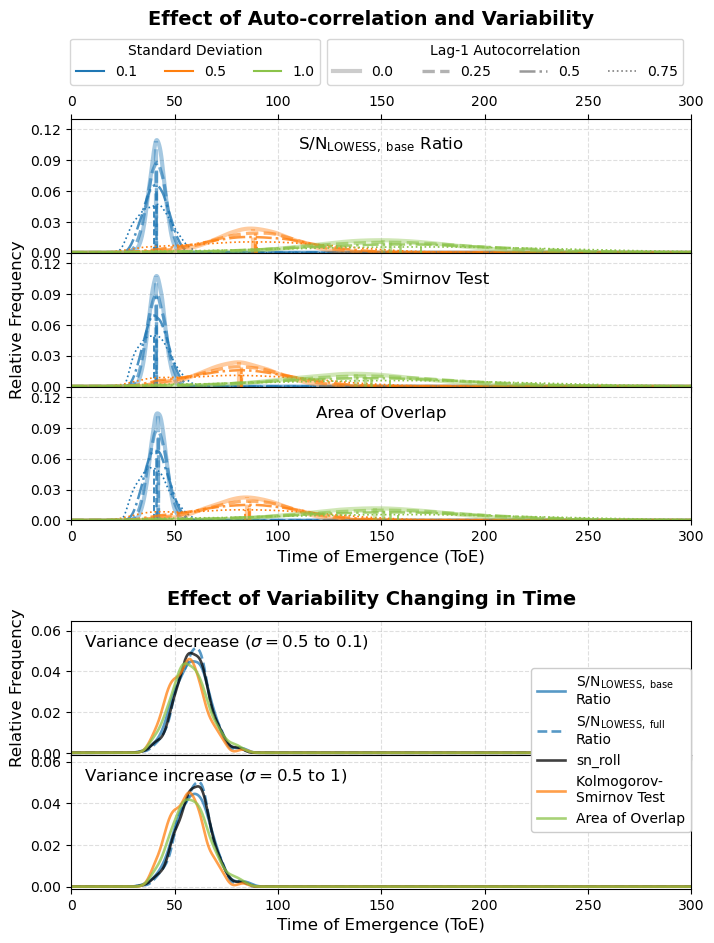

In [265]:
# fig = plt.figure(figsize=(8, 14))
fig = plt.figure(figsize=(8, 10))


subplot_height = .333
outer_gs = gridspec.GridSpec(2, 1, figure=fig, hspace=0.3, height_ratios=[3*subplot_height, 2*subplot_height])

gs_top = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer_gs[0], hspace=0)
axes =[fig.add_subplot(gs_top[i]) for i in range(3)]

gs_bottom = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[1], hspace=0.)
axes_bottom =[fig.add_subplot(gs_bottom[i]) for i in range(2)]
fig.text(0.5, 0.97, "Effect of Auto-correlation and Variability",
         ha='center', va='bottom', fontsize=14, weight='bold')
fig.text(0.5, 0.39, "Effect of Variability Changing in Time",
         ha='center', va='bottom', fontsize=14, weight='bold')

#######
std_subset = [0.1 , 0.5 , 1.  ]

plot_toe_bs_kde_v2(
    sn_toe_bs_kde_xr.sel(std=std_subset), sn_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[0], color_list=color_list, add_legend=False);

plot_toe_bs_kde_v2(
    ks_toe_bs_kde_xr.sel(std=std_subset), ks_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[1], color_list=color_list, add_legend=False, xlabel=False);

plot_toe_bs_kde_v2(
    fga_toe_bs_kde_xr.sel(std=std_subset), fga_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[2], color_list=color_list, add_legend=True);

axes[1].set_xticklabels([])
# Move ticks and label to top
axes[0].xaxis.tick_top()
# axes[0].xaxis.set_label_position('top')
axes[1].set_ylabel('Relative Frequency', fontsize=12)

ANNOTATE_KWARGS = dict(
    xy=(0.5, 0.8), xycoords='axes fraction', ha='center', va='center',
    color='k', fontsize=12)

axes[0].annotate(METRIC_MAP['sn_lowess_base'], **ANNOTATE_KWARGS)
axes[1].annotate(METRIC_MAP['ks'].replace('\n', ' '), **ANNOTATE_KWARGS)
axes[2].annotate(METRIC_MAP['frac'].replace('\n', ' '), **ANNOTATE_KWARGS)

#### Variance changes

# variance_changes = ['1p0t0p1', '0p5t1p0']
# variance_changes = ['0p25t1p5', '1p5t0p25']
variance_changes = ['0p5t0p1', '0p5t1']
# variance_changes = ['1t0p5', '0p5t1']
# variance_changes = ['0p1t1', '1t0p1']


fig, axes_bottom = plot_toe_bs_kde_custom(
    toe_non_stat_kde_xr.sel(std = variance_changes), toe_non_stat_xr,
    fig=fig, axs=axes_bottom,add_legend=False, fontscale=1)

# Even though the function has a legend, it's placed behine right column plot
# legend = axes_bottom[0].legend(ncol=2, loc='upper right', fontsize=9)
legend = axes_bottom[-1].legend(ncol=1, loc='upper right', fontsize=10,
                               bbox_to_anchor=(1.01, 1.7))


# Update legend labels with line break before 'Ratio'
for text in legend.get_texts():
    new_text = text.get_text().replace('Ratio', '\nRatio')
    text.set_text(new_text)

legend.get_frame().set_alpha(1.0)         # Fully opaque

for ax in axes_bottom:
    ax.set_xlabel('Time of Emergence (ToE)', fontsize=12)
    ax.set_xlim(0, 300)
    # ax.set_ylim(0, 0.044)# 1.2*ax.get_ylim()[-1]) #-0.001

for ax in axes:#[*axes, *axes_bottom]:
    ax.set_ylim(0, 0.13)# 1.2*ax.get_ylim()[-1]) #-0.001


std = variance_changes[0]
axes_bottom[0].annotate(
    'Variance decrease ' + r'($\sigma=$' + std.replace('p', '.').replace('t', ' to ') +')',
    fontsize=12, xy=(0.02, 0.81), xycoords='axes fraction')


std = variance_changes[-1]
axes_bottom[-1].annotate(
    'Variance increase ' + r'($\sigma=$' + std.replace('p', '.').replace('t', ' to ') +')',
    fontsize=12, xy=(0.02, 0.81), xycoords='axes fraction')


axes_bottom[0].set_ylabel('Relative Frequency', fontsize=12)

axes_bottom[0].set_xticklabels([]);

In [252]:
plot_toe_bs_kde_v2

<function __main__.plot_toe_bs_kde_v2(toe_bs_kde_xr, toe_bs_xr=None, colors=None, fig=None, ax=None, add_legend=True, ylabel=True, color_list='k', linestyle='solid', xlabel=True)>

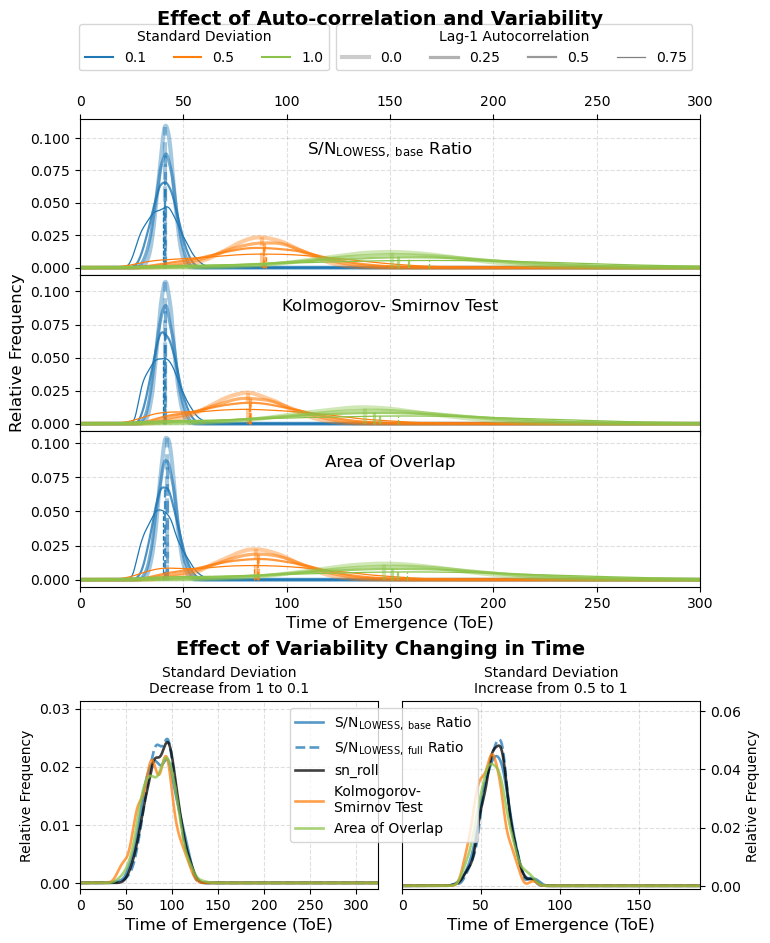

In [253]:
# fig = plt.figure(figsize=(8, 14))
fig = plt.figure(figsize=(8, 10))

outer_gs = gridspec.GridSpec(2, 1, figure=fig, hspace=0.35, height_ratios=[1, 0.4])

gs_top = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer_gs[0], hspace=0)
axes =[fig.add_subplot(gs_top[i]) for i in range(3)]

gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[1], wspace=0.08)
axes_bottom =[fig.add_subplot(gs_bottom[i]) for i in range(2)]
fig.text(0.5, 0.97, "Effect of Auto-correlation and Variability",
         ha='center', va='bottom', fontsize=14, weight='bold')
fig.text(0.5, 0.34, "Effect of Variability Changing in Time",
         ha='center', va='bottom', fontsize=14, weight='bold')

####### Var and autocorr
std_subset = [0.1 , 0.5 , 1.  ]

plot_toe_bs_kde_v2(
    sn_toe_bs_kde_xr.sel(std=std_subset), sn_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[0], color_list=color_list, add_legend=False);

plot_toe_bs_kde_v2(
    ks_toe_bs_kde_xr.sel(std=std_subset), ks_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[1], color_list=color_list, add_legend=False, xlabel=False);

plot_toe_bs_kde_v2(
    fga_toe_bs_kde_xr.sel(std=std_subset), fga_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[2], color_list=color_list, add_legend=True);

axes[1].set_xticklabels([])
# Move ticks and label to top
axes[0].xaxis.tick_top()
# axes[0].xaxis.set_label_position('top')
axes[1].set_ylabel('Relative Frequency', fontsize=12)

ANNOTATE_KWARGS = dict(
    xy=(0.5, 0.8), xycoords='axes fraction', ha='center', va='center',
    color='k', fontsize=12)

axes[0].annotate(METRIC_MAP['sn_lowess_base'], **ANNOTATE_KWARGS)
axes[1].annotate(METRIC_MAP['ks'].replace('\n', ' '), **ANNOTATE_KWARGS)
axes[2].annotate(METRIC_MAP['frac'].replace('\n', ' '), **ANNOTATE_KWARGS)

#### Variance changes


variance_changes = ['1t0p1', '0p5t1']
# variance_changes = ['1p5t0p5', '0p5t1p5']


fig, axes_bottom= plot_toe_bs_kde_custom(
    toe_non_stat_kde_xr.sel(std = variance_changes), toe_non_stat_xr,
    fig=fig, axs=axes_bottom,add_legend=False)

# Even though the function has a legend, it's placed behine right column plot
legend = axes_bottom[-1].legend(loc='upper left', fontsize=10,
                       bbox_to_anchor=(-.4, 1))

for ax in axes_bottom:
    ax.set_ylabel('Relative Frequency')
    ax.set_xlabel('Time of Emergence (ToE)', fontsize=12)   

axes_bottom[0].set_title(
    'Standard Deviation\nDecrease from ' +\
     variance_changes[0].replace('p', '.').replace('t', ' to '),
    fontsize=10)
axes_bottom[1].set_title(
    'Standard Deviation\nIncrease from ' +\
    variance_changes[1].replace('p', '.').replace('t', ' to '),
    fontsize=10)

axes_bottom[-1].yaxis.tick_right()                     # Move y-axis ticks to the right
axes_bottom[-1].yaxis.set_label_position("right")     # Move y-axis label to the right
axes_bottom[-1].tick_params(labelright=True, labelleft=False)  # Show labels on right, hide on left

Text(0.5, 0.8, 'Area of Overlap')

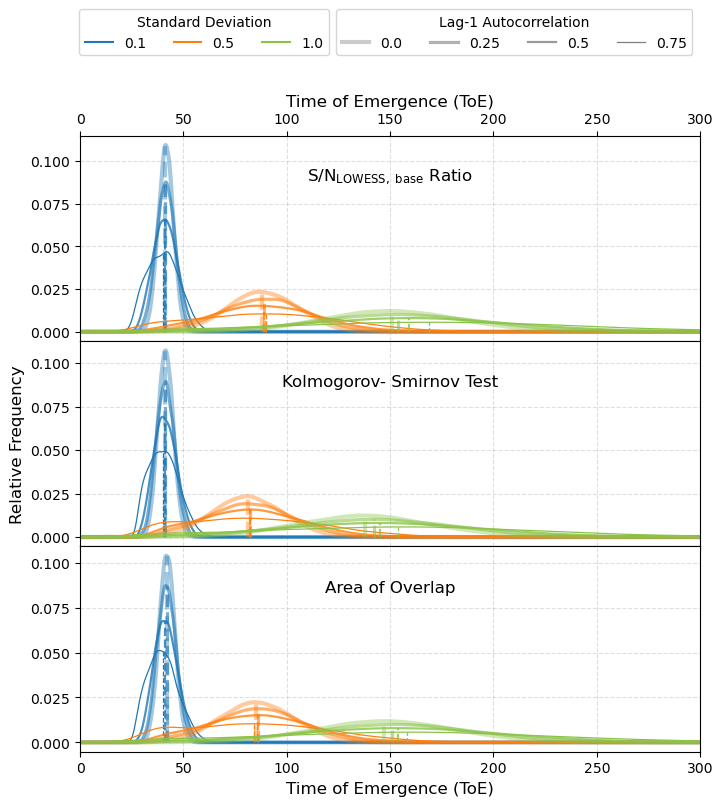

In [254]:

fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 1, figure=fig, hspace=0)
axes =[fig.add_subplot(gs[i]) for i in range(3)]


color_list = ['#1f77b4', '#ff7f0e', '#8bc34a']
std_subset = [0.1 , 0.5 , 1.  ]

plot_toe_bs_kde_v2(
    sn_toe_bs_kde_xr.sel(std=std_subset), sn_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[0], color_list=color_list, add_legend=False);

plot_toe_bs_kde_v2(
    ks_toe_bs_kde_xr.sel(std=std_subset), ks_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[1], color_list=color_list, add_legend=False, xlabel=False);

plot_toe_bs_kde_v2(
    fga_toe_bs_kde_xr.sel(std=std_subset), fga_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[2], color_list=color_list, add_legend=True);

axes[1].set_xticklabels([])
# Move ticks and label to top
axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top')
axes[1].set_ylabel('Relative Frequency', fontsize=12)

ANNOTATE_KWARGS = dict(
    xy=(0.5, 0.8), xycoords='axes fraction', ha='center', va='center',
    color='k', fontsize=12)

axes[0].annotate(METRIC_MAP['sn_lowess_base'], **ANNOTATE_KWARGS)
axes[1].annotate(METRIC_MAP['ks'].replace('\n', ' '), **ANNOTATE_KWARGS)
axes[2].annotate(METRIC_MAP['frac'].replace('\n', ' '), **ANNOTATE_KWARGS)

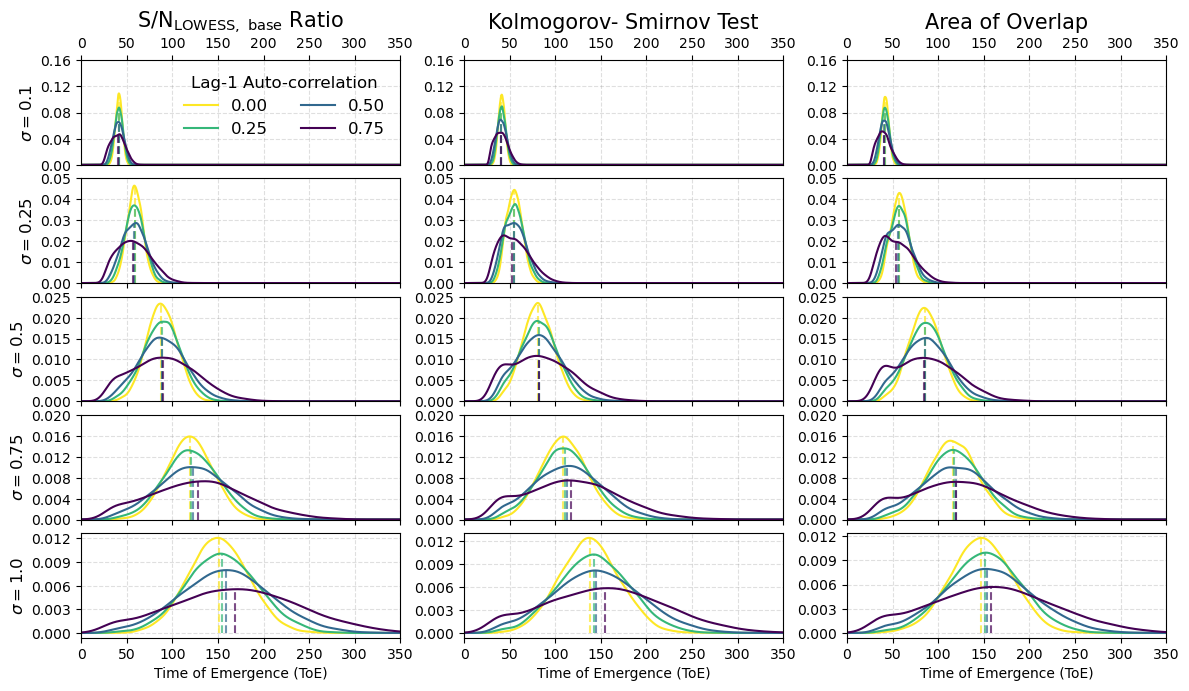

In [255]:
# Create figure and gridspec (multiple rows, 1 column)
fig = plt.figure(figsize=(14, len(std_values) * 1.5))
gs = gridspec.GridSpec(len(ks_toe_bs_kde_xr['std'].values), 3, figure=fig, hspace=0.13)
axes_left = [fig.add_subplot(gs[i, 0]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]
axes_middle = [fig.add_subplot(gs[i, 1]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]
axes_right = [fig.add_subplot(gs[i, 2]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]


plot_toe_bs_kde(sn_toe_bs_kde_xr, sn_toe_bs_xr, fig=fig, axs=axes_left, colors=colors);
plot_toe_bs_kde(ks_toe_bs_kde_xr, ks_toe_bs_xr, fig=fig, axs=axes_middle, colors=colors, ylabel=False, add_legend=False);
plot_toe_bs_kde(fga_toe_bs_kde_xr, fga_toe_bs_xr, fig=fig, axs=axes_right, colors=colors, ylabel=False, add_legend=False);


axes_left[0].set_title(METRIC_MAP['sn_lowess_base'], fontsize=15)
axes_middle[0].set_title(METRIC_MAP['ks'].replace('\n', ' '), fontsize=15)
axes_right[0].set_title(METRIC_MAP['frac'].replace('\n', ' '), fontsize=15)


for axes in [axes_left, axes_middle, axes_right]:
    for i,ax in enumerate(axes):
        if i == 0: ax.set_ylim(0, 0.16)
        if i == 1:ax.set_ylim(0, 0.05)
        if i == 2: ax.set_ylim(0, 0.025)
        if i==3: ax.set_ylim(0, 0.02)

<h1 style='color:cyan'> Trend Demonstartion </h1>

In [256]:
colors = plt.cm.viridis_r(np.linspace(0, 1, trend_bs_xr['rho'].values.shape[0]))

In [146]:
trend_bs_xr_sample = trend_bs_xr.isel(iteration=0).compute()

In [147]:
trend_non_stat_xr_sample = trend_noise_change_xr.isel(iteration=0).compute()

In [148]:
trend_non_stat_xr_sample['std'].values

array(['0p1t0p5', '0p5t0p1', '0p1t1', '1t0p1', '0p5t1', '1t0p5'],
      dtype='<U7')

In [149]:
arr.shape, true_trend.shape

((500,), (500,))

## Completion Seminar

In [ ]:
arr = trend_non_stat_xr_sample.sel(std='0p5t1')[:180]#.isel(time=slice(0, 150))
arr = arr - true_trend[:len(arr)]

In [ ]:
arr_inc = apply_variance_time_change(
    arr, window_size=30, 
    start_std = 0.25, end_std=0.75, logginglevel='DEBUG')

In [ ]:
arr_inc = arr_inc + true_trend[:len(arr_inc)]

In [ ]:
arr_constant = apply_variance_time_change(
    arr, window_size=30, 
    start_std = 0.25, end_std=0.25, logginglevel='DEBUG')

In [ ]:
arr_constant = arr_constant + true_trend[:len(arr_constant)]

In [ ]:
arr_dec = apply_variance_time_change(
    arr, window_size=30, 
    start_std = 0.25, end_std=0.01, logginglevel='DEBUG')

In [ ]:
arr_dec = arr_dec + true_trend[:len(arr_dec)]

In [ ]:
# arr_inc = arr_inc[:len(arr_constant)]

In [ ]:
arr_constant.shape, arr_dec.shape, arr_inc.shape

In [ ]:
# Create the DataArray
da_demo = xr.DataArray(
    np.stack([arr_constant, arr_inc, arr_dec], axis=0),
    dims=["std_inf", "time"],
    coords={
        "std_inf": ["const", "inc", "dec"],
        "time": np.arange(len(arr_constant))
    }
)

In [ ]:
signal_demo_xr = xr.apply_ufunc(
    my_stats.apply_lowess,
    da_demo,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    output_dtypes=[float],
    kwargs=dict(window=81)
).compute()

In [ ]:
noise_demo_xr = (da_demo-signal_demo_xr).isel(time=slice(0, base_period_length)).std(dim='time')

In [ ]:
noise_demo_full_xr = (da_demo-signal_demo_xr).std(dim='time')

In [ ]:
sn_demo_xr = signal_demo_xr/noise_demo_xr

In [ ]:
sn_demo_full_xr = signal_demo_xr/noise_demo_full_xr

In [ ]:
da_demo_window = (da_demo
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  # .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .compute()
                 ) 

In [ ]:
%%time
fga_demo_ds = toe_calc_variations.fga(
    da_demo.chunk('auto'), da_demo.isel(time=slice(0, base_period_length)).chunk('auto'),
    da_demo_window.chunk('auto')).compute()

In [ ]:
fga_demo_ds.plot(hue='std_inf');

In [ ]:
sn_demo_xr.plot(hue='std_inf');

In [ ]:
signal_demo_xr.plot(hue='std_inf');

In [ ]:
da_demo.plot(hue='std_inf');

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(arr_constant[:150])
ax2.plot(arr_inc[:150])
ax3.plot(arr_dec[:150])

In [ ]:
def plot_temp_at_loc(loc_data):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    
    loc_ds = best_tas.sel(lat=loc_data['lat'], lon=loc_data['lon'], method='nearest')
    
    ax.plot(best_tas.time.dt.year.values, loc_ds, color=color_list[0], linewidth=2.5)
    
    ax.axhline(1, color=color_list[1], linestyle='--', alpha=0.6, linewidth=1.5)
    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5, alpha=0.3)
    
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Temperature\nanomaly (°C)', fontsize=14, rotation=0, labelpad=50)
    
    ax.tick_params(labelsize=12, direction='out', length=6, width=1, colors='black')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    
    ax.set_title(loc_data['name'], fontsize=16, weight='bold', loc='center')  # left-align for less Excel look
    
    ax.annotate('1°C threshold', xy=(0.15, 1.01), xycoords=('axes fraction', 'data'),
                fontsize=12, color=color_list[1], ha='center', va='bottom')
    
    ax.set_xlim(np.take(loc_ds.time.dt.year.values, [0, -1]))
    ax.set_ylim(-1.5, 3)
    ax.axhline(0, color='k')


    std = np.std(loc_ds.values)
    print(std)

    ax.fill_between(np.take(loc_ds.time.dt.year.values, [0, -1]), -std, std, color='grey', alpha=0.3)

    ax.plot(
    best_tas.time.dt.year.values,
    signal_tree.best_tas.signal_lowess.sel(lat=loc_data['lat'], lon=loc_data['lon'], method='nearest'),
    color=color_list[2], linewidth=3
    )

    return fig, ax

In [ ]:
from toe_plots import color_list

In [ ]:
def style_temp_plot(ax):
    # ax.plot(arr, color=color_list[0], linewidth=2.5)
    
    # ax.axhline(1, color=color_list[1], linestyle='--', alpha=0.6, linewidth=1.5)
    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5, alpha=0.3)
    
    ax.set_xlabel('Year', fontsize=14)
    # ax.set_ylabel('Temperature\nanomaly (°C)', fontsize=14, rotation=0, labelpad=50)
    
    ax.tick_params(labelsize=12, direction='out', length=6, width=1, colors='black')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.set_xlabel(None)
    # ax.annotate('1°C threshold', xy=(0.15, 1.01), xycoords=('axes fraction', 'data'),
                # fontsize=12, color=color_list[1], ha='center', va='bottom')
    
    # ax.set_xlim(np.take(da.time.dt.year.values, [0, -1]))
    # ax.set_ylim(-1.5, 3)


In [ ]:
signal_demo_xr.plot(hue='std_inf');

In [ ]:
labels = ('Constant', 'Increases', 'Decreases')

In [ ]:
sn_demo_xr.std_inf.values

In [ ]:
fig = plt.figure(figsize=(8, 2*8/3))
gs = gridspec.GridSpec(2, 1, hspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(2)]

for i, si in enumerate(('inc', 'dec')):

    axes[i].plot(sn_demo_xr.sel(std_inf=si).values, color='k', linewidth=3, label='Base Period')
    axes[i].plot(sn_demo_full_xr.sel(std_inf=si).values, color=color_list[0],#linestyle='--',
                 linewidth=3, label='Full Series')


for ax in axes:
    ax.set_xlim(0, len(sn_demo_xr.time))
    style_temp_plot(ax)
    ax.set_ylabel('S/N Ratio', fontsize=18);
    leg = ax.legend(loc='center left', fontsize=15)
    # leg.set_title('Noise')                      # no fontsize here
    # leg.get_title().set_fontsize(18)            # set fontsize separately



axes[0].set_title(None)
axes[-1].set_xlabel('Year', fontsize=16)

 

axes[0].annotate('Noise Increases', fontsize=18, xy=(0.01, 0.8), xycoords='axes fraction');
axes[1].annotate('Noise Decreases', fontsize=18, xy=(0.01, 0.8), xycoords='axes fraction');

# axes[0].set_title('Noise Increases', fontsize=18);
# axes[1].set_title('Noise Decreases', fontsize=18);


fig.savefig('/g/data/w40/ab2313/images/completion_seminar/var_change_sn_var2.svg', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)


for i, si in enumerate(signal_demo_xr.std_inf.values):
    ax.plot(sn_demo_xr.sel(std_inf=si).values, color=color_list[i], linewidth=3, label=labels[i])
    ax.set_xlim(0, len(signal_demo_xr.time))


leg = ax.legend(loc='upper left', fontsize=15)
leg.set_title('Noise')                      # no fontsize here
leg.get_title().set_fontsize(18)            # set fontsize separately

style_temp_plot(ax)
ax.set_title('S/N Ratio', fontsize=18);

ax.set_xlabel('Year', fontsize=16)
fig.savefig('/g/data/w40/ab2313/images/completion_seminar/var_change_sn.svg', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)


for i, si in enumerate(signal_demo_xr.std_inf.values):
    ax.plot(fga_demo_ds.sel(std_inf=si).values, color=color_list[i], linewidth=3, label=labels[i])
    ax.set_xlim(0, len(signal_demo_xr.time))


leg = ax.legend(loc='lower left', fontsize=15)
leg.set_title('Noise')                      # no fontsize here
leg.get_title().set_fontsize(18)            # set fontsize separately

style_temp_plot(ax)
ax.set_title('Overlap', fontsize=18);

ax.set_xlabel('Year', fontsize=16)
# fig.savefig('/g/data/w40/ab2313/images/completion_seminar/var_change_overlap.svg', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 1, hspace=0.2)
axes = [fig.add_subplot(gs[i]) for i in range(3)]

for i in range(len(axes)):
    ax = axes[i]
    da_demo.isel(std_inf=i).plot(ax=ax, color=color_list[i], linewidth=3)
    style_temp_plot(ax)
    ax.set_xlim(0, len(da_demo.time))
    signal_demo_xr.isel(std_inf=i).plot(ax=ax, color='k', linewidth=2, alpha=0.7)
    
    ax.set_xlabel(None)
    ax.set_title(None)
    ax.set_ylim(-1.75, 3)


axes[0].annotate('Noise Constant', fontsize=18, xy=(0.01, 0.8), xycoords='axes fraction');
axes[1].annotate('Noise Increases', fontsize=18, xy=(0.01, 0.8), xycoords='axes fraction');
axes[2].annotate('Noise Decreases', fontsize=18, xy=(0.01, 0.8), xycoords='axes fraction');

axes[-1].set_xlabel('Year', fontsize=16);
fig.savefig('/g/data/w40/ab2313/images/completion_seminar/var_change_v02.svg', bbox_inches='tight')

In [ ]:


fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 2, width_ratios=[4, 1], wspace=0, hspace=0.3)

axes = []
for i in range(3):
    ax_main = fig.add_subplot(gs[i, 0])
    ax_side = fig.add_subplot(gs[i, 1], sharey=ax_main)
    axes.append(ax_main)

    # Time series
    da_demo.isel(std_inf=i).plot(ax=ax_main, color=color_list[i], linewidth=3)
    signal_demo_xr.isel(std_inf=i).plot(ax=ax_main, color='k', linewidth=3)
    style_temp_plot(ax_main)
    ax_main.set_xlim(0, len(da_demo.time))
    ax_main.set_ylim(-1.75, 3)
    ax_main.set_xlabel(None)
    ax_main.set_title(None)

    # Get early and late slices
    da_i = da_demo.isel(std_inf=i)
    early = da_i.sel(time=slice(0, 30))
    late = da_i.sel(time=slice(60, 90))

    # KDEs
    for data, color, alpha in zip([early, late], ['tab:blue', 'tab:red'], [0.6, 0.4]):
        data_vals = data.values
        kde = gaussian_kde(data_vals)
        y_vals = np.linspace(-2, 3, 300)
        kde_vals = kde(y_vals)
        ax_side.plot(kde_vals, y_vals, color=color)
        ax_side.fill_betweenx(y_vals, 0, kde_vals, color=color, alpha=alpha)

    ax_side.set_xticks([])
    ax_side.set_yticks([])
    ax_side.set_xlim(left=0)
    ax_side.set_xlabel(None)

# Annotations
axes[0].annotate('Noise Constant', fontsize=18, xy=(0.01, 0.8), xycoords='axes fraction')
axes[1].annotate('Noise Increases', fontsize=18, xy=(0.01, 0.8), xycoords='axes fraction')
axes[2].annotate('Noise Decreases', fontsize=18, xy=(0.01, 0.8), xycoords='axes fraction')

axes[-1].set_xlabel('Year', fontsize=16)
# fig.savefig('/g/data/w40/ab2313/images/completion_seminar/var_change_v02.svg', bbox_inches='tight')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Data
x = np.random.normal(0, 1, 500)
y = 0.5 * x + np.random.normal(0, 1, 500)

# Set up gridspec layout
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4], wspace=0.05, hspace=0.05)

ax_main = fig.add_subplot(gs[1, 0])
ax_y_dist = fig.add_subplot(gs[1, 1], sharey=ax_main)

# Main scatter plot
ax_main.scatter(x, y, alpha=0.5)
ax_main.set_xlabel("x")
ax_main.set_ylabel("y")

# Side KDE plot for y
kde = gaussian_kde(y)
y_vals = np.linspace(min(y), max(y), 300)
ax_y_dist.plot(kde(y_vals), y_vals)
ax_y_dist.fill_betweenx(y_vals, kde(y_vals), alpha=0.3)
ax_y_dist.axis('off')  # optional

plt.show()


## Appendix

In [ ]:
non_stat_std_values = trend_noise_change_xr['std'].values

In [ ]:
grad_label = grad * 10
# grad_label2 = grad_label/2

In [ ]:
length_dict

In [ ]:
non_stat_std_values

In [ ]:
length_dict

In [ ]:
std_order = list(trend_non_stat_xr_sample['std'].values)
std_order = np.array([*std_order[::2], *std_order[1::2]])
std_order

In [ ]:
fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(4,2, hspace=0.35, height_ratios=[0.25, 1, 1, 1])
ax_top = fig.add_subplot(gs[0, :])

ax_top.plot(true_trend, label=f'{grad_label:.2f} per decade')
# ax_top.plot(true_trend/2, label=f'{grad_label2:.2f} per decade')
ax_top.set_xlim(0, 500)
# ax_top.legend()
ax_top.set_xlabel('Time')

std_values = trend_bs_xr_sample['std'].values
rho_values = trend_bs_xr_sample['rho'].values

for num,rho in enumerate(rho_values):
    rho_gs = gridspec.GridSpecFromSubplotSpec(len(std_values), 1, hspace=0, subplot_spec=gs[2+num])
    rho_axes = [fig.add_subplot(rho_gs[i]) for i in range(len(std_values))]
    for num2, std in enumerate(std_values):
        ax = rho_axes[num2]
        ax.plot(trend_bs_xr_sample.sel(rho=rho, std=std).values)
        ax.annotate(r'$\sigma=$'+f'{std:0.2f}', xy=(0.05, 0.75), xycoords='axes fraction')

        # ax.set_ylabel(r'$\sigma=$'+f'\n{std:0.2f}', rotation=0, labelpad=15)
        ax.set_yticks([0, 2.5, 5])
        ax.set_ylim(-3, 8)
        ax.set_xlim(0, 500)
        if num2 < (len(std_values)-1):
            ax.set_xticklabels([])
    
    rho_axes[-1].set_xlabel('Time')
    
    rho_axes[0].set_title(r'$\rho_1=$'+f'{rho:0.2f}')


# non_stat_ax1 = fig.add_subplot(gs[-2])
# non_stat_ax2 = fig.add_subplot(gs[-1])

non_stat_std_values = std_order#trend_non_stat_xr_sample['std'].values

left_gs = gridspec.GridSpecFromSubplotSpec(
    len(non_stat_std_values)//2, 1, 
    hspace=0.3, subplot_spec=gs[-1, 0])
right_gs = gridspec.GridSpecFromSubplotSpec(
    len(non_stat_std_values)//2, 1,
    hspace=0.3, subplot_spec=gs[-1, 1])

axes_left = [fig.add_subplot(left_gs[i]) for i in range(len(non_stat_std_values)//2)]
axes_right = [fig.add_subplot(right_gs[i]) for i in range(len(non_stat_std_values)//2)]


for i in range(3):
    std_vali  = non_stat_std_values[i]
    std_valim  = non_stat_std_values[i+len(non_stat_std_values)//2]
    

    trend_non_stat_xr_sample.sel(std=std_vali).isel(time=slice(0, length_dict[std_vali])).plot(
        ax=axes_left[i], #alpha=0.5,
        # label=std_vali.replace('p', '.').replace('t', ' to ')
    )
    
    trend_non_stat_xr_sample.sel(std=std_valim).isel(time=slice(0, length_dict[std_valim])).plot(
        ax=axes_right[i], #lpha=0.5,
        # label=std_valim.replace('p', '.').replace('t', ' to ')
    )

    axes_left[i].annotate(r'$\sigma=$'+std_vali.replace('p', '.').replace('t', ' to '),
                          xy=(0.01, 0.8), xycoords='axes fraction')
    axes_right[i].annotate(r'$\sigma=$'+std_valim.replace('p', '.').replace('t', ' to '),
                           xy=(0.01, 0.8),xycoords='axes fraction')

    axes_left[i].set_ylim(axes_left[i].get_ylim()[0], 1.2*axes_left[i].get_ylim()[-1])
    axes_right[i].set_ylim(axes_right[i].get_ylim()[0], 1.2*axes_right[i].get_ylim()[-1])


    axes_left[i].set_xlim(0, length_dict[std_vali])
    axes_right[i].set_xlim(0, length_dict[std_valim])

axes_left[i].set_xlabel('Time')
axes_right[i].set_xlabel('Time')


for num3, ax in enumerate([*axes_left, *axes_right]):
    ax.set_title(None)
    ax.set_ylabel(None)


# for i in [0, 1]:
#     axes_left[i].set_xticklabels([])
#     axes_right[i].set_xticklabels([])

# leg1 = non_stat_ax1.legend()
# leg1.set_title('Variance Change')

# leg2 = non_stat_ax2.legend()
# leg2.set_title('Variance Change')
# non_stat_ax1.set_title('Increasing Variance', fontsize=14)
# non_stat_ax2.set_title('Decreasing Variance', fontsize=14)


fig.text(0.5, 0.89, "Base Trend",
         ha='center', va='bottom', fontsize=14, weight='bold')

fig.text(0.5, 0.795, "Auto-correlation and Variability",
         ha='center', va='bottom', fontsize=14, weight='bold')
fig.text(0.5, 0.3, "Variability Changing in Time",
         ha='center', va='bottom', fontsize=14, weight='bold')

In [ ]:
fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(4,2, hspace=0.3, height_ratios=[0.25, 1, 1, 0.5])
ax_top = fig.add_subplot(gs[0, :])

ax_top.plot(true_trend, label=f'{grad_label:.2f} per decade')
# ax_top.plot(true_trend/2, label=f'{grad_label2:.2f} per decade')
ax_top.set_xlim(0, 500)
ax_top.legend()

std_values = trend_bs_xr_sample['std'].values
rho_values = trend_bs_xr_sample['rho'].values

for num,rho in enumerate(rho_values):
    rho_gs = gridspec.GridSpecFromSubplotSpec(len(std_values), 1, hspace=0, subplot_spec=gs[2+num])
    rho_axes = [fig.add_subplot(rho_gs[i]) for i in range(len(std_values))]
    for num2, std in enumerate(std_values):
        ax = rho_axes[num2]
        ax.plot(trend_bs_xr_sample.sel(rho=rho, std=std).values)
        ax.set_ylabel(r'$\sigma=$'+f'\n{std:0.2f}', rotation=0, labelpad=15)
        ax.set_yticks([0, 2.5, 5])
        ax.set_ylim(-3, 8)
        ax.set_xlim(0, 500)
        if num2 < (len(std_values)-1):
            ax.set_xticklabels([])
        
    rho_axes[0].set_title(r'$\rho_1=$'+f'{rho:0.2f}')


non_stat_ax1 = fig.add_subplot(gs[-2])
non_stat_ax2 = fig.add_subplot(gs[-1])


non_stat_std_values = std_order#trend_non_stat_xr_sample['std'].values
for i in range(3):
    std_vali  = non_stat_std_values[i]
    std_valim  = non_stat_std_values[-i-1]
    

    trend_non_stat_xr_sample.sel(std=std_vali).isel(time=slice(0, length_dict[std_vali])).plot(
        ax=non_stat_ax1, alpha=0.5,
        label=std_vali.replace('p', '.').replace('t', ' to ')
    )
    
    trend_non_stat_xr_sample.sel(std=std_valim).isel(time=slice(0, length_dict[std_valim])).plot(
        ax=non_stat_ax2, alpha=0.5,
        label=std_valim.replace('p', '.').replace('t', ' to ')
    )

leg1 = non_stat_ax1.legend()
leg1.set_title('Variance Change')

leg2 = non_stat_ax2.legend()
leg2.set_title('Variance Change')
non_stat_ax1.set_title('Increasing Variance', fontsize=14)
non_stat_ax2.set_title('Decreasing Variance', fontsize=14)



In [ ]:
fig = plt.figure(figsize=(6, 10))
gs = gridspec.GridSpec(5,2)

ax_top = fig.add_subplot(gs[0, :])
rho_axes = np.array([fig.add_subplot(gs[row, col]) for row, col in [(1, 0), (1,1), (2, 0), (2, 1)]]).ravel()

ax_top.plot(true_trend)
ax_top.plot(true_trend/2)

std_values = trend_bs_xr_sample['std'].values
rho_values = trend_bs_xr_sample['rho'].values

for num,rho in enumerate(rho_values):
    ax = rho_axes[num]
    for std in std_values:
        ax.plot(trend_bs_xr_sample.sel(rho=rho, std=std).values, alpha=0.5)

In [ ]:
trend_non_stat_xr

In [ ]:
trend_bs_xr

# Old

In [ ]:
attempt_no = 2

In [ ]:
reload(toe_calc_variations)

In [ ]:
true_trend.shape

In [104]:
base_noise_xr = generate_noise_ensemble(
            1, 0, length=true_trend.shape[0],
            rtol=0.2, num_trials=10000)


std=1 - rho=0 - length=500 - atol=0.2

1 (0), 2 (100), 3 (200), 4 (300), 5 (400), 6 (500), 7 (600), 8 (700), 9 (800), 10 (900), 11 (1000), 12 (1100), 13 (1200), 14 (1300), 15 (1400), 16 (1500), 17 (1600), 18 (1700), 19 (1800), 20 (1900), 21 (2000), 22 (2100), 23 (2200), 24 (2300), 25 (2400), 26 (2500), 27 (2600), 28 (2700), 29 (2800), 30 (2900), 31 (3000), 32 (3100), 33 (3200), 34 (3300), 35 (3400), 36 (3500), 37 (3600), 38 (3700), 39 (3800), 40 (3900), 41 (4000), 42 (4100), 43 (4200), 44 (4300), 45 (4400), 46 (4500), 47 (4600), 48 (4700), 49 (4800), 50 (4900), 51 (5000), 52 (5100), 53 (5200), 54 (5300), 55 (5400), 56 (5500), 57 (5600), 58 (5700), 59 (5800), 60 (5900), 61 (6000), 62 (6100), 63 (6200), 64 (6300), 65 (6400), 66 (6500), 67 (6600), 68 (6700), 69 (6800), 70 (6900), 71 (7000), 72 (7100), 73 (7200), 74 (7300), 75 (7400), 76 (7500), 77 (7600), 78 (7700), 79 (7800), 80 (7900), 81 (8000), 82 (8100), 83 (8200), 84 (8300), 85 (8400), 86 (8500), 87 (8600), 88 (8700), 89 (8800), 90

In [105]:
non_stationary_noise

<function __main__.non_stationary_noise(arr: numpy.ndarray, start_std: float, end_std: float, window: int) -> numpy.ndarray>

In [106]:
non_stat_noise_kwargs = dict(
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    vectorize=True,
    dask = 'parallelized',
    output_dtypes=[float]
)

In [107]:
base_noise_0p1t1p0_xr = xr.apply_ufunc(
    non_stationary_noise, 
    base_noise_xr,
    kwargs = dict(start_std=0.1, end_std=1, window=30),
    **non_stat_noise_kwargs
).persist()
wait(base_noise_0p1t1p0_xr);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [108]:
base_noise_0p1t0p5_xr = xr.apply_ufunc(
    non_stationary_noise, 
    base_noise_xr,
    kwargs = dict(start_std=0.1, end_std=0.5, window=30),
    **non_stat_noise_kwargs
).persist()
wait(base_noise_0p1t0p5_xr);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [109]:
base_noise_0p5t1p0_xr = xr.apply_ufunc(
    non_stationary_noise, 
    base_noise_xr,
    kwargs = dict(start_std=0.5, end_std=1, window=30),
    **non_stat_noise_kwargs
).persist()
wait(base_noise_0p5t1p0_xr);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [110]:
def revers_time_values(ds):
    ds2 = ds.copy(deep=True)
    ds2.data = ds2.data[..., ::-1]
    return ds2

In [111]:
# Reverse nosie for trends with decreasing noise
base_noise_1p0t0p1_xr = revers_time_values(base_noise_0p1t1p0_xr)
base_noise_1p0t0p5_xr = revers_time_values(base_noise_0p5t1p0_xr)
base_noise_0p5t0p1_xr = revers_time_values(base_noise_0p1t0p5_xr)

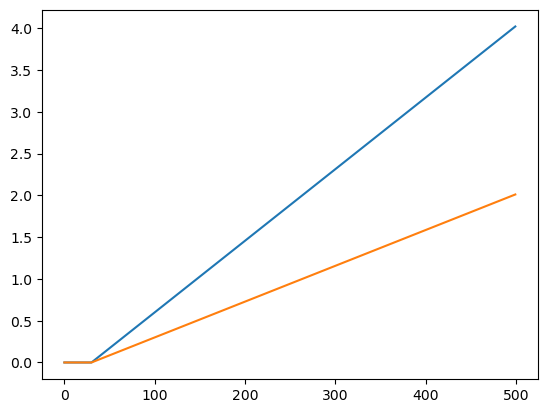

In [112]:
plt.plot(true_trend)
plt.plot(true_trend/2)

In [113]:
# Increading trends
# Divide true trend by 2 as ToE is too early
trend_0p1t1p0_xr = base_noise_0p1t1p0_xr + true_trend#/2
trend_0p5t1p0_xr = base_noise_0p5t1p0_xr + true_trend#/2
trend_0p1t0p5_xr = base_noise_0p1t0p5_xr + true_trend#/2

In [114]:
# Decrsing trends
trend_1p0t0p1_xr = base_noise_1p0t0p1_xr + true_trend
trend_1p0t0p5_xr = base_noise_1p0t0p5_xr + true_trend
trend_0p5t0p1_xr = base_noise_0p5t0p1_xr + true_trend

In [115]:
trend_0p1t1p0_xr['std'] = '0p1t1p0'
trend_0p5t1p0_xr['std'] = '0p5t1p0'
trend_0p1t0p5_xr['std'] = '0p1t0p5'
trend_1p0t0p1_xr['std'] = '1p0t0p1'
trend_1p0t0p5_xr['std'] = '1p0t0p5'
trend_0p5t0p1_xr['std'] = '0p5t0p1'

In [116]:
trend_non_stat_xr = xr.concat(
    [trend_0p1t1p0_xr, trend_0p5t1p0_xr, trend_0p1t0p5_xr,
     trend_1p0t0p1_xr, trend_1p0t0p5_xr, trend_0p5t0p1_xr], dim='std')

In [117]:
trend_non_stat_xr

<xarray.DataArray (std: 6, iteration: 10000, time: 500)> Size: 240MB
dask.array<chunksize=(1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    rho        int64 8B 0
  * std        (std) <U7 168B '0p1t1p0' '0p5t1p0' ... '1p0t0p5' '0p5t0p1'

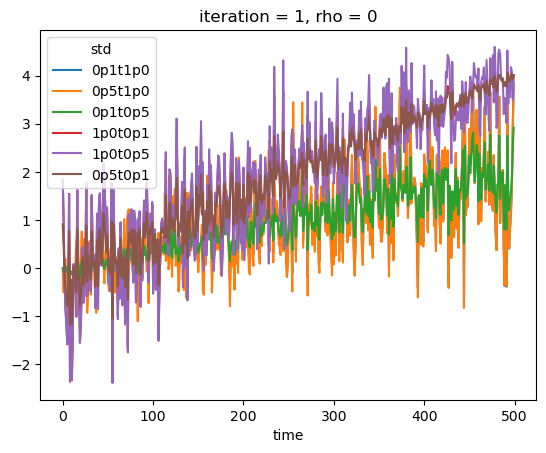

In [118]:
trend_non_stat_xr.isel(iteration=1).plot(hue='std');

<h2 style='color:yellow'> ToE Calculation </h2>

In [119]:
data_ds_window_non_stat = (trend_non_stat_xr
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  # .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds_non_stat = (trend_non_stat_xr.sel(time=slice(0, base_period_length))
                         # .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )
wait(data_ds_window_non_stat);
wait(base_period_window_ds_non_stat);

In [120]:
%%time
ks_non_stat_ds = toe_calc_variations.ks(data_ds_window_non_stat.isel(iteration=slice(0,100)),
                                        base_period_window_ds_non_stat.isel(iteration=slice(0,100)))

In [121]:
trend_non_stat_xr

<xarray.DataArray (std: 6, iteration: 10000, time: 500)> Size: 240MB
dask.array<chunksize=(1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    rho        int64 8B 0
  * std        (std) <U7 168B '0p1t1p0' '0p5t1p0' ... '1p0t0p5' '0p5t0p1'

In [122]:

fga_non_stat_ds = toe_calc_variations.fga(
    trend_non_stat_xr,#.isel(iteration=slice(0,100)),
    trend_non_stat_xr.isel(time=slice(0, base_period_length)),#.isel(iteration=slice(0,100)),
    data_ds_window_non_stat#.isel(iteration=slice(0,100))
).compute()

In [123]:
reload(toe_calc_variations)

<module 'toe_calc_variations' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc_variations.py'>

In [124]:
%%time
sn_non_stat_xr = toe_calc_variations.sn_ratio(
    trend_non_stat_xr,#.isel(iteration=slice(0,100)),
    start=0, end=30)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 228.90 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [145]:
sn_non_stat_xr

<xarray.Dataset> Size: 1GB
Dimensions:         (iteration: 10000, time: 500, std: 6)
Coordinates:
  * iteration       (iteration) int64 80kB 0 1 2 3 4 ... 9996 9997 9998 9999
  * time            (time) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
    rho             int64 8B 0
  * std             (std) <U7 168B '0p1t1p0' '0p5t1p0' ... '1p0t0p5' '0p5t0p1'
Data variables:
    sn              (std, iteration, time) float64 240MB 0.3106 0.292 ... 7.731
    sn_lowess_full  (std, iteration, time) float64 240MB 0.06535 ... 12.1
    sn_roll         (std, iteration, time) float64 240MB nan nan nan ... nan nan
    noise           (std, iteration, time) float64 240MB -0.04482 ... 0.01647
    signal          (std, iteration, time) float64 240MB 0.0389 ... 3.846

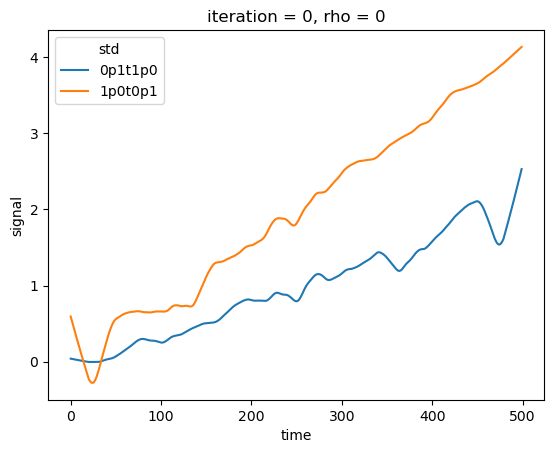

In [125]:
sn_non_stat_xr.signal.sel(std=['0p1t1p0', '1p0t0p1']).isel(iteration=0).plot(hue='std');

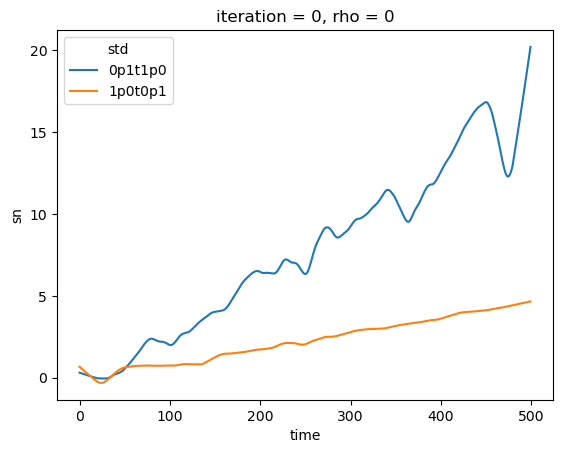

In [126]:
sn_non_stat_xr.sn_lowess_base.sel(std=['0p1t1p0', '1p0t0p1']).isel(iteration=0).plot(hue='std');

<h2 style='color:yellow'>  Saving and Opening Data </h2>

In [35]:
# base_noise_xr.to_zarr(os.path.join(SAVE_DIR, 'base_noise_non_stat_var.zarr'), mode='w')
# trend_non_stat_xr.to_zarr(os.path.join(SAVE_DIR, 'trend_non_stat_var.zarr'), mode='w')
# sn_non_stat_xr.to_zarr(os.path.join(SAVE_DIR, 'sn_non_stat_var.zarr'), mode='w')
# ks_non_stat_ds.to_zarr(os.path.join(SAVE_DIR, 'ks_non_stat_var.zarr'), mode='w')
# fga_non_stat_ds.to_zarr(os.path.join(SAVE_DIR, 'ga_non_stat_var.zarr'), mode='w')

In [36]:
chunks = {'time':-1, 'iteration':200}

In [37]:
base_noise_xr = xr.open_zarr(os.path.join(SAVE_DIR, 'base_noise_non_stat_var.zarr')).to_array().chunk(**chunks)
trend_non_stat_xr = xr.open_zarr(os.path.join(SAVE_DIR, 'trend_non_stat_var.zarr')).chunk(**chunks)
sn_non_stat_xr = xr.open_zarr(os.path.join(SAVE_DIR, 'sn_non_stat_var.zarr')).chunk(**chunks)
ks_non_stat_ds = xr.open_zarr(os.path.join(SAVE_DIR, 'ks_non_stat_var.zarr')).chunk(**chunks)
fga_non_stat_ds = xr.open_zarr(os.path.join(SAVE_DIR, 'ga_non_stat_var.zarr')).chunk(**chunks)

<h2 style='color:yellow'>  ToE Calculation </h2>

In [39]:
%%time
sn_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
    sn_non_stat_xr[['sn_lowess_base', 'sn_lowess_full', 'sn_roll']],
    threshold=1, comparison_func=np.greater,
    time=sn_non_stat_xr.time.values.astype(int), trim_nan=True).compute()

CPU times: user 9.66 s, sys: 3.91 s, total: 13.6 s
Wall time: 17.2 s


In [38]:
%%time
ks_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
            ks_non_stat_ds, threshold=0.01, comparison_func=np.less, time=ks_non_stat_ds.time.values).compute()

CPU times: user 1.64 s, sys: 753 ms, total: 2.39 s
Wall time: 3.67 s


In [40]:
fga_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
            fga_non_stat_ds, threshold=62, comparison_func=np.less, time=fga_non_stat_ds.time.values).compute()

In [42]:
%%time
sn_toe_non_stat_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    sn_toe_non_stat_xr,
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 5.34 s, sys: 806 ms, total: 6.15 s
Wall time: 3.76 s


In [41]:
%%time
ks_toe_non_stat_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    ks_toe_non_stat_xr,
    **kde_create_kwargs
).compute();

CPU times: user 95.4 ms, sys: 9.38 ms, total: 105 ms
Wall time: 63.5 ms


<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


In [43]:
%%time
fga_toe_non_stat_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    fga_toe_non_stat_xr,
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 1.75 s, sys: 262 ms, total: 2.02 s
Wall time: 1.23 s


In [44]:
ks_toe_non_stat_kde_xr['x'] = x
fga_toe_non_stat_kde_xr['x'] = x
sn_toe_non_stat_kde_xr['x'] = x

In [ ]:
for rho in sn_toe_bs_kde_xr['rho'].values:
    plt.plot(x, sn_toe_bs_kde_xr.sel(std=0.1, rho=rho))

In [ ]:
for std in sn_toe_bs_kde_xr['std'].values:
    plt.plot(x, sn_toe_bs_kde_xr.sel(std=std, rho=0.75))

In [ ]:
sn_toe_bs_kde_xr

In [ ]:
sn_toe_bs_xr

In [ ]:

sn_toe_bs_kde_m1 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=0).values, x)

In [ ]:
toe_median_1 = toe_calc.get_permanent_exceedance(
            sn_bs_xr.median(dim='iteration'), threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [ ]:
toe_median_1

In [ ]:
# toe_median_1#.isel(multiplier=0)

In [ ]:
 # Get the std of signal at the time when the median S/N ration between iterations is one
singal_range_list = []
for mult in toe_median_1.multiplier.values:
    median_toe = toe_median_1.sel(multiplier=mult).values.astype(int).item()
    signal_range = signal_bs_xr.sel(multiplier=mult).isel(time=median_toe)#.std()
    singal_range_list.append(signal_range)
signal_range_xr = xr.concat(singal_range_list, dim='multiplier')

In [ ]:
ratio_s_std_to_noise_std = signal_range_xr.std(dim='iteration')/noise_bs_xr.std(dim='iteration')

In [ ]:
ratio_s_std_to_noise_std

In [ ]:
x = np.linspace(0, 200, 1000)

In [ ]:
sn_toe_bs_xr

In [ ]:
sn_toe_bs_kde_m1 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=0).values, x)
sn_toe_bs_kde_m2 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=1).values, x)
sn_toe_bs_kde_m3 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=2).values, x)
sn_toe_bs_kde_m4 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=3).values, x)

In [ ]:
plt.plot(x, sn_toe_bs_kde_m1, label='1')
plt.plot(x, sn_toe_bs_kde_m2, label='2')
plt.plot(x, sn_toe_bs_kde_m3, label='3')
plt.plot(x, sn_toe_bs_kde_m4, label='4')
plt.legend()

In [ ]:
trend_anom_bs_xr = trend_bs_xr - trend_bs_xr.isel(time=slice(0, 30)).mean(dim='time')

In [ ]:
signal_bs_xr = xr.apply_ufunc(
    my_stats.apply_lowess,
    trend_anom_bs_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True
)

In [ ]:
noise_bs_xr = trend_bs_xr.isel(time=slice(0, 30)).std(dim='time')

In [ ]:
sn_bs_xr = signal_bs_xr/noise_bs_xr

In [ ]:
sn_toe_bs_xr = toe_calc.get_permanent_exceedance(
            sn_bs_xr, threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [ ]:
toe_median_1 = toe_calc.get_permanent_exceedance(
            sn_bs_xr.median(dim='iteration'), threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [ ]:
toe_median_1

In [ ]:
# toe_median_1#.isel(multiplier=0)

In [ ]:
 # Get the std of signal at the time when the median S/N ration between iterations is one
singal_range_list = []
for mult in toe_median_1.multiplier.values:
    median_toe = toe_median_1.sel(multiplier=mult).values.astype(int).item()
    signal_range = signal_bs_xr.sel(multiplier=mult).isel(time=median_toe)#.std()
    singal_range_list.append(signal_range)
signal_range_xr = xr.concat(singal_range_list, dim='multiplier')

In [ ]:
ratio_s_std_to_noise_std = signal_range_xr.std(dim='iteration')/noise_bs_xr.std(dim='iteration')

In [ ]:
ratio_s_std_to_noise_std

In [ ]:
x = np.linspace(0, 200, 1000)

In [ ]:
sn_toe_bs_xr

In [ ]:
sn_toe_bs_kde_m1 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=0).values, x)
sn_toe_bs_kde_m2 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=1).values, x)
sn_toe_bs_kde_m3 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=2).values, x)
sn_toe_bs_kde_m4 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=3).values, x)

In [ ]:
plt.plot(x, sn_toe_bs_kde_m1, label='1')
plt.plot(x, sn_toe_bs_kde_m2, label='2')
plt.plot(x, sn_toe_bs_kde_m3, label='3')
plt.plot(x, sn_toe_bs_kde_m4, label='4')
plt.legend()

In [ ]:


noise_bs_xr = generate_noise_ensemble(0.25, 0.2, length=true_trend.shape[0])

In [ ]:
trend_bs_xr = noise_bs_xr + true_trend

In [ ]:
multipliers = [1, 2, 3, 4]

# Stack different noise scalings into a new "multiplier" dimension
trend_bs_xr = xr.concat([true_trend + noise_bs_xr * m for m in multipliers], dim="multiplier")

# Assign correct multiplier labels
trend_bs_xr["multiplier"] = multipliers
trend_bs_xr

In [ ]:
trend_anom_bs_xr = trend_bs_xr - trend_bs_xr.isel(time=slice(0, 30)).mean(dim='time')

In [ ]:
signal_bs_xr = xr.apply_ufunc(
    my_stats.apply_lowess,
    trend_anom_bs_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True
)

In [ ]:
noise_bs_xr = trend_bs_xr.isel(time=slice(0, 30)).std(dim='time')

In [ ]:
sn_bs_xr = signal_bs_xr/noise_bs_xr

In [ ]:
sn_toe_bs_xr = toe_calc.get_permanent_exceedance(
            sn_bs_xr, threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [ ]:
toe_median_1 = toe_calc.get_permanent_exceedance(
            sn_bs_xr.median(dim='iteration'), threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [ ]:
toe_median_1

In [ ]:
# toe_median_1#.isel(multiplier=0)

In [ ]:
 # Get the std of signal at the time when the median S/N ration between iterations is one
singal_range_list = []
for mult in toe_median_1.multiplier.values:
    median_toe = toe_median_1.sel(multiplier=mult).values.astype(int).item()
    signal_range = signal_bs_xr.sel(multiplier=mult).isel(time=median_toe)#.std()
    singal_range_list.append(signal_range)
signal_range_xr = xr.concat(singal_range_list, dim='multiplier')

In [ ]:
ratio_s_std_to_noise_std = signal_range_xr.std(dim='iteration')/noise_bs_xr.std(dim='iteration')

In [ ]:
ratio_s_std_to_noise_std

In [ ]:
x = np.linspace(0, 200, 1000)

In [ ]:
sn_toe_bs_xr

In [ ]:
sn_toe_bs_kde_m1 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=0).values, x)
sn_toe_bs_kde_m2 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=1).values, x)
sn_toe_bs_kde_m3 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=2).values, x)
sn_toe_bs_kde_m4 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=3).values, x)

In [ ]:
plt.plot(x, sn_toe_bs_kde_m1, label='1')
plt.plot(x, sn_toe_bs_kde_m2, label='2')
plt.plot(x, sn_toe_bs_kde_m3, label='3')
plt.plot(x, sn_toe_bs_kde_m4, label='4')
plt.legend()

In [ ]:
noise_bs_xr.plot()

In [ ]:
sn_bs_xr.plot(hue='iteration', add_legend=False);

In [ ]:
signal_bs_xr.plot(hue='iteration', add_legend=False);

In [ ]:
trend_series.plot(hue='iteration', add_legend=False);

In [ ]:
noise_series_xr.plot(hue='iteration', add_legend=False);

In [ ]:
noise_series_list.shape

In [ ]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [ ]:
stats_test_1d_array_ks = partial(
    toe_calc.stats_test_1d_array, stats_func=toe_calc.return_ks_pvalue,
    window=window, base_period_length=base_period.length+1)

In [ ]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp).isel(**ensemble_kwargs).values)

In [ ]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2)), **ensemble_kwargs).values, label='roll', alpha=0.5)
plt.legend()